# Setting

In [ ]:
# Load dataset
#!pip3 install --upgrade oauth2client
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Please upload your csv on your google drive, give access to anyone, copy the link, and update the file ID and name.
google_docs = {
    '10EKrWLtL-Qqxyje4hyYtdj1eTVfihpoE' : 'clean_bank_Boost.csv',
    '13I9vgQ7InKF1-PfGXIIVBhSR0aaqjfOH' : 'clean_bank_train_Boost.csv',
    '1Bk9wFYStJPbXKtzi_DcawyzWF3Vo7rCq' : 'clean_bank_test_Boost.csv',
    '1j7HOEKLZctvRBl14vtglzYYzT-PIsiJd' : 'tutorial7.py',
    '1bQhKWLDYYW3NYGxYfY506B6lJ7Mk9G6Y' : 'tutorial2.py',
    '1ZhkHvU0bUYACMgnEnPDa61pdj1VC5F5y' : 'clean_store.csv',
    '1xXj4zNWaa9ETXKcIjORh18eRUpPWSWmq' : 'encoded_store.csv'

}


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for key in google_docs:
  drive.CreateFile({'id':key}).GetContentFile(google_docs[key])

In [ ]:
#!pip install cartopy
!pip install catboost
!pip install optuna
!pip install category_encoders
!pip install shap
!pip install dataprep
!pip install pygam==0.8.0
#!pip install xgboost
#!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Requirements 
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dataprep
import sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost
import optuna
import sys

from sklearn.model_selection import train_test_split

from tutorial7 import plot_feature_importance

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
# print(f'cartopy {cartopy.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'xgboost {xgb.__version__}')
print(f'lightgbm {lgb.__version__}')
print(f'catboost {catboost.__version__}')
print(f'optuna {optuna.__version__}')

# Notebook tested on:

# numpy 1.23.5
# scipy 1.10.0
# pandas 1.5.2
# seaborn 0.12.2
# cartopy 0.21.1
# scikit-learn 1.2.0
# xgboost 1.6.1
# lightgbm 3.3.2
# catboost 1.0.6
# optuna 2.10.1



Package versions: 

numpy 1.22.4
scipy 1.10.1
pandas 1.5.3
seaborn 0.12.2
scikit-learn 1.2.2
xgboost 1.7.5
lightgbm 3.3.5
catboost 1.2
optuna 3.1.1


In [ ]:
import warnings
warnings.filterwarnings('ignore') 

# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['figure.dpi'] = 80
%config InlineBackend.figure_format = 'retina'


In [ ]:
# Funtions

def plot_feature_importance(model, labels, max_features = 20):
    feature_importance = model.feature_importances_*100
    # feature_importance = model.feature_importance(importance_type='gain')
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax



def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total Actuall Subscribed: ', np.sum(cm[1]))

# Bank

In [ ]:
# Without encoding
bank = pd.read_csv('clean_bank_Boost.csv')

# Indicator variable for pdays is 999
bank=bank.drop('pdays',axis=1)


index_train_v, index_test = train_test_split(bank.index, train_size=0.8, random_state=7)


train_v = bank.loc[index_train_v, :].copy()
test = bank.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()


X_train = train.loc[:, train.columns!='y'].copy()
X_valid = valid.loc[:, test.columns!='y'].copy()
X_test = test.loc[:, test.columns!='y'].copy()

predictors = list(X_train.columns)

y_train = train['y']
y_valid = valid['y']
y_test = test['y']

In [ ]:
X_train

age          job   marital     education  default housing loan  \
17211   58     services   married       unknown  unknown     yes   no   
158     56       admin.  divorced       unknown  unknown      no   no   
30440   43  blue-collar   married       basic4y       no      no  yes   
13445   26   technician  divorced  professional       no      no  yes   
8538    30       admin.  divorced    university  unknown     yes   no   
...    ...          ...       ...           ...      ...     ...  ...   
13487   48       admin.    single    university       no      no   no   
34245   34   management   married    university       no      no   no   
6827    35    housemaid   married       basic4y       no      no   no   
2685    37       admin.   married    university       no     yes   no   
27808   40  blue-collar   married       basic6y  unknown     yes   no   

         contact month day_of_week  previous     poutcome  emp_var_rate  \
17211   cellular   aug         tue         0  nonexistent           1.4   
158    telephone   may         mon         0  nonexistent           1.1   
30440   cellular   may         thu         1      success          -1.8   
13445   cellular   jul         tue         0  nonexistent           1.4   
8538   telephone   jun         fri         0  nonexistent           1.4   
...          ...   ...         ...       ...          ...           ...   
13487  telephone   jul         tue         0  nonexistent           1.4   
34245  telephone   oct         wed         0  nonexistent          -3.4   
6827   telephone   may         fri         0  nonexistent           1.1   
2685   telephone   may         wed         0  nonexistent           1.1   
27808   cellular   may         wed         1      failure          -1.8   

       cons_price_idx  cons_conf_idx  euribor_3m  nr_employed  pdays_999  
17211          93.444          -36.1       4.968       5228.1          1  
158            93.994          -36.4       4.857       5191.0          1  
30440          92.893          -46.2       1.266       5099.1          0  
13445          93.918          -42.7       4.961       5228.1          1  
8538           94.465          -41.8       4.967       5228.1          1  
...               ...            ...         ...          ...        ...  
13487          93.918          -42.7       4.961       5228.1          1  
34245          92.431          -26.9       0.742       5017.5          1  
6827           93.994          -36.4       4.864       5191.0          1  
2685           93.994          -36.4       4.859       5191.0          1  
27808          92.893          -46.2       1.334       5099.1          1  

[20775 rows x 18 columns]

In [ ]:
nominal = list(X_train.columns[X_train.dtypes == "object"])
features = list(X_train.columns[X_train.dtypes != "object"])

# Feature engineering

## Get dummies for binary

In [ ]:
binary = ['default','housing','loan','poutcome','contact']

variable = binary


dummies = pd.get_dummies(bank[variable])

dummies = dummies.drop(['default_no', 'housing_no','loan_no','poutcome_failure','contact_cellular'], axis=1)

train = train.join(dummies.loc[index_train, :])
valid = valid.join(dummies.loc[index_valid, :])
test = test.join(dummies.loc[index_test, :])


# train = train.drop(['default_no', 'housing_no','loan_no','poutcome_failure','contact_cellular'], axis=1)
# valid = valid.drop(['default_no', 'housing_no','loan_no','poutcome_failure','contact_cellular'], axis=1)
# test = test.drop(['default_no', 'housing_no','loan_no','poutcome_failure','contact_cellular'], axis=1)

train = train.drop(variable, axis=1)
valid = valid.drop(variable, axis=1)
test = test.drop(variable, axis=1)

binary_dummies = list(dummies.columns)

## Nominal encoding

In [ ]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.glmm import GLMMEncoder
from category_encoders.cat_boost import CatBoostEncoder

In [ ]:
continuous = ['age', 'emp_var_rate','cons_price_idx',
                 'cons_conf_idx','euribor_3m','nr_employed']

nominal = ['job', 'marital', 'month', 'day_of_week']

binary = ['default','housing','loan','poutcome','contact']

discrete = ['previous']

ordinal = ['education']

response = ['y']

In [ ]:
# We dont encode the discrete values because decision trees take a range anyways so we dont have to.

nominal = ['job', 'marital', 'education', 'month', 'day_of_week']

for x in nominal:
    # Target encoder
    encoder = TargetEncoder().fit(train[x], y_train) # we must use the training set for this
    train[x+'TE'] = encoder.transform(train[x])
    valid[x+'TE'] = encoder.transform(valid[x])
    test[x+'TE'] = encoder.transform(test[x])


    # Leave one out encoder
    encoder = LeaveOneOutEncoder().fit(train[x], y_train) 
    train[x+'LeaveOneOut'] = encoder.transform(train[x])
    valid[x+'LeaveOneOut'] = encoder.transform(valid[x])
    test[x+'LeaveOneOut'] = encoder.transform(test[x])

    # GLMM encoder
    encoder =  GLMMEncoder().fit(train[x], y_train)
    train[x+'GLMM'] = encoder.transform(train[x])
    valid[x+'GLMM'] = encoder.transform(valid[x])
    test[x+'GLMM'] = encoder.transform(test[x])

    # CatBoostEncoder
    encoder = CatBoostEncoder().fit(train[x], y_train) 
    train[x+'CatBoost'] = encoder.transform(train[x])
    valid[x+'CatBoost'] = encoder.transform(valid[x])
    test[x+'CatBoost'] = encoder.transform(test[x])
    
    # One-hot encoder
    dummies = pd.get_dummies(bank[x],  prefix = x)
    train = train.join(dummies.loc[index_train, :])
    valid = valid.join(dummies.loc[index_valid, :])
    test = test.join(dummies.loc[index_test, :])
    globals()['%s_OneHot' % x] = list(dummies.columns)

In [ ]:
# Ordinal - education
keys = {
        'unknown' : 0,
        'basic4y' : 1, 
        'basic6y' : 2,
        'basic9y' : 3, 
        'highSchool' : 4, 
        'professional' : 5, 
        'university' : 6
}


variable = 'education'

train['educationOrdinal'] = train[variable].replace(keys).astype(int)
valid['educationOrdinal'] = valid[variable].replace(keys).astype(int)
test['educationOrdinal'] = test[variable].replace(keys).astype(int)

## Continuous encdoing

In [ ]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

yj = PowerTransformer(method='yeo-johnson')
bc = PowerTransformer(method='box-cox')
mmscaler = MinMaxScaler()
sscaler = StandardScaler()


continuous = ['age', 'emp_var_rate','cons_price_idx',
              'cons_conf_idx','euribor_3m','nr_employed']

for x in continuous:

    if train[x].min() > 0:
        # Log
        train[x+'Log'] = np.log(train[x])
        valid[x+'Log'] = np.log(valid[x])
        test[x+'Log'] = np.log(test[x])

        # Box-Cox transformation
        train[x+'BC']  = bc.fit_transform(train[[x]])
        valid[x+'BC'] = bc.transform(valid[[x]])
        test[x+'BC'] = bc.transform(test[[x]])


    # Yeo-Johnson transformation
    train[x+'YJ']  = yj.fit_transform(train[[x]])
    valid[x+'YJ'] = yj.transform(valid[[x]])
    test[x+'YJ'] = yj.transform(test[[x]])
 


    #Normalize the predictor x using min-max normalization - MinMaxScaler - between 0-1
    column_2d = np.array(train[x]).reshape(-1, 1)
    train[x+'MinMax'] = mmscaler.fit_transform(column_2d)
    valid[x+'MinMax'] = mmscaler.transform(valid[[x]])
    test[x+'MinMax'] = mmscaler.transform(test[[x]])



    # Standardization
    column_2d = np.array(train[x]).reshape(-1, 1)
    train[x+'SD'] = sscaler.fit_transform(column_2d)
    valid[x+'SD'] = sscaler.transform(valid[[x]])
    test[x+'SD'] = sscaler.transform(test[[x]])    


## Functions

In [ ]:
# Auxiliary code - important to understand but similar to previous tutorials
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

def test_encodings(algo, nominal=[], variables=[]):

  nominal = ['job', 'marital', 'education', 'month', 'day_of_week']

  results_df_dic = {}
  for x in nominal:

      rows = ['One-Hot encoding', 'Target encoder', 'Leave-one-out encoder', 
              'GLMM encoder', 'CatBoost encoder', 'Ordinal encoder']

      columns=['F1-score','AUC','Sensitivity', 'Precision', 
                'Specificity', 'Error Rate','Cross-entropy','Loss']

      results = pd.DataFrame(0.0, columns=columns, index=rows)
    

      y_prob = np.zeros((len(y_valid), len(rows)))
      for i in range(len(rows)):
        if i == 5 and x != 'education':
          continue
        feature = []
        if i==0:
            feature = variables + globals()['%s_OneHot' % x]
        elif i==1: 
            feature = variables + [x+'TE'] 
        elif i==2:
            feature = variables + [x+'LeaveOneOut']
        elif i==3: 
            feature = variables + [x+'GLMM']
        elif i==4: 
            feature = variables + [x+'CatBoost']  
        if x == 'education':
          if i==5:
            feature = variables + ['educationOrdinal']
        
        X_train = train[feature]
        X_valid = valid[feature]
        model = algo
        model.fit(X_train, y_train)

        # validation set predictions
        
        tau = 1/20
        y_prob[:, i] = model.predict_proba(X_valid)[:, 1]
        y_pred = (y_prob[:,i] > tau).astype(int)

        loss =  19*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))


        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

        results.iloc[i,0] =  f1_score(y_valid, y_pred)  #f1-score
        results.iloc[i,1] =  roc_auc_score(y_valid, y_prob[:, i])   # AUC
        results.iloc[i,2] =  tp/(tp+fn)   # Sensitivity
        results.iloc[i,3] =  precision_score(y_valid, y_pred)   # Precision
        results.iloc[i,4] =  tn/(tn+fp)   # Specificity
        results.iloc[i,5] =   1 - accuracy_score(y_valid, y_pred)   # Error rate
        results.iloc[i,6] =  log_loss(y_valid, y_prob[:, i])   # Cross entropy
        results.iloc[i,7] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)
        


      if x not in results_df_dic:
          results_df_dic[x] = results
  return results_df_dic

In [ ]:
# Auxiliary code - important to understand but similar to previous tutorials
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

continuous = ['age', 'emp_var_rate','cons_price_idx',
                 'cons_conf_idx','euribor_3m','nr_employed']

y_valid = np.ravel(y_valid)
def test_transformations(algo, continuous=[], variables=[]):

    continuous = ['age',  'emp_var_rate','cons_price_idx',
                 'cons_conf_idx','euribor_3m','nr_employed']


    results_df_dic = {}
    for x in continuous:

        rows = ['No transformation', 'Log transformation', 'Yeo-Johnson transformation', 
                'Box-cox transformation',
                'Normalization', 'Standarization']

        columns=['F1-score','AUC','Sensitivity', 'Precision', 
                'Specificity', 'Error Rate','Cross-entropy','Loss']

        results = pd.DataFrame(0.0, columns=columns, index=rows)
      
        
        y_prob = np.zeros((len(y_valid), len(rows)))
        for i in range(len(rows)):

            if (i == 1 or i==3) and train[x].min()<=0:
                continue
            feature = []
            if i==0:
                feature = variables + [x]  # No transformation
            elif i==1: 
                feature = variables + [x+'Log'] # Log
            elif i==2:
                feature = variables + [x+'YJ']  # Yeo-Johnson transformation
            elif i==3: 
                 feature = variables + [x+'BC']  # Box-cox transformation
            elif i==4: 
                feature = variables + [x+'MinMax']  # Normalization
            else: 
                feature = variables + [x+'SD']  # Standardization

          
            X_train = train[feature]
            X_valid = valid[feature]
            model = algo
            model.fit(X_train, y_train)

            # validation set predictions
            
            # y_prob[:, i] = model.predict_proba(X_valid)[:, 1]
            tau = 1/20
            y_prob[:, i] = model.predict_proba(X_valid)[:, 1]
            y_pred = (y_prob[:,i] > tau).astype(int)


            tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
            loss =  19*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))

            results.iloc[i,0] =  f1_score(y_valid, y_pred)  #f1-score
            results.iloc[i,1] =  roc_auc_score(y_valid, y_prob[:, i])   # AUC
            results.iloc[i,2] =  tp/(tp+fn)   # Sensitivity
            results.iloc[i,3] =  precision_score(y_valid, y_pred)   # Precision
            results.iloc[i,4] =  tn/(tn+fp)   # Specificity
            results.iloc[i,5] =   1 - accuracy_score(y_valid, y_pred)   # Error rate
            results.iloc[i,6] =  log_loss(y_valid, y_prob[:, i])   # Cross entropy
            results.iloc[i,7] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)


        if x not in results_df_dic:
            results_df_dic[x] = results
    return results_df_dic

# Best encoders for Logistic

In [ ]:
features = binary_dummies + ['previous', 'pdays_999']

In [ ]:
binary_dummies

['default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_unknown',
 'loan_yes',
 'poutcome_nonexistent',
 'poutcome_success',
 'contact_telephone']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV()


continuous = ['age', 'emp_var_rate','cons_price_idx',
                 'cons_conf_idx','euribor_3m','nr_employed']
results_transformations =test_transformations(logit, continuous, features)

In [ ]:
for key in results_transformations:
    print(key)
    display(results_transformations[key].sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(5))
    # display(results_transformations[key].sort_values(by=['Loss'], ascending = [1]).round(5))

age


F1-score      AUC  Sensitivity  Precision  \
Standarization               0.23610  0.70272      0.96434    0.13452   
No transformation            0.23605  0.70253      0.96434    0.13449   
Normalization                0.23592  0.70260      0.96434    0.13440   
Yeo-Johnson transformation   0.23552  0.69487      0.96434    0.13414   
Box-cox transformation       0.23552  0.69486      0.96434    0.13414   
Log transformation           0.23552  0.69473      0.96434    0.13414   

                            Specificity  Error Rate  Cross-entropy     Loss  
Standarization                  0.12025     0.77493        0.33127  0.85464  
No transformation               0.12003     0.77513        0.33127  0.85483  
Normalization                   0.11937     0.77570        0.33133  0.85541  
Yeo-Johnson transformation      0.11739     0.77744        0.33236  0.85714  
Box-cox transformation          0.11739     0.77744        0.33236  0.85714  
Log transformation              0.11739     0.77744        0.33224  0.85714

emp_var_rate


F1-score      AUC  Sensitivity  Precision  \
Normalization                0.26880  0.75070      0.84806    0.15971   
Standarization               0.26880  0.75070      0.84806    0.15971   
No transformation            0.26880  0.75070      0.84806    0.15971   
Yeo-Johnson transformation   0.26787  0.74625      0.84806    0.15906   
Log transformation           0.00000  0.00000      0.00000    0.00000   
Box-cox transformation       0.00000  0.00000      0.00000    0.00000   

                            Specificity  Error Rate  Cross-entropy     Loss  
Normalization                   0.36733     0.57297        0.31699  0.91259  
Standarization                  0.36733     0.57297        0.31700  0.91259  
No transformation               0.36733     0.57297        0.31700  0.91259  
Yeo-Johnson transformation      0.36426     0.57566        0.32076  0.91529  
Log transformation              0.00000     0.00000        0.00000  0.00000  
Box-cox transformation          0.00000     0.00000        0.00000  0.00000

cons_price_idx


F1-score      AUC  Sensitivity  Precision  \
Yeo-Johnson transformation   0.23972  0.70852      0.93953    0.13738   
Box-cox transformation       0.23972  0.70850      0.93953    0.13738   
Normalization                0.23962  0.70854      0.93953    0.13732   
Standarization               0.23962  0.70819      0.93953    0.13732   
Log transformation           0.23686  0.70865      0.95349    0.13522   
No transformation            0.23612  0.70660      0.95969    0.13462   

                            Specificity  Error Rate  Cross-entropy     Loss  
Yeo-Johnson transformation      0.16355     0.74008        0.33221  0.87524  
Box-cox transformation          0.16355     0.74008        0.33221  0.87524  
Normalization                   0.16311     0.74047        0.33192  0.87563  
Standarization                  0.16311     0.74047        0.33193  0.87563  
Log transformation              0.13541     0.76300        0.33181  0.86696  
No transformation               0.12530     0.77108        0.33203  0.86119

cons_conf_idx


F1-score      AUC  Sensitivity  Precision  \
No transformation            0.23969  0.70471      0.95039    0.13714   
Standarization               0.23932  0.70518      0.95504    0.13680   
Normalization                0.23908  0.70485      0.95504    0.13665   
Yeo-Johnson transformation   0.23894  0.70405      0.95504    0.13656   
Log transformation           0.00000  0.00000      0.00000    0.00000   
Box-cox transformation       0.00000  0.00000      0.00000    0.00000   

                            Specificity  Error Rate  Cross-entropy     Loss  
No transformation               0.15212     0.74875        0.32969  0.85965  
Standarization                  0.14553     0.75395        0.32970  0.85445  
Normalization                   0.14443     0.75491        0.32973  0.85541  
Yeo-Johnson transformation      0.14377     0.75549        0.33014  0.85599  
Log transformation              0.00000     0.00000        0.00000  0.00000  
Box-cox transformation          0.00000     0.00000        0.00000  0.00000

euribor_3m


F1-score      AUC  Sensitivity  Precision  \
Log transformation           0.28757  0.75804      0.82171    0.17428   
Standarization               0.28726  0.75175      0.82481    0.17391   
No transformation            0.28664  0.75186      0.82481    0.17346   
Box-cox transformation       0.28610  0.75092      0.82791    0.17293   
Normalization                0.28602  0.75194      0.82481    0.17301   
Yeo-Johnson transformation   0.28579  0.74936      0.82791    0.17270   

                            Specificity  Error Rate  Cross-entropy     Loss  
Log transformation              0.44801     0.50558        0.31151  0.90412  
Standarization                  0.44449     0.50828        0.31561  0.89988  
No transformation               0.44273     0.50982        0.31564  0.90142  
Box-cox transformation          0.43856     0.51309        0.31707  0.89777  
Normalization                   0.44098     0.51136        0.31562  0.90296  
Yeo-Johnson transformation      0.43768     0.51386        0.31781  0.89854

nr_employed


F1-score      AUC  Sensitivity  Precision  \
Log transformation           0.26644  0.75721      0.85426    0.15783   
Standarization               0.25887  0.75536      0.85426    0.15255   
Normalization                0.25501  0.75691      0.88837    0.14887   
Yeo-Johnson transformation   0.24317  0.74259      0.88992    0.14082   
Box-cox transformation       0.24317  0.74259      0.88992    0.14082   
No transformation            0.23529  0.72134      0.96434    0.13399   

                            Specificity  Error Rate  Cross-entropy     Loss  
Log transformation              0.35370     0.58414        0.31035  0.90990  
Standarization                  0.32710     0.60743        0.31085  0.93319  
Normalization                   0.27984     0.64459        0.31086  0.89411  
Yeo-Johnson transformation      0.23016     0.68791        0.31884  0.93396  
Box-cox transformation          0.23016     0.68791        0.31884  0.93396  
No transformation               0.11629     0.77840        0.33361  0.85811

## Best Continuous Transformation
- age: No transformation
- emp_var_rate: YJ
- cons_price_idx: Log
- cons_conf_idx: YJ
- euribor_3m: No
- nr_employed: YJ


2. 
## Best Continuous Encoders
- age: No transformation
- emp_var_rate: No
- cons_price_idx: Log
- cons_conf_idx: No
- euribor_3m: Log
- nr_employed: Log

In [ ]:
# logit_con = ['age','emp_var_rateYJ', 'cons_price_idxLog','cons_conf_idxYJ','euribor_3m','nr_employedYJ']
logit_con = ['age','emp_var_rate', 'cons_price_idxLog','cons_conf_idx','euribor_3mLog','nr_employedLog']

In [ ]:
nominal = ['job', 'marital', 'education', 'month', 'day_of_week']
results_encodings = test_encodings(logit,nominal, features)

In [ ]:
for key in results_encodings:
    print(key)
    display(results_encodings[key].sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(5))

job


F1-score      AUC  Sensitivity  Precision  Specificity  \
GLMM encoder            0.24672  0.72237      0.93178    0.14218      0.20290   
One-Hot encoding        0.24073  0.72083      0.94109    0.13802      0.16663   
Leave-one-out encoder   0.23969  0.72193      0.94574    0.13723      0.15696   
CatBoost encoder        0.23969  0.72186      0.94574    0.13723      0.15696   
Target encoder          0.23969  0.72186      0.94574    0.13723      0.15696   
Ordinal encoder         0.00000  0.00000      0.00000    0.00000      0.00000   

                       Error Rate  Cross-entropy     Loss  
GLMM encoder              0.70658        0.32659  0.85907  
One-Hot encoding          0.73720        0.32651  0.86889  
Leave-one-out encoder     0.74509        0.32653  0.86638  
CatBoost encoder          0.74509        0.32653  0.86638  
Target encoder            0.74509        0.32653  0.86638  
Ordinal encoder           0.00000        0.00000  0.00000

marital


F1-score      AUC  Sensitivity  Precision  Specificity  \
One-Hot encoding        0.23623  0.69290      0.96434    0.13460      0.12091   
GLMM encoder            0.23552  0.69360      0.96434    0.13414      0.11739   
Leave-one-out encoder   0.23552  0.69104      0.96434    0.13414      0.11739   
Target encoder          0.23552  0.69103      0.96434    0.13414      0.11739   
CatBoost encoder        0.23552  0.69103      0.96434    0.13414      0.11739   
Ordinal encoder         0.00000  0.00000      0.00000    0.00000      0.00000   

                       Error Rate  Cross-entropy     Loss  
One-Hot encoding          0.77436        0.33286  0.85406  
GLMM encoder              0.77744        0.33272  0.85714  
Leave-one-out encoder     0.77744        0.33242  0.85714  
Target encoder            0.77744        0.33242  0.85714  
CatBoost encoder          0.77744        0.33242  0.85714  
Ordinal encoder           0.00000        0.00000  0.00000

education


F1-score      AUC  Sensitivity  Precision  Specificity  \
One-Hot encoding        0.23942  0.69932      0.94729    0.13703      0.15410   
GLMM encoder            0.23653  0.69955      0.96279    0.13482      0.12398   
Target encoder          0.23552  0.69761      0.96434    0.13414      0.11739   
Leave-one-out encoder   0.23552  0.69761      0.96434    0.13414      0.11739   
CatBoost encoder        0.23552  0.69761      0.96434    0.13414      0.11739   
Ordinal encoder         0.23552  0.69535      0.96434    0.13414      0.11739   

                       Error Rate  Cross-entropy     Loss  
One-Hot encoding          0.74740        0.33219  0.86523  
GLMM encoder              0.77185        0.33216  0.85503  
Target encoder            0.77744        0.33218  0.85714  
Leave-one-out encoder     0.77744        0.33218  0.85714  
CatBoost encoder          0.77744        0.33218  0.85714  
Ordinal encoder           0.77744        0.33232  0.85714

month


F1-score      AUC  Sensitivity  Precision  Specificity  \
GLMM encoder            0.26250  0.73186      0.92403    0.15298      0.27457   
One-Hot encoding        0.26157  0.74328      0.90233    0.15296      0.29149   
Target encoder          0.24026  0.73372      0.95659    0.13739      0.14838   
Leave-one-out encoder   0.24026  0.73372      0.95659    0.13739      0.14838   
CatBoost encoder        0.24026  0.73363      0.95659    0.13739      0.14838   
Ordinal encoder         0.00000  0.00000      0.00000    0.00000      0.00000   

                       Error Rate  Cross-entropy     Loss  
GLMM encoder              0.64478        0.32228  0.81459  
One-Hot encoding          0.63265        0.31891  0.85098  
Target encoder            0.75125        0.32218  0.84829  
Leave-one-out encoder     0.75125        0.32218  0.84829  
CatBoost encoder          0.75125        0.32218  0.84829  
Ordinal encoder           0.00000        0.00000  0.00000

day_of_week


F1-score      AUC  Sensitivity  Precision  Specificity  \
One-Hot encoding        0.23658  0.69397      0.95969    0.13492      0.12750   
GLMM encoder            0.23583  0.69500      0.96124    0.13440      0.12222   
Target encoder          0.23552  0.69193      0.96434    0.13414      0.11739   
Leave-one-out encoder   0.23552  0.69193      0.96434    0.13414      0.11739   
CatBoost encoder        0.23552  0.69191      0.96434    0.13414      0.11739   
Ordinal encoder         0.00000  0.00000      0.00000    0.00000      0.00000   

                       Error Rate  Cross-entropy     Loss  
One-Hot encoding          0.76916        0.33226  0.85926  
GLMM encoder              0.77358        0.33218  0.86022  
Target encoder            0.77744        0.33232  0.85714  
Leave-one-out encoder     0.77744        0.33232  0.85714  
CatBoost encoder          0.77744        0.33232  0.85714  
Ordinal encoder           0.00000        0.00000  0.00000

## Best Nominal encoder
- job: GLMM
- marital: GLMM
- education: GLMM
- month: GLMM
- day_of_week: GLMM

2. AUC
- job: GLMM
- marital: GLMM
- education: GLMM
- month: CatBoost
- day_of_week: GLMM

In [ ]:
# logit_cat = job_OneHot + day_of_week_OneHot + ['maritalGLMM','educationCatBoost','monthGLMM']
logit_cat = ['jobGLMM','maritalGLMM','educationGLMM','day_of_weekGLMM', 'monthGLMM']

# Transformed variables

In [ ]:
from dataprep.eda import plot

plot(train[logit_con  + ['ageBC']])

Output hidden; open in https://colab.research.google.com to view.

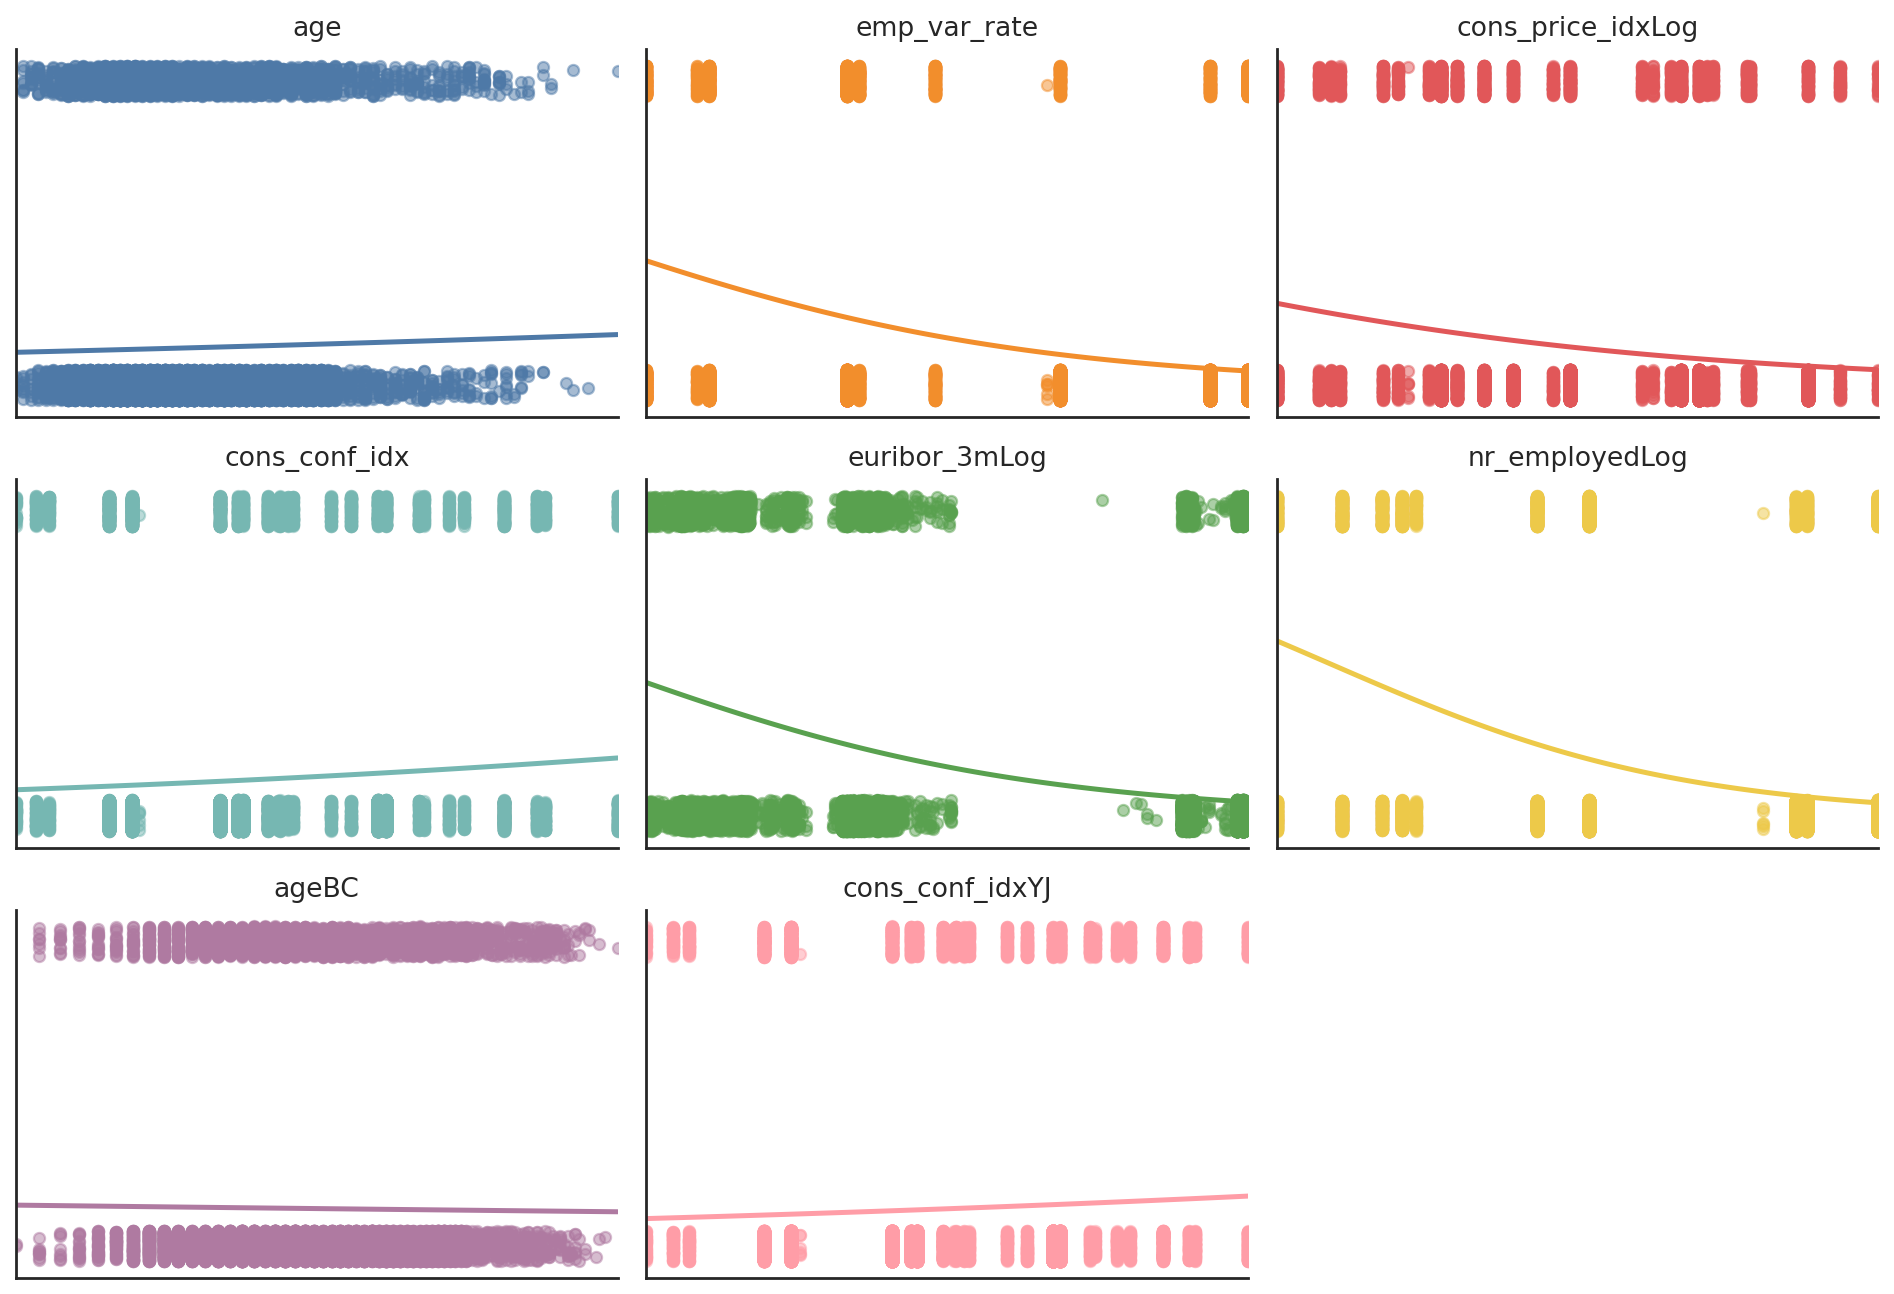

In [ ]:
from tutorial2 import regplots
fig, ax = regplots(train[logit_con  + ['ageBC','cons_conf_idxYJ']], train['y'])
plt.show()

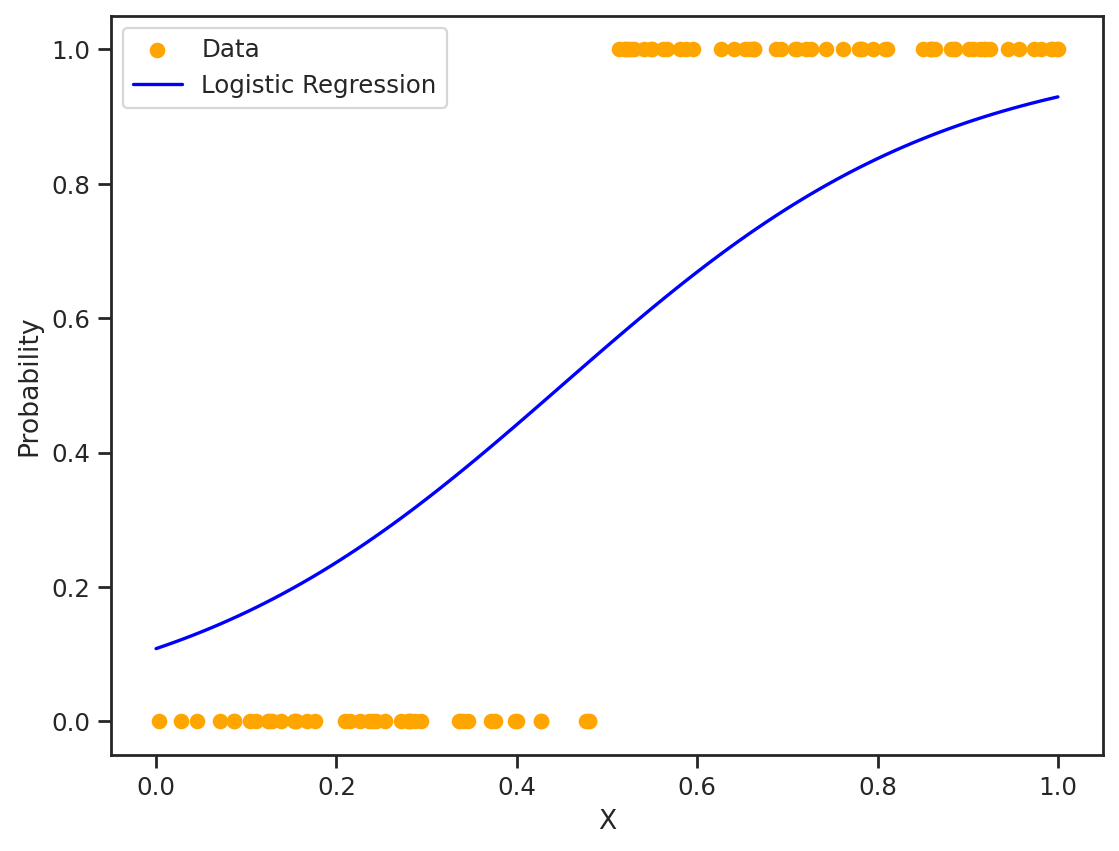

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Assume X and y are your data
X = np.random.rand(100, 1)
y = (X[:, 0] > 0.5).astype(np.int)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate evenly spaced values over the range of X
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Predict the probabilities over the range of X_test
y_prob = model.predict_proba(X_test)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='orange', label='Data')
plt.plot(X_test, y_prob[:, 1], 'b-', label='Logistic Regression')
plt.xlabel('X')
plt.ylabel('Probability')
plt.legend()
plt.show()


# Logistic regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# logit_con = ['age','emp_var_rateYJ', 'cons_price_idxLog','cons_conf_idxYJ','euribor_3m','nr_employedYJ']
# logit_cat = job_OneHot + day_of_week_OneHot + ['maritalGLMM','educationCatBoost','monthGLMM']


logit_con = ['age','emp_var_rate', 'cons_price_idxLog','cons_conf_idx','euribor_3mLog','nr_employedLog']
logit_cat = ['jobGLMM','maritalGLMM','educationGLMM','day_of_weekGLMM', 'monthGLMM']


logit_predictors = binary_dummies + ['previous', 'pdays_999'] + logit_cat + logit_con

logit_X_train = train[logit_predictors]
logit_X_valid = valid[logit_predictors]
logit_X_test = test[logit_predictors]


# Standardization

scaler = StandardScaler()
logit_X_train_s = scaler.fit_transform(logit_X_train)
logit_X_valid_s = scaler.transform(logit_X_valid)
logit_X_test_s = scaler.transform(logit_X_test)  



# Normalization
scaler = MinMaxScaler()
logit_X_train_n = scaler.fit_transform(logit_X_train)
logit_X_valid_n = scaler.transform(logit_X_valid)
logit_X_test_n = scaler.transform(logit_X_test)  


y_train = train['y']
y_valid = valid['y']
y_test = test['y']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV()
logit.fit(logit_X_train, y_train)

LogisticRegressionCV()

In [ ]:
from sklearn.linear_model import LogisticRegression

logit_s = LogisticRegressionCV()
logit_s.fit(logit_X_train_s, y_train)

LogisticRegressionCV()

In [ ]:
from sklearn.linear_model import LogisticRegression

logit_n = LogisticRegressionCV()
logit_n.fit(logit_X_train_n, y_train)

LogisticRegressionCV()

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss,f1_score

columns=['Loss', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score', 'Error Rate']
rows=['Logistic','Logistic - Standarized','Logistic - Normalized']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit,logit_s,logit_n]

y_valid = np.ravel(y_valid)
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):    
    
    if i == 0:
        y_prob[:,i] = method.predict_proba(logit_X_valid)[:,1]
    elif i == 1:
        y_prob[:,i] = method.predict_proba(logit_X_valid_s)[:,1]
    elif i == 2:
        y_prob[:,i] = method.predict_proba(logit_X_valid_n)[:,1]

    tau = 1/20       
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  19*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 


    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*9)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(y_valid))
    results.iloc[i,2] =  tp/(tp+fn)
    results.iloc[i,3] =  tn/(tn+fp)
    results.iloc[i,4] =  precision_score(y_valid, y_pred)
    results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,6] =  log_loss(y_valid, y_prob[:,i])
    results.iloc[i,7] =  f1_score(y_valid, y_pred)  #f1-score
    results.iloc[i,8] =   1 - accuracy_score(y_valid, y_pred) # error rate



results.sort_values(by=['AUC','F1-score'], ascending = [0,0]).round(5)

Loss       SE  Sensitivity  Specificity  Precision  \
Logistic                0.86388  0.03411      0.86047      0.38954    0.16657   
Logistic - Normalized   0.86735  0.03278      0.87132      0.35634    0.16103   
Logistic - Standarized  0.84521  0.02279      0.93953      0.19785    0.14242   

                            AUC  Cross-entropy  F1-score  Error Rate  
Logistic                0.77132        0.30521   0.27910     0.55198  
Logistic - Normalized   0.77094        0.30400   0.27183     0.57971  
Logistic - Standarized  0.76531        0.30697   0.24735     0.71005

(True Negatives):  4484
(False Positives):  65
(False Negatives):  505
(True Positives):  140
Total Actuall Subscribed:  645
(True Negatives):  9608
(False Positives):  172
(False Negatives):  1058
(True Positives):  292
Total Actuall Subscribed:  1350
(True Negatives):  3732
(False Positives):  6048
(False Negatives):  150
(True Positives):  1200
Total Actuall Subscribed:  1350


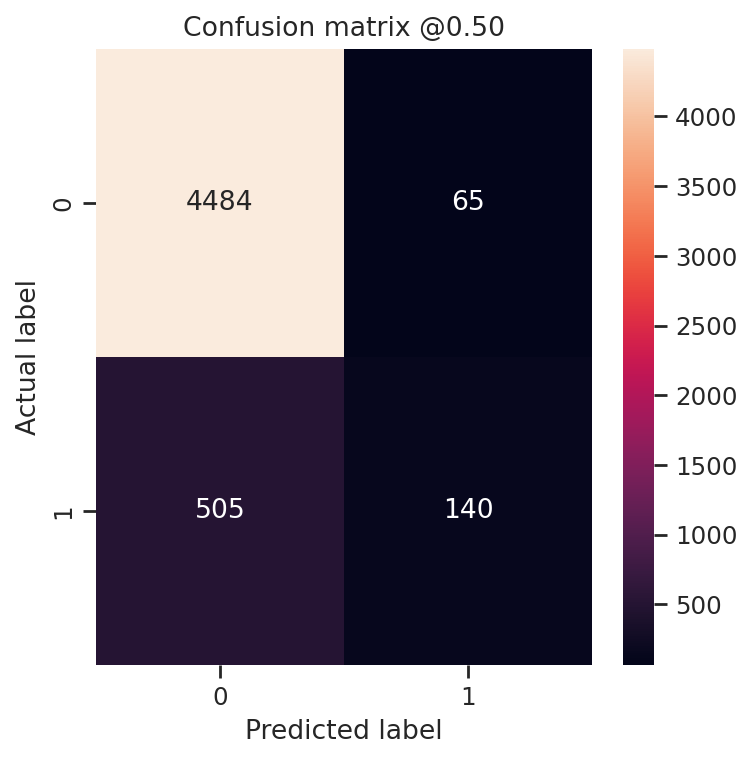

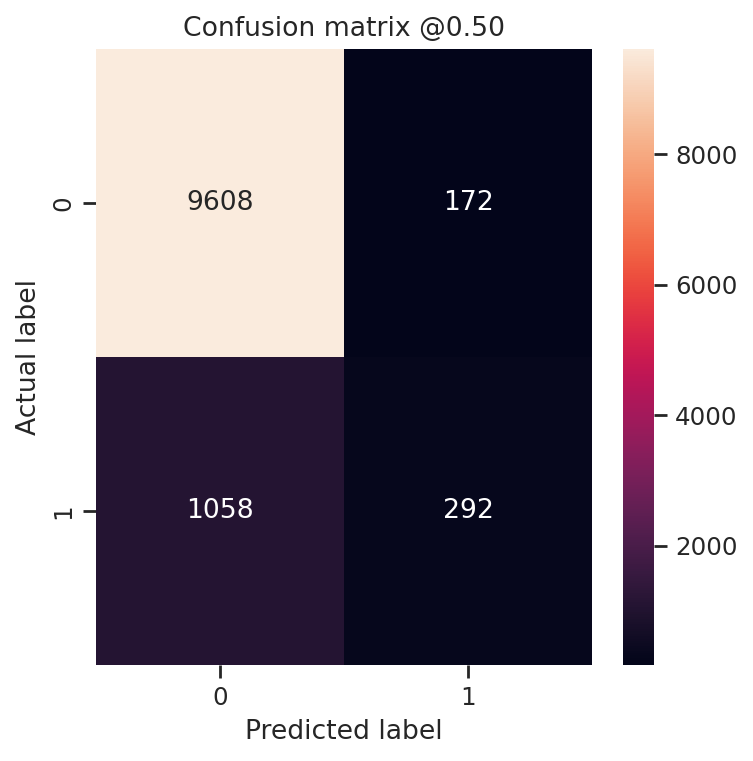

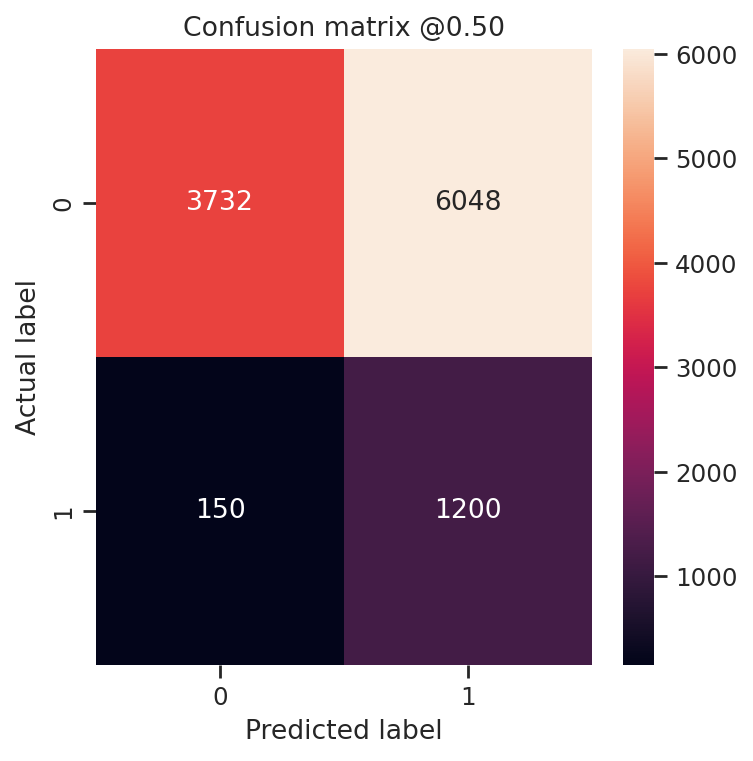

In [ ]:
# Non standarised
tau = 1/20

method = logit


y_prob = method.predict_proba(logit_X_valid)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# Gradient Boosting - test - no threshhold
y_prob = method.predict_proba(logit_X_test)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)



y_prob = method.predict_proba(logit_X_test)[:,1]
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

(True Negatives):  4513
(False Positives):  36
(False Negatives):  531
(True Positives):  114
Total Actuall Subscribed:  645
(True Negatives):  9663
(False Positives):  117
(False Negatives):  1105
(True Positives):  245
Total Actuall Subscribed:  1350
(True Negatives):  1866
(False Positives):  7914
(False Negatives):  70
(True Positives):  1280
Total Actuall Subscribed:  1350


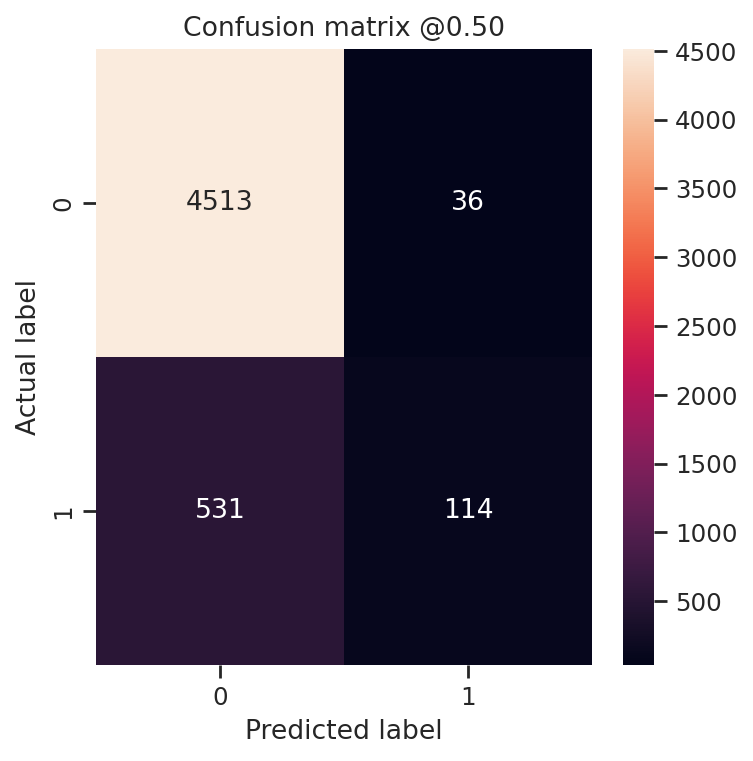

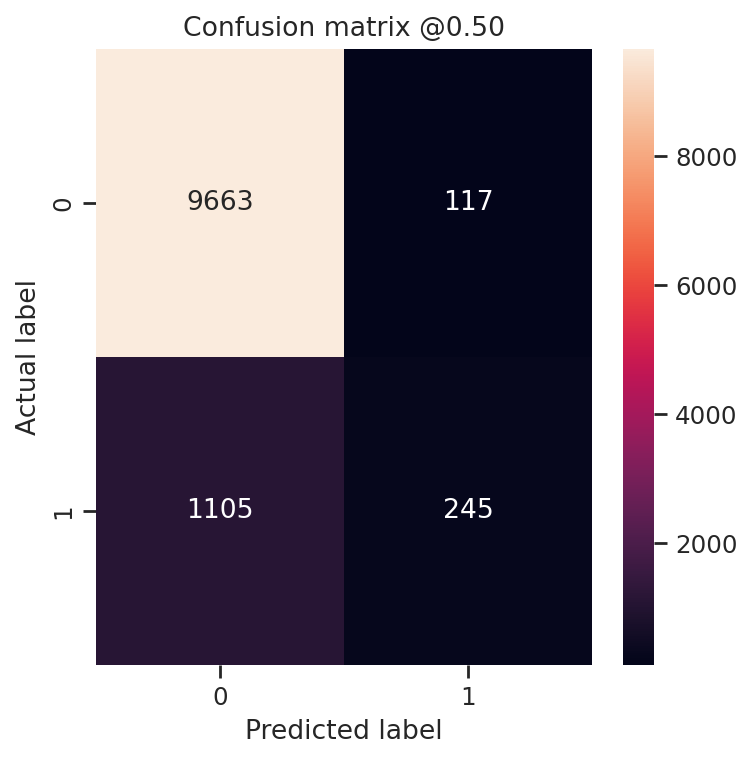

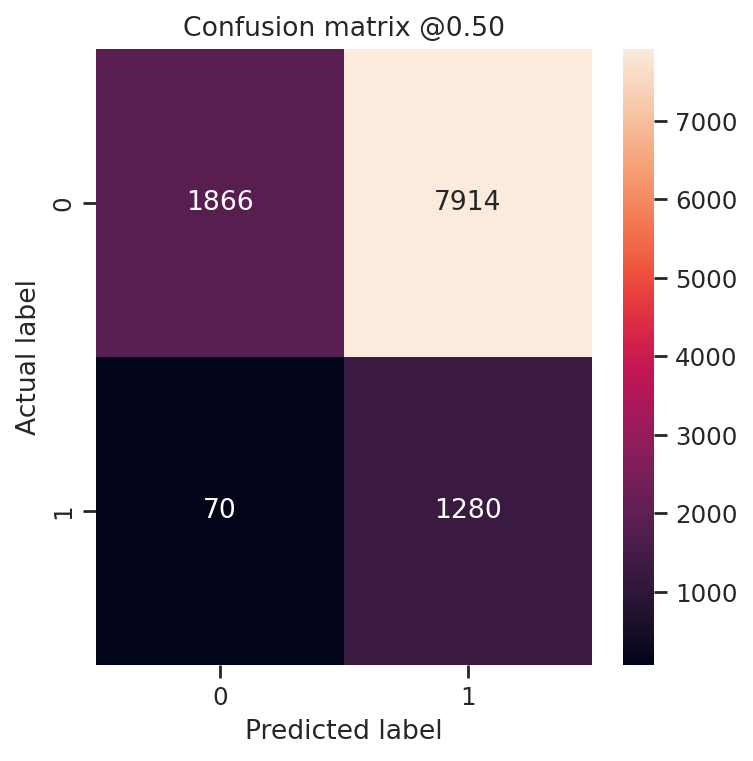

In [ ]:
# Standarised

tau = 1/20

method = logit_s


y_prob = method.predict_proba(logit_X_valid_s)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# Gradient Boosting - test - no threshhold
y_prob = method.predict_proba(logit_X_test_s)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)



y_prob = method.predict_proba(logit_X_test_s)[:,1]
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

(True Negatives):  4487
(False Positives):  62
(False Negatives):  512
(True Positives):  133
Total Actuall Subscribed:  645
(True Negatives):  9616
(False Positives):  164
(False Negatives):  1064
(True Positives):  286
Total Actuall Subscribed:  1350
(True Negatives):  3463
(False Positives):  6317
(False Negatives):  130
(True Positives):  1220
Total Actuall Subscribed:  1350


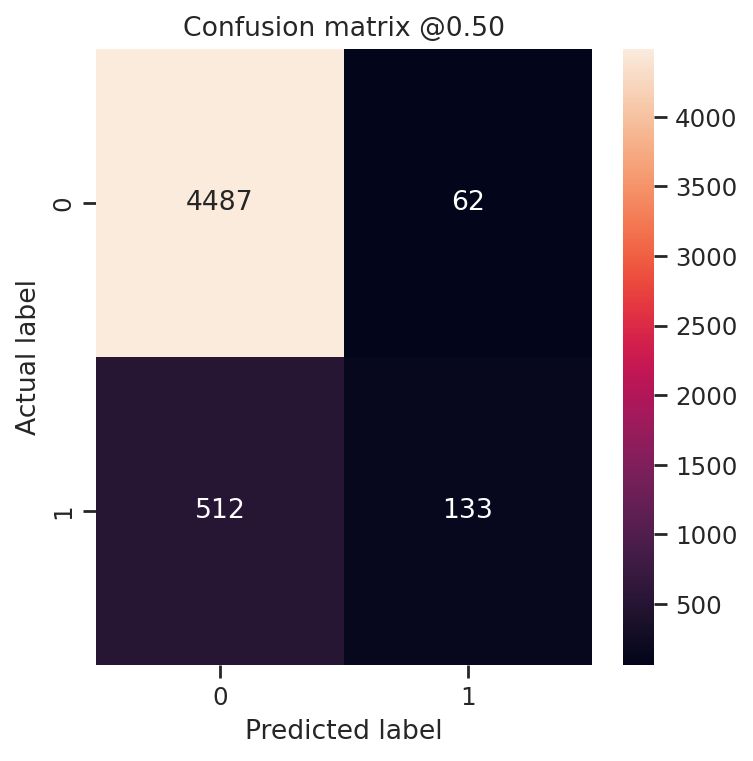

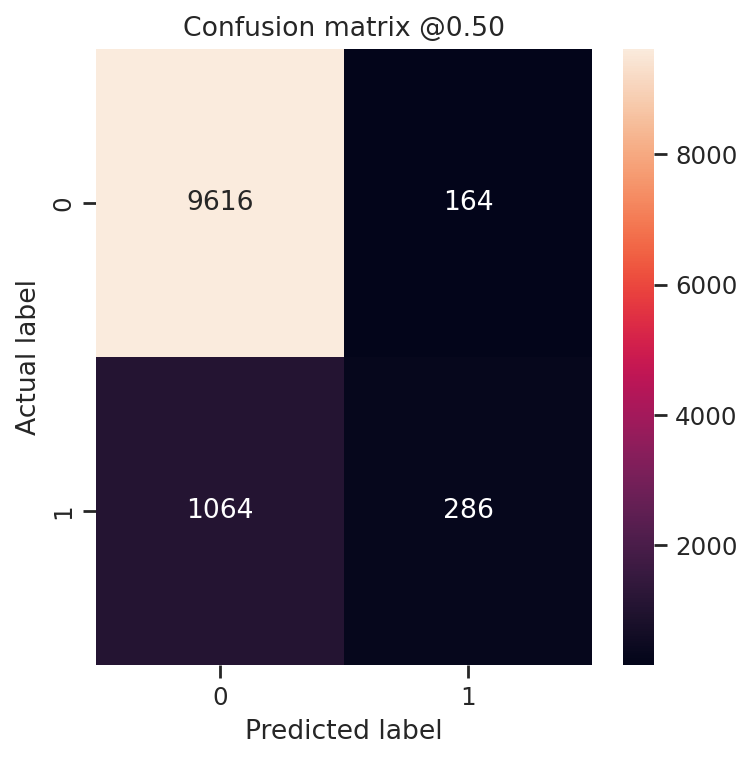

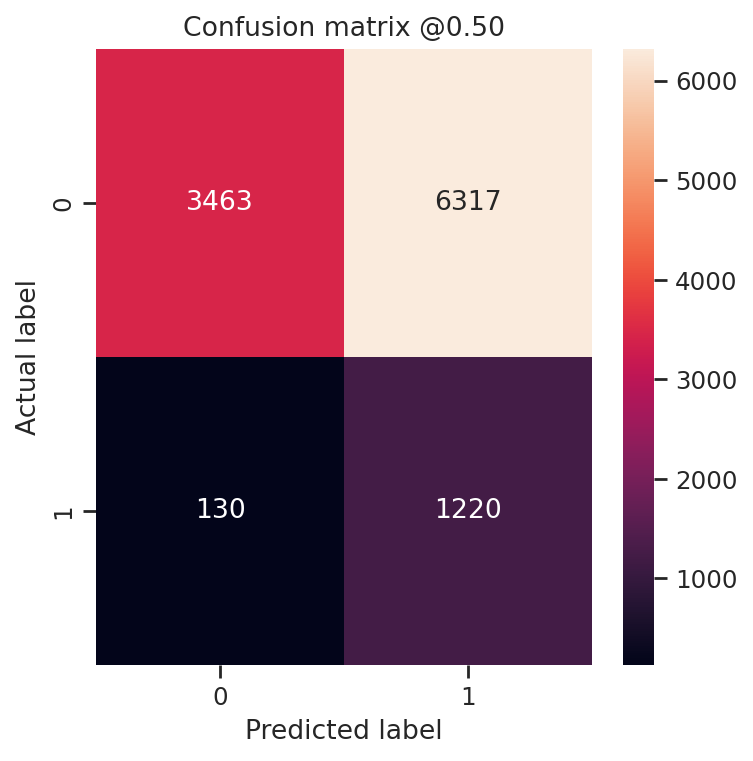

In [ ]:
# Normalised

tau = 1/20

method = logit_n


y_prob = method.predict_proba(logit_X_valid_n)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# Gradient Boosting - test - no threshhold
y_prob = method.predict_proba(logit_X_test_n)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)



y_prob = method.predict_proba(logit_X_test_n)[:,1]
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

In [ ]:
print(y_prob.shape)
print(logit_X_test_s.shape)
print(y_test.shape)

(11130,)
(11130, 22)
(11130,)


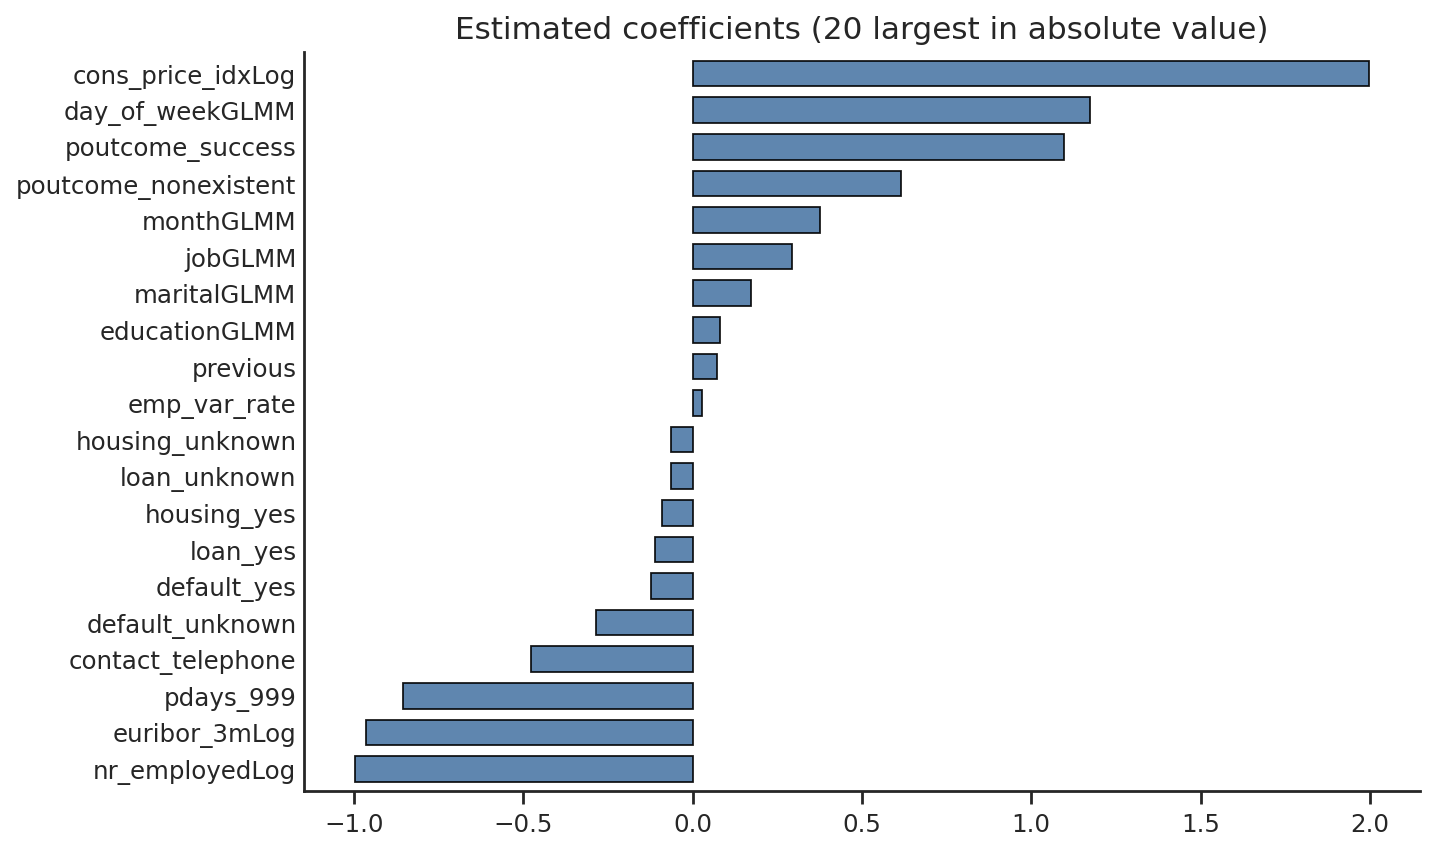

In [ ]:
# Coeffients
from tutorial2 import coefplot

coefplot(logit, logit_predictors)
plt.show()

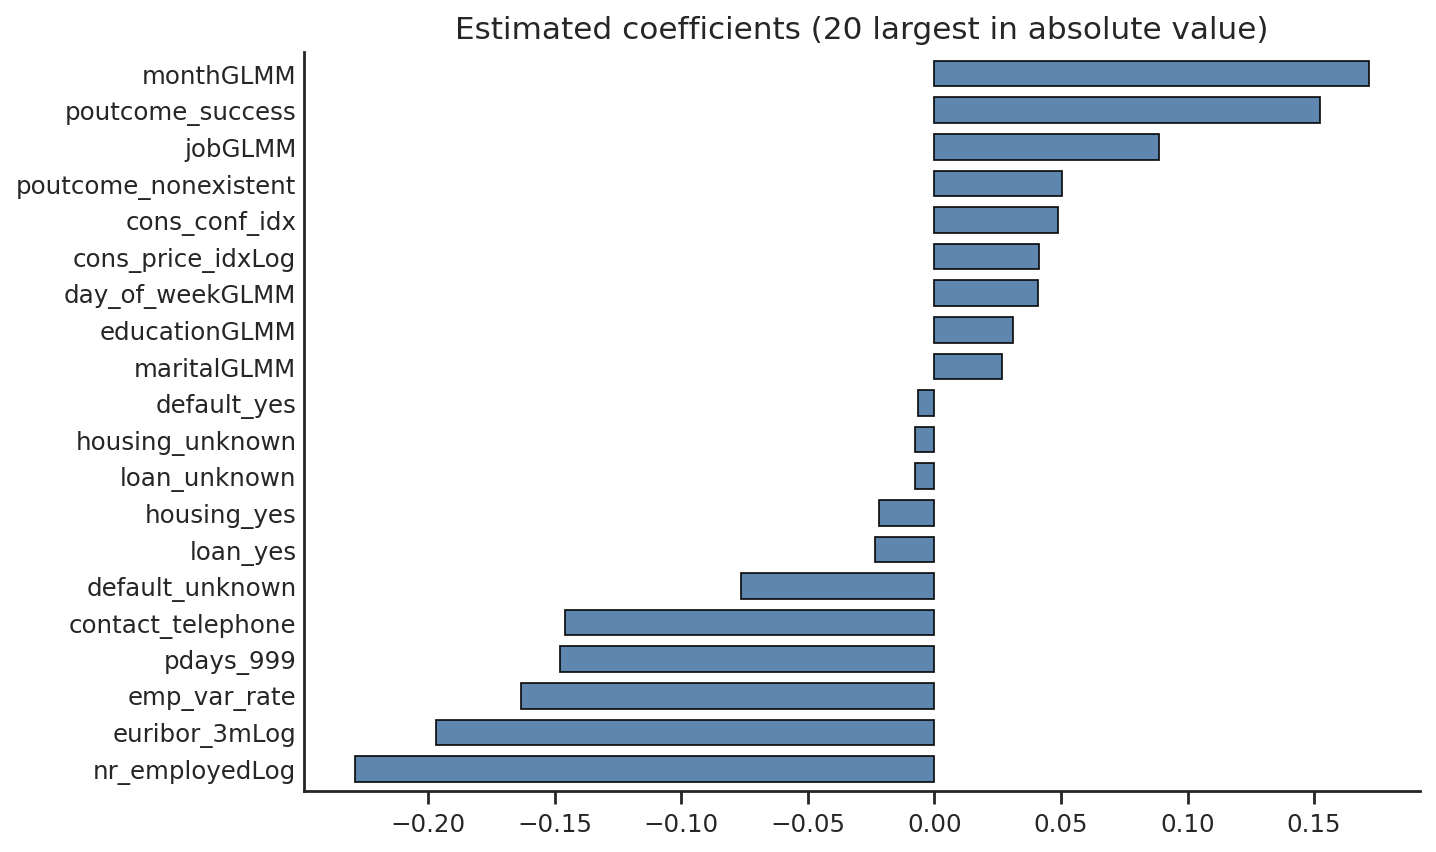

In [ ]:
from tutorial2 import coefplot
coefplot(logit_s, logit_predictors)
plt.show()

## Training

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# Select the penalties by cross-validation
logit_l1= LogisticRegressionCV(Cs = 50, penalty='l1', solver='liblinear', scoring='neg_log_loss')
logit_l1.fit(logit_X_train_s, y_train)

logit_l2= LogisticRegressionCV(Cs = 50, penalty='l2', scoring='neg_log_loss')
logit_l2.fit(logit_X_train_s, y_train)

LogisticRegressionCV(Cs=50, scoring='neg_log_loss')

In [ ]:
logit_l2_f1= LogisticRegressionCV(Cs = 50, penalty='l2', scoring='f1')
logit_l2_f1.fit(logit_X_train_s, y_train)


logit_l2_auc= LogisticRegressionCV(Cs = 50, penalty='l2', scoring='roc_auc')
logit_l2_auc.fit(logit_X_train_s, y_train)

LogisticRegressionCV(Cs=50, scoring='roc_auc')

In [ ]:
logit_f1_nt= LogisticRegressionCV(Cs = 50, solver='newton-cg', scoring='f1')
logit_f1_nt.fit(logit_X_train, y_train)

logit_nt= LogisticRegressionCV(Cs = 50, solver='newton-cg', scoring='neg_log_loss')
logit_nt.fit(logit_X_train, y_train)

logit_l2_f1_nt= LogisticRegressionCV(Cs = 50, penalty='l2',solver='newton-cg', scoring='f1')
logit_l2_f1_nt.fit(logit_X_train_s, y_train)

LogisticRegressionCV(Cs=50, scoring='f1', solver='newton-cg')

In [ ]:
logit_f1_sg= LogisticRegressionCV(Cs = 50, solver='sag', scoring='f1')
logit_f1_sg.fit(logit_X_train, y_train)

logit_l1_f1_sg= LogisticRegressionCV(Cs = 50, penalty='l1',solver='saga', scoring='f1')
logit_l1_f1_sg.fit(logit_X_train_s, y_train)

LogisticRegressionCV(Cs=50, penalty='l1', scoring='f1', solver='saga')

## Performance Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score,accuracy_score
from sklearn.metrics import precision_score, log_loss,f1_score

columns=['Loss', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score','Error Rate']
rows=['Logistic', 'Logistic - Normalized', 'Logistic - Standarized',
      'Logistic L1', 'Logistic L2', 'Logistic L2 - F1', 'Logistic L2 - AUC',
      'Logistic Newton - F1', 'Logistic Newton', 'Logistic Newton L2 - F1',
      'Logistic SAG - F1', 'Logistic SAGA L1 - F1'
      ]
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, logit_n, logit_s, 
         logit_l1, logit_l2, logit_l2_f1, logit_l2_auc,
         logit_f1_nt, logit_nt, logit_l2_f1_nt,
         logit_f1_sg, logit_l1_f1_sg

         ]

y_valid = np.ravel(y_valid)
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):    
    
    if (i == 0 or i == 7 or i == 8 or i== 10):
        y_prob[:,i] = method.predict_proba(logit_X_valid)[:,1]
    elif i == 1:
        y_prob[:,i] = method.predict_proba(logit_X_valid_n)[:,1]
    else:
        y_prob[:,i] = method.predict_proba(logit_X_valid_s)[:,1]

    tau = 1/20       
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  19*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    
    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*9)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(y_valid))
    results.iloc[i,2] =  tp/(tp+fn)
    results.iloc[i,3] =  tn/(tn+fp)
    results.iloc[i,4] =  precision_score(y_valid, y_pred)
    results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,6] =  log_loss(y_valid, y_prob[:,i])
    results.iloc[i,7] =  f1_score(y_valid, y_pred)  #f1-score
    results.iloc[i,8] =   1 - accuracy_score(y_valid, y_pred) # error rate


results.sort_values(by=['Loss'], ascending = [1]).round(5)

Loss       SE  Sensitivity  Specificity  \
Logistic L2              0.80689  0.02857      0.90388      0.33766   
Logistic L1              0.81151  0.02878      0.90233      0.33656   
Logistic Newton          0.81151  0.02878      0.90233      0.33656   
Logistic L2 - F1         0.81171  0.02878      0.90233      0.33634   
Logistic Newton - F1     0.81171  0.02878      0.90233      0.33634   
Logistic Newton L2 - F1  0.81171  0.02878      0.90233      0.33634   
Logistic SAGA L1 - F1    0.81171  0.02878      0.90233      0.33634   
Logistic - Standarized   0.84521  0.02279      0.93953      0.19785   
Logistic SAG - F1        0.86157  0.03412      0.86047      0.39217   
Logistic                 0.86388  0.03411      0.86047      0.38954   
Logistic - Normalized    0.86735  0.03278      0.87132      0.35634   
Logistic L2 - AUC        0.86773  0.03219      0.87597      0.34337   

                         Precision      AUC  Cross-entropy  F1-score  \
Logistic L2                0.16212  0.77934        0.30046   0.27494   
Logistic L1                0.16167  0.77975        0.30029   0.27420   
Logistic Newton            0.16167  0.77956        0.30037   0.27420   
Logistic L2 - F1           0.16162  0.77976        0.30029   0.27414   
Logistic Newton - F1       0.16162  0.77972        0.30030   0.27414   
Logistic Newton L2 - F1    0.16162  0.77975        0.30028   0.27414   
Logistic SAGA L1 - F1      0.16162  0.77972        0.30031   0.27414   
Logistic - Standarized     0.14242  0.76531        0.30697   0.24735   
Logistic SAG - F1          0.16717  0.77122        0.30528   0.27995   
Logistic                   0.16657  0.77132        0.30521   0.27910   
Logistic - Normalized      0.16103  0.77094        0.30400   0.27183   
Logistic L2 - AUC          0.15907  0.77610        0.30173   0.26924   

                         Error Rate  
Logistic L2                 0.59203  
Logistic L1                 0.59318  
Logistic Newton             0.59318  
Logistic L2 - F1            0.59338  
Logistic Newton - F1        0.59338  
Logistic Newton L2 - F1     0.59338  
Logistic SAGA L1 - F1       0.59338  
Logistic - Standarized      0.71005  
Logistic SAG - F1           0.54967  
Logistic                    0.55198  
Logistic - Normalized       0.57971  
Logistic L2 - AUC           0.59049

In [ ]:
results.sort_values(by=['AUC'], ascending = [0]).round(5)

Loss       SE  Sensitivity  Specificity  \
Logistic L2 - F1         0.81171  0.02878      0.90233      0.33634   
Logistic Newton L2 - F1  0.81171  0.02878      0.90233      0.33634   
Logistic L1              0.81151  0.02878      0.90233      0.33656   
Logistic Newton - F1     0.81171  0.02878      0.90233      0.33634   
Logistic SAGA L1 - F1    0.81171  0.02878      0.90233      0.33634   
Logistic Newton          0.81151  0.02878      0.90233      0.33656   
Logistic L2              0.80689  0.02857      0.90388      0.33766   
Logistic L2 - AUC        0.86773  0.03219      0.87597      0.34337   
Logistic                 0.86388  0.03411      0.86047      0.38954   
Logistic SAG - F1        0.86157  0.03412      0.86047      0.39217   
Logistic - Normalized    0.86735  0.03278      0.87132      0.35634   
Logistic - Standarized   0.84521  0.02279      0.93953      0.19785   

                         Precision      AUC  Cross-entropy  F1-score  \
Logistic L2 - F1           0.16162  0.77976        0.30029   0.27414   
Logistic Newton L2 - F1    0.16162  0.77975        0.30028   0.27414   
Logistic L1                0.16167  0.77975        0.30029   0.27420   
Logistic Newton - F1       0.16162  0.77972        0.30030   0.27414   
Logistic SAGA L1 - F1      0.16162  0.77972        0.30031   0.27414   
Logistic Newton            0.16167  0.77956        0.30037   0.27420   
Logistic L2                0.16212  0.77934        0.30046   0.27494   
Logistic L2 - AUC          0.15907  0.77610        0.30173   0.26924   
Logistic                   0.16657  0.77132        0.30521   0.27910   
Logistic SAG - F1          0.16717  0.77122        0.30528   0.27995   
Logistic - Normalized      0.16103  0.77094        0.30400   0.27183   
Logistic - Standarized     0.14242  0.76531        0.30697   0.24735   

                         Error Rate  
Logistic L2 - F1            0.59338  
Logistic Newton L2 - F1     0.59338  
Logistic L1                 0.59318  
Logistic Newton - F1        0.59338  
Logistic SAGA L1 - F1       0.59338  
Logistic Newton             0.59318  
Logistic L2                 0.59203  
Logistic L2 - AUC           0.59049  
Logistic                    0.55198  
Logistic SAG - F1           0.54967  
Logistic - Normalized       0.57971  
Logistic - Standarized      0.71005

In [ ]:
results.sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(5)

Loss       SE  Sensitivity  Specificity  \
Logistic SAG - F1        0.86157  0.03412      0.86047      0.39217   
Logistic                 0.86388  0.03411      0.86047      0.38954   
Logistic L2              0.80689  0.02857      0.90388      0.33766   
Logistic L1              0.81151  0.02878      0.90233      0.33656   
Logistic Newton          0.81151  0.02878      0.90233      0.33656   
Logistic L2 - F1         0.81171  0.02878      0.90233      0.33634   
Logistic Newton L2 - F1  0.81171  0.02878      0.90233      0.33634   
Logistic Newton - F1     0.81171  0.02878      0.90233      0.33634   
Logistic SAGA L1 - F1    0.81171  0.02878      0.90233      0.33634   
Logistic - Normalized    0.86735  0.03278      0.87132      0.35634   
Logistic L2 - AUC        0.86773  0.03219      0.87597      0.34337   
Logistic - Standarized   0.84521  0.02279      0.93953      0.19785   

                         Precision      AUC  Cross-entropy  F1-score  \
Logistic SAG - F1          0.16717  0.77122        0.30528   0.27995   
Logistic                   0.16657  0.77132        0.30521   0.27910   
Logistic L2                0.16212  0.77934        0.30046   0.27494   
Logistic L1                0.16167  0.77975        0.30029   0.27420   
Logistic Newton            0.16167  0.77956        0.30037   0.27420   
Logistic L2 - F1           0.16162  0.77976        0.30029   0.27414   
Logistic Newton L2 - F1    0.16162  0.77975        0.30028   0.27414   
Logistic Newton - F1       0.16162  0.77972        0.30030   0.27414   
Logistic SAGA L1 - F1      0.16162  0.77972        0.30031   0.27414   
Logistic - Normalized      0.16103  0.77094        0.30400   0.27183   
Logistic L2 - AUC          0.15907  0.77610        0.30173   0.26924   
Logistic - Standarized     0.14242  0.76531        0.30697   0.24735   

                         Error Rate  
Logistic SAG - F1           0.54967  
Logistic                    0.55198  
Logistic L2                 0.59203  
Logistic L1                 0.59318  
Logistic Newton             0.59318  
Logistic L2 - F1            0.59338  
Logistic Newton L2 - F1     0.59338  
Logistic Newton - F1        0.59338  
Logistic SAGA L1 - F1       0.59338  
Logistic - Normalized       0.57971  
Logistic L2 - AUC           0.59049  
Logistic - Standarized      0.71005

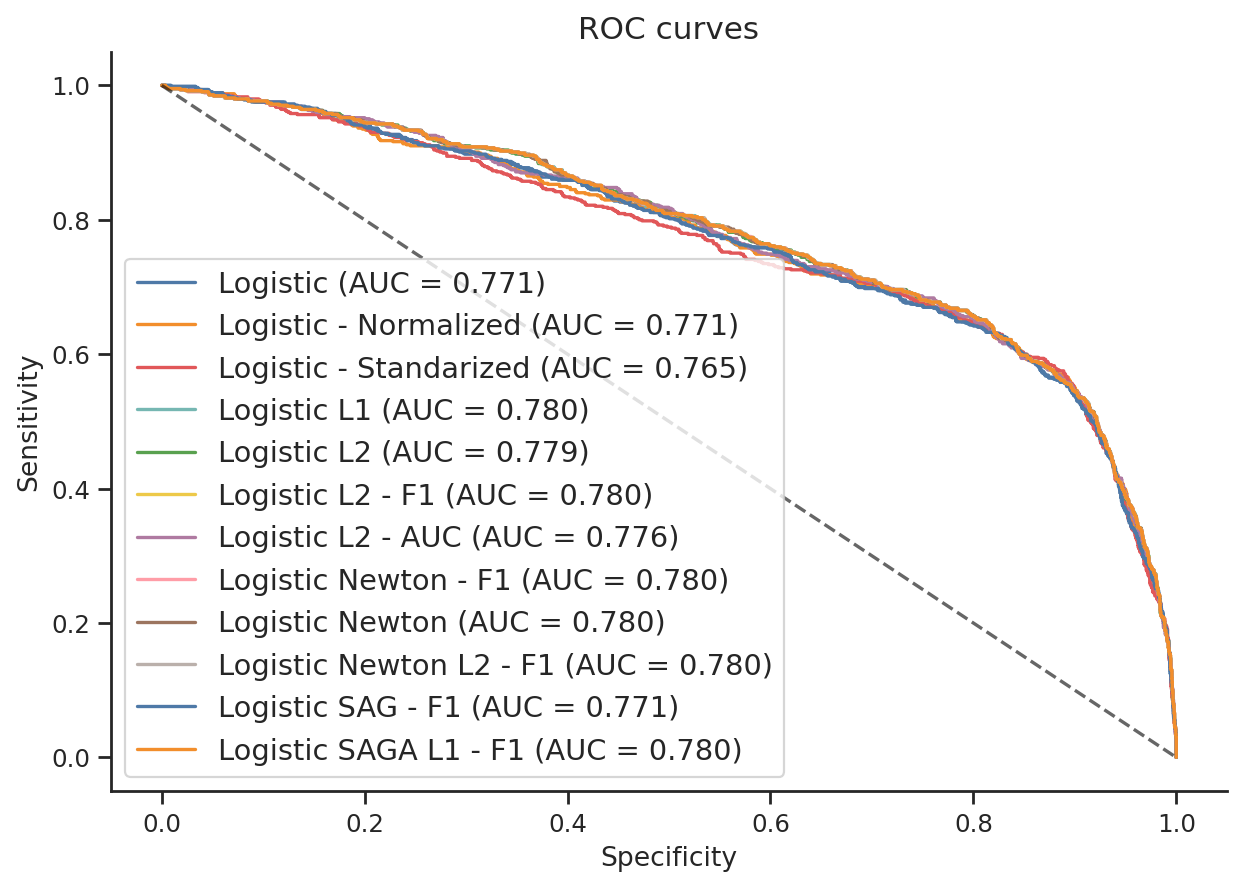

In [ ]:
from tutorial2 import rocplot
fig, ax = rocplot(y_valid, y_prob, labels=pd.Series(rows))
plt.show()

(True Negatives):  4484
(False Positives):  65
(False Negatives):  505
(True Positives):  140
Total Actuall Subscribed:  645
(True Negatives):  9613
(False Positives):  167
(False Negatives):  1059
(True Positives):  291
Total Actuall Subscribed:  1350
(True Negatives):  3755
(False Positives):  6025
(False Negatives):  151
(True Positives):  1199
Total Actuall Subscribed:  1350


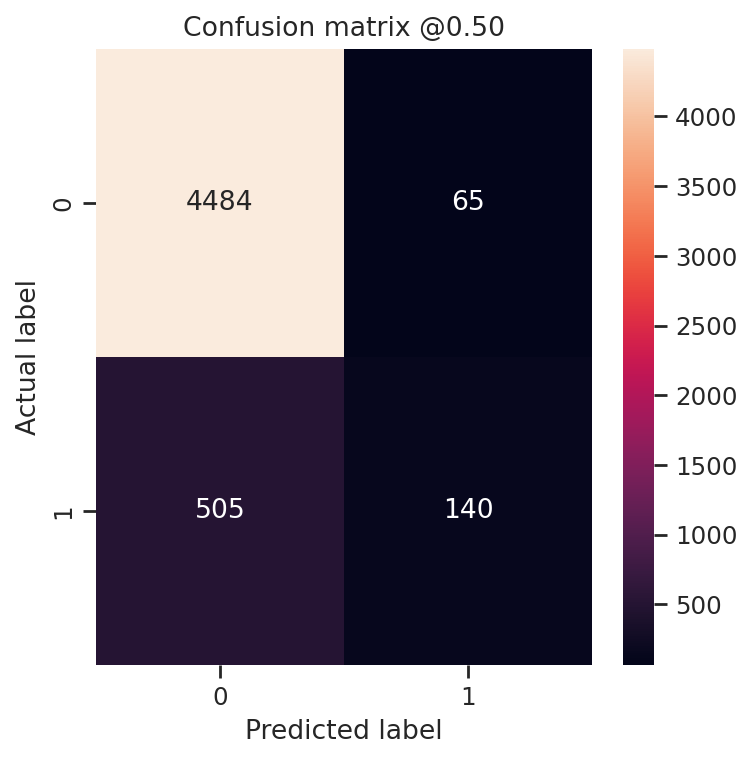

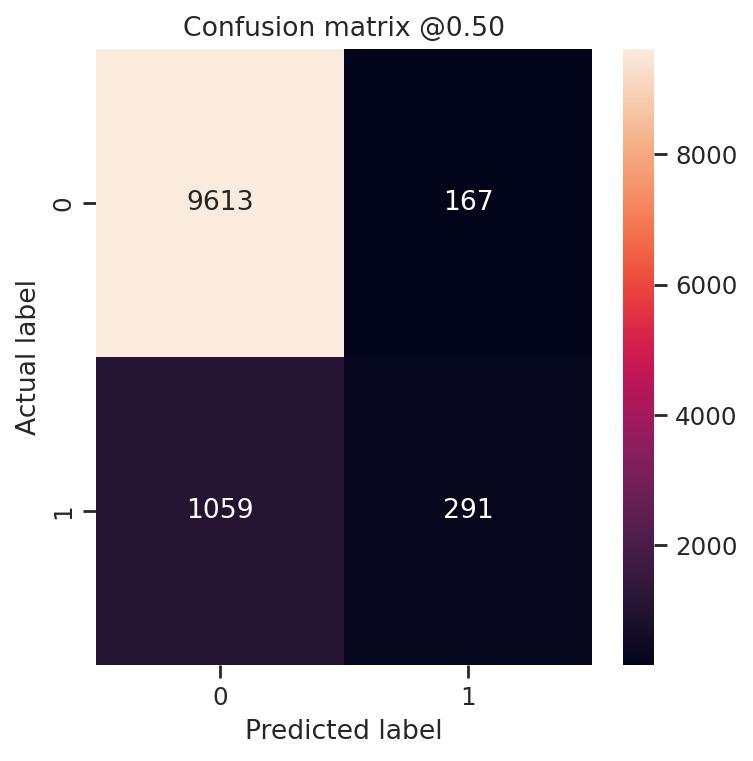

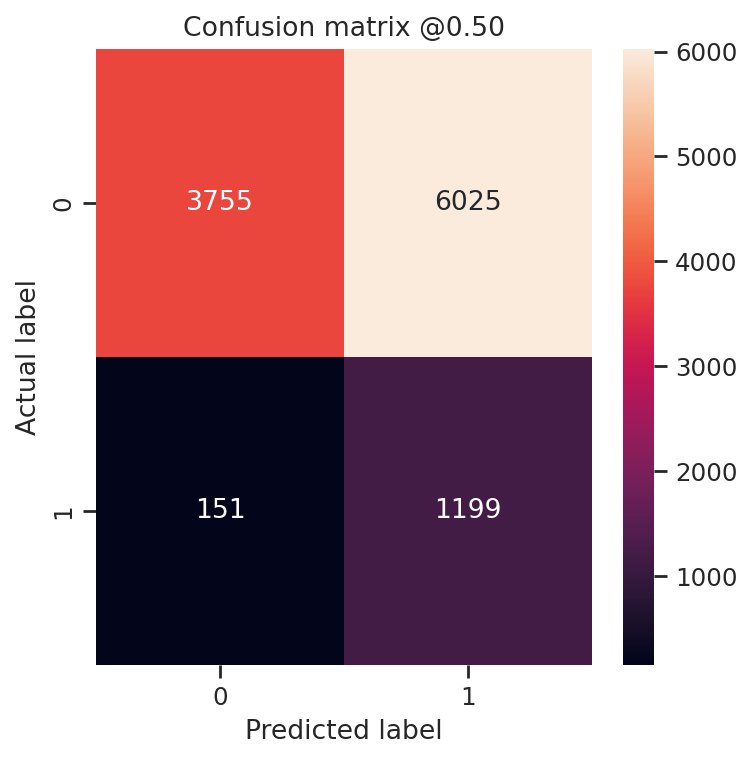

In [ ]:
# logit Sophiticate Gradient Saga tuned by f1

tau = 1/20

method = logit_f1_sg


y_prob = method.predict_proba(logit_X_valid)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# Gradient Boosting - test - no threshhold
y_prob = method.predict_proba(logit_X_test)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)



y_prob = method.predict_proba(logit_X_test)[:,1]
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

(True Negatives):  4474
(False Positives):  75
(False Negatives):  490
(True Positives):  155
Total Actuall Subscribed:  645
(True Negatives):  9584
(False Positives):  196
(False Negatives):  1028
(True Positives):  322
Total Actuall Subscribed:  1350
(True Negatives):  3223
(False Positives):  6557
(False Negatives):  124
(True Positives):  1226
Total Actuall Subscribed:  1350


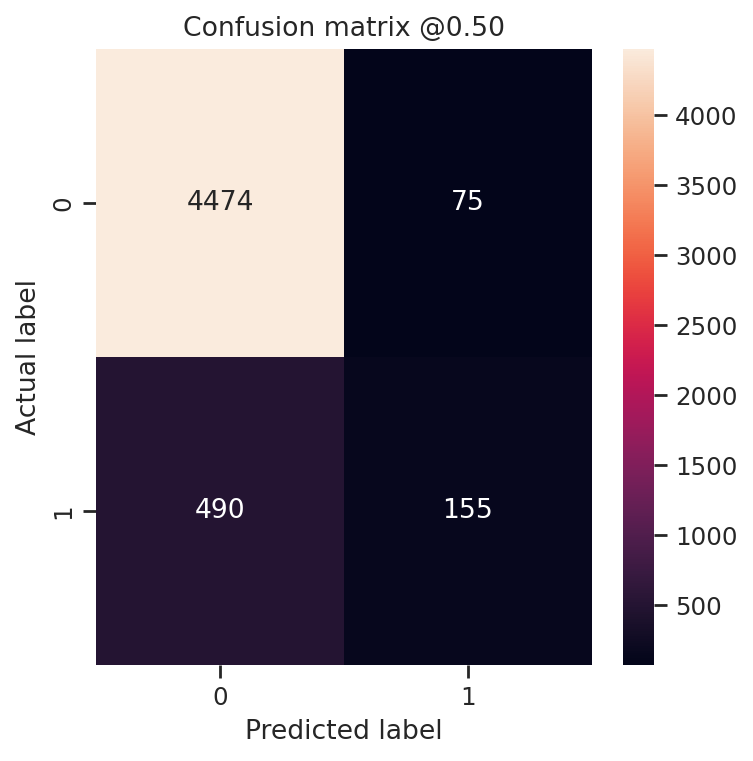

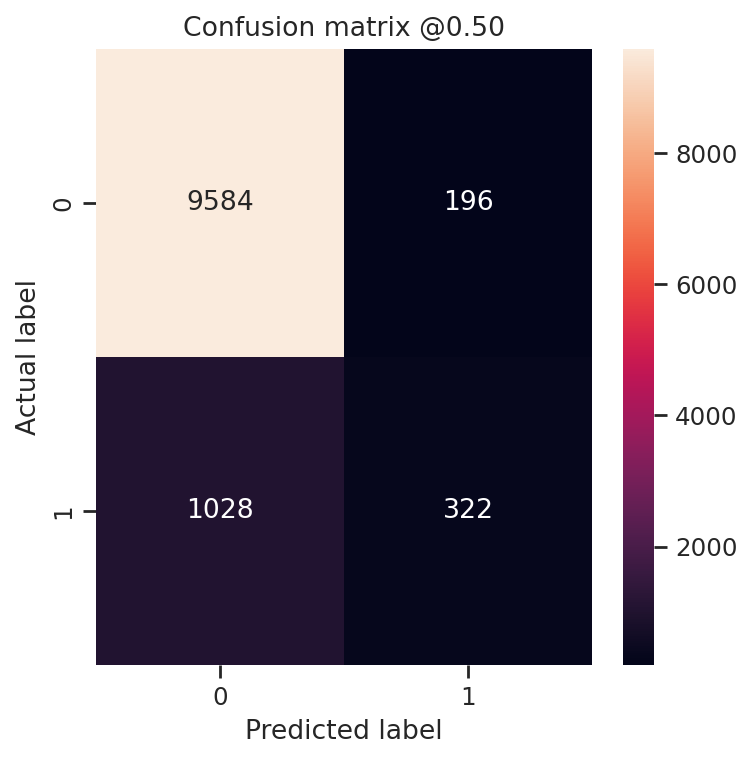

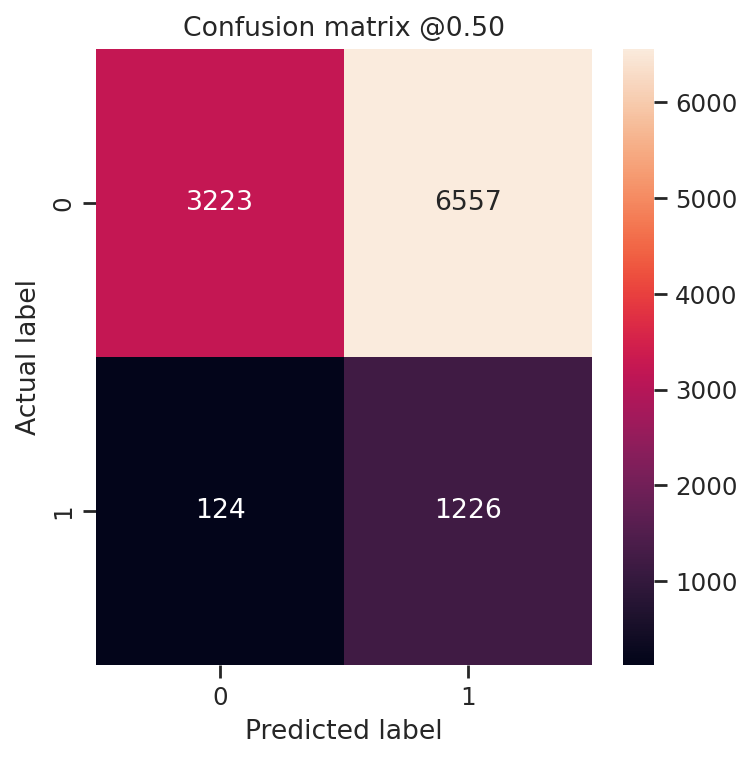

In [ ]:
# logit_l2 tuned by f1

tau = 1/20

method = logit_l2_f1


y_prob = method.predict_proba(logit_X_valid_s)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# Gradient Boosting - test - no threshhold
y_prob = method.predict_proba(logit_X_test_s)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)



y_prob = method.predict_proba(logit_X_test_s)[:,1]
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

## Best Logistic

In [ ]:
# logit_con = ['age','emp_var_rate', 'cons_price_idxLog','cons_conf_idx','euribor_3mLog','nr_employedLog']
# logit_cat = ['jobGLMM','maritalGLMM','educationGLMM','day_of_weekGLMM', 'monthGLMM']


# logit_predictors = binary_dummies + ['previous', 'pdays_999'] + logit_cat + logit_con

# logit_X_train = train[logit_predictors]
# logit_X_valid = valid[logit_predictors]
# logit_X_test = test[logit_predictors]


# # Standardization

# scaler = StandardScaler()
# logit_X_train_s = scaler.fit_transform(logit_X_train)
# logit_X_valid_s = scaler.transform(logit_X_valid)
# logit_X_test_s = scaler.transform(logit_X_test)

# logit_l2= LogisticRegressionCV(Cs = 50, penalty='l2', scoring='neg_log_loss')
# logit_l2.fit(logit_X_train_s, y_train)

(True Negatives):  4473
(False Positives):  76
(False Negatives):  491
(True Positives):  154
Total Actuall Subscribed:  645
(True Negatives):  9584
(False Positives):  196
(False Negatives):  1028
(True Positives):  322
Total Actuall Subscribed:  1350
(True Negatives):  3240
(False Positives):  6540
(False Negatives):  124
(True Positives):  1226
Total Actuall Subscribed:  1350


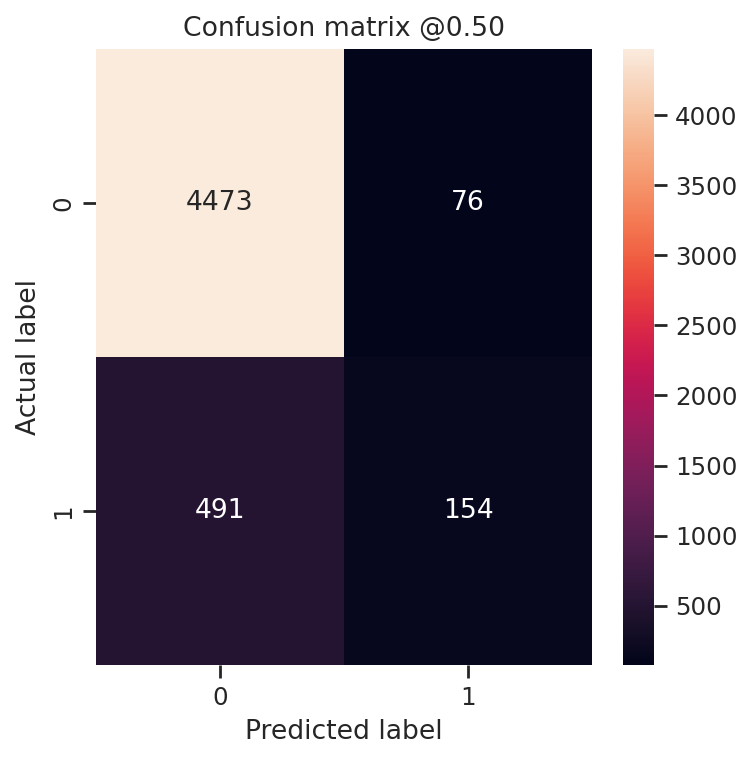

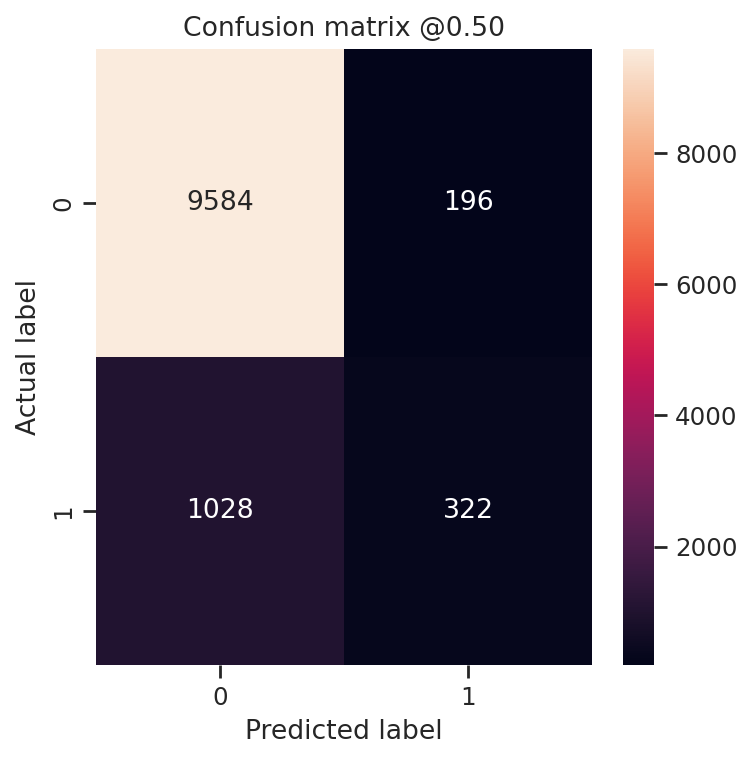

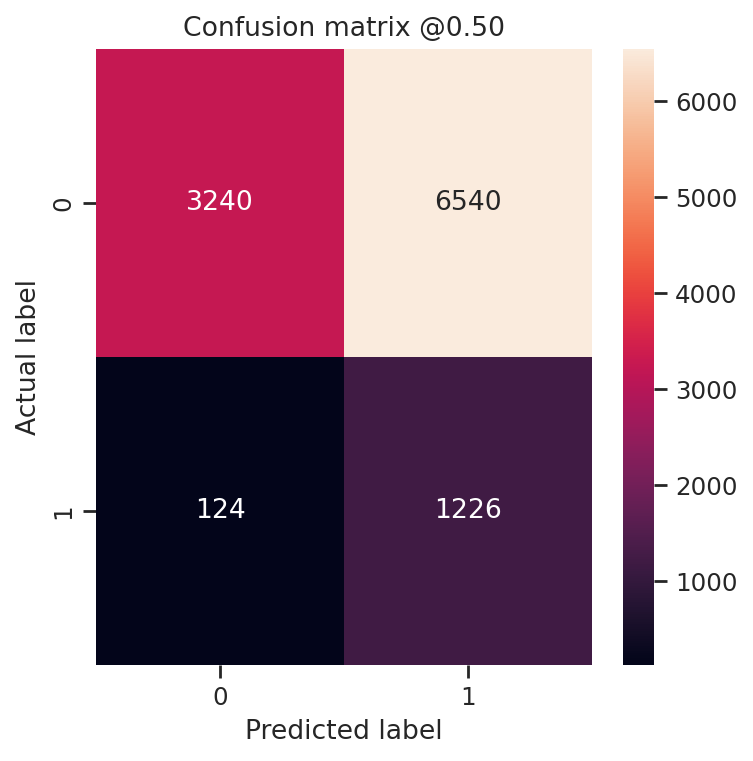

In [ ]:
# logit_l2

tau = 1/20

method = logit_l2


y_prob = method.predict_proba(logit_X_valid_s)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]


plot_cm(y_valid, y_pred)

# Gradient Boosting - test - no threshhold
y_prob = method.predict_proba(logit_X_test_s)[:, 1]
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)



y_prob = method.predict_proba(logit_X_test_s)[:,1]
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

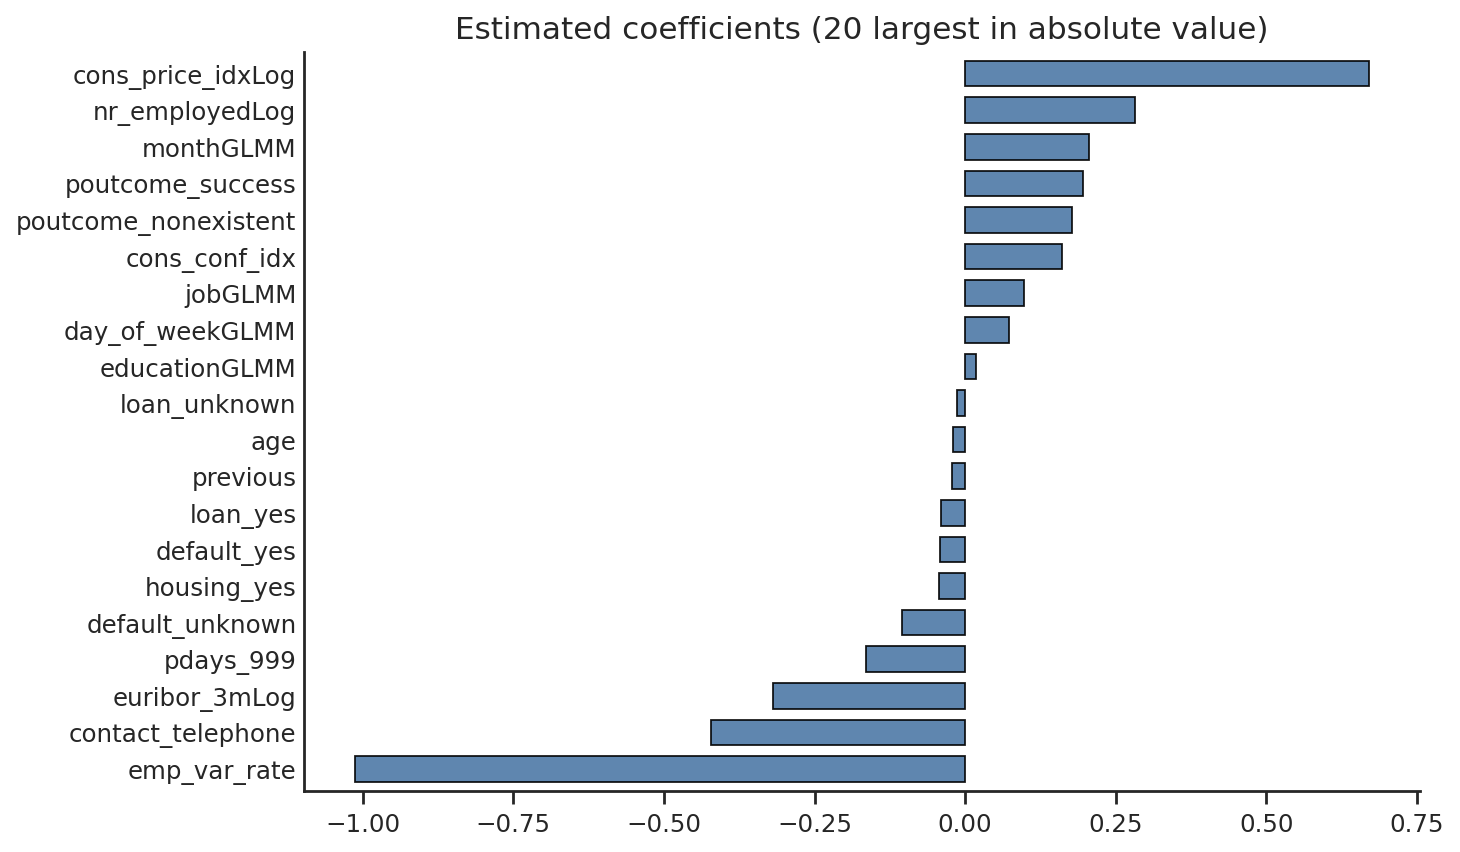

In [ ]:
from tutorial2 import coefplot

coefplot(logit_l2, logit_predictors)
plt.show()

In [ ]:
print("Coefficients:", logit_l2.coef_)
print("Intercept:", logit_l2.intercept_)
print("Best C (Inverse of regularization strength):", logit_l2_f1.C_)

Coefficients: [[-0.10447786 -0.04182817 -0.01406229 -0.04385352 -0.01406229 -0.0403384
   0.17734882  0.19495    -0.42164629 -0.02108968 -0.16507794  0.0972041
   0.01069324  0.01877056  0.07294034  0.20588059 -0.0198912  -1.01294608
   0.67098085  0.16055525 -0.31836367  0.28229264]]
Intercept: [-2.36636264]
Best C (Inverse of regularization strength): [1.20679264]


# LogisticGAM

In [ ]:
coef = logit_l2.coef_
table = pd.Series(coef.ravel(), index = logit_predictors).sort_values(ascending=True, inplace=False)
table = table.to_frame()
table

0
emp_var_rate         -1.012946
contact_telephone    -0.421646
euribor_3mLog        -0.318364
pdays_999            -0.165078
default_unknown      -0.104478
housing_yes          -0.043854
default_yes          -0.041828
loan_yes             -0.040338
previous             -0.021090
age                  -0.019891
housing_unknown      -0.014062
loan_unknown         -0.014062
maritalGLMM           0.010693
educationGLMM         0.018771
day_of_weekGLMM       0.072940
jobGLMM               0.097204
cons_conf_idx         0.160555
poutcome_nonexistent  0.177349
poutcome_success      0.194950
monthGLMM             0.205881
nr_employedLog        0.282293
cons_price_idxLog     0.670981

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pygam import LogisticGAM, s, f, l, te

gam_feature = ['emp_var_rate',
               'cons_price_idxLog',
               'euribor_3mLog',          
               'nr_employedLog',
               'monthGLMM',
               'contact_telephone']

gamX_train = train[gam_feature]
gamX_valid = valid[gam_feature]
gamX_test = test[gam_feature]
gamX_train.head()


# Standardization

scaler = StandardScaler()
gamX_train_s = scaler.fit_transform(gamX_train)
gamX_valid_s = scaler.transform(gamX_valid)
gamX_test_s = scaler.transform(gamX_test)

## GAM 1

In [ ]:
from pygam import LogisticGAM, s, f, l, te
from optuna.samplers import TPESampler

def objective(trial):

    # We use factor function for categorical variables (even if we code them into numerical)
    # We find the same lambda for all models
    lambdas = []
    for j in range(len(gam_feature)):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))
                               
    model = LogisticGAM(l(0) + l(1) + l(2) + l(3) + l(4) + f(5), lam=lambdas)
    
    model.fit(gamX_train_s, y_train)
    
    return model.statistics_['loglikelihood']

sampler = TPESampler(seed=7)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='maximize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120)

In [ ]:
lambdas1 = list(study.best_params.values())
print(lambdas1)

[0.00013762587006569465, 0.00014711170961943267, 0.0002317279043265758, 0.0019912407289039806, 0.00014370480818508548, 0.000156781618751272]


In [ ]:
lambdas1 = [0.00013762587006569465, 0.00014711170961943267, 0.0002317279043265758,
            0.0019912407289039806, 0.00014370480818508548, 0.000156781618751272]
gam1 = LogisticGAM(l(0) + l(1) + l(2) + l(3) + l(4) + f(5), lam=lambdas1)
gam1.fit(gamX_train_s, y_train)
gam1.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         7.0
Link Function:                        LogitLink Log Likelihood:                                 -6439.8022
Number of Samples:                        20775 AIC:                                            12893.6044
                                                AICc:                                           12893.6113
                                                UBRE:                                               2.6209
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1686
Feature Function                  Lam

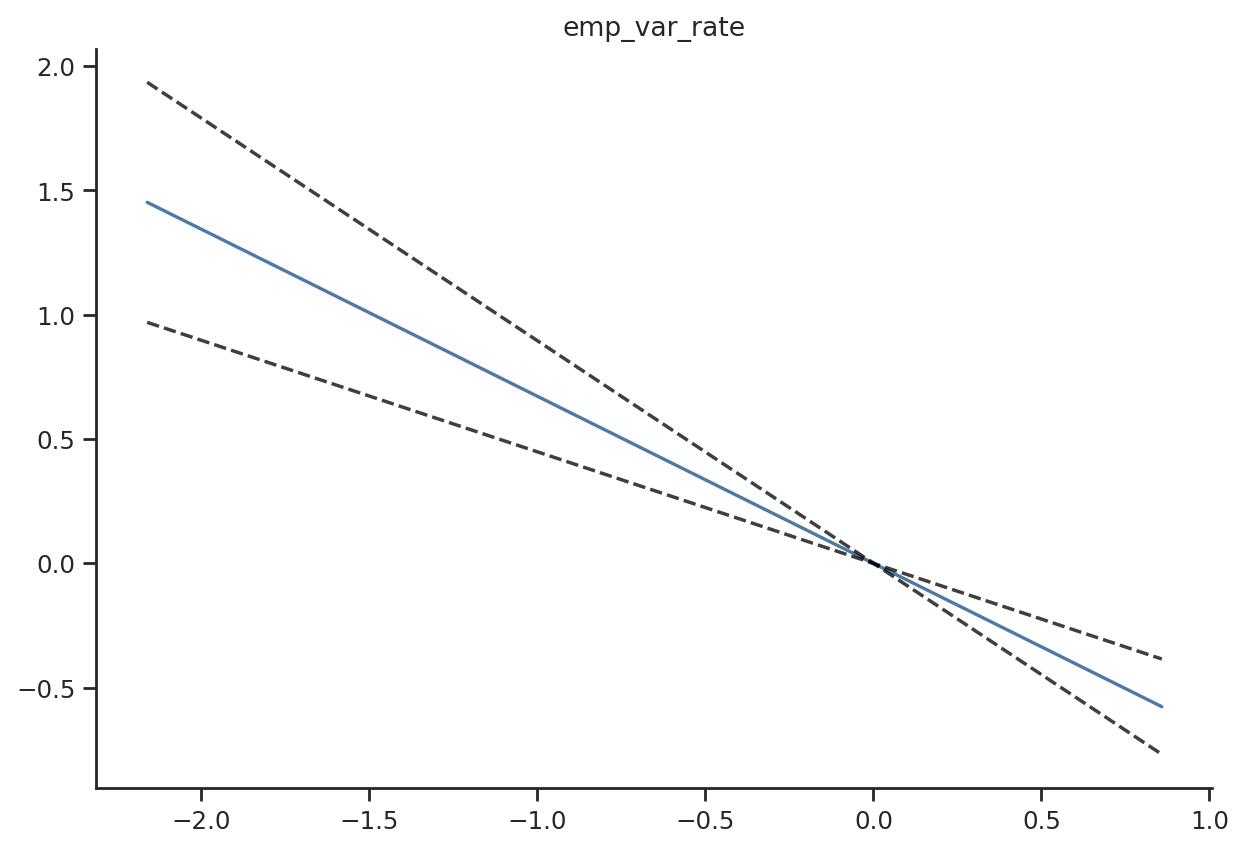

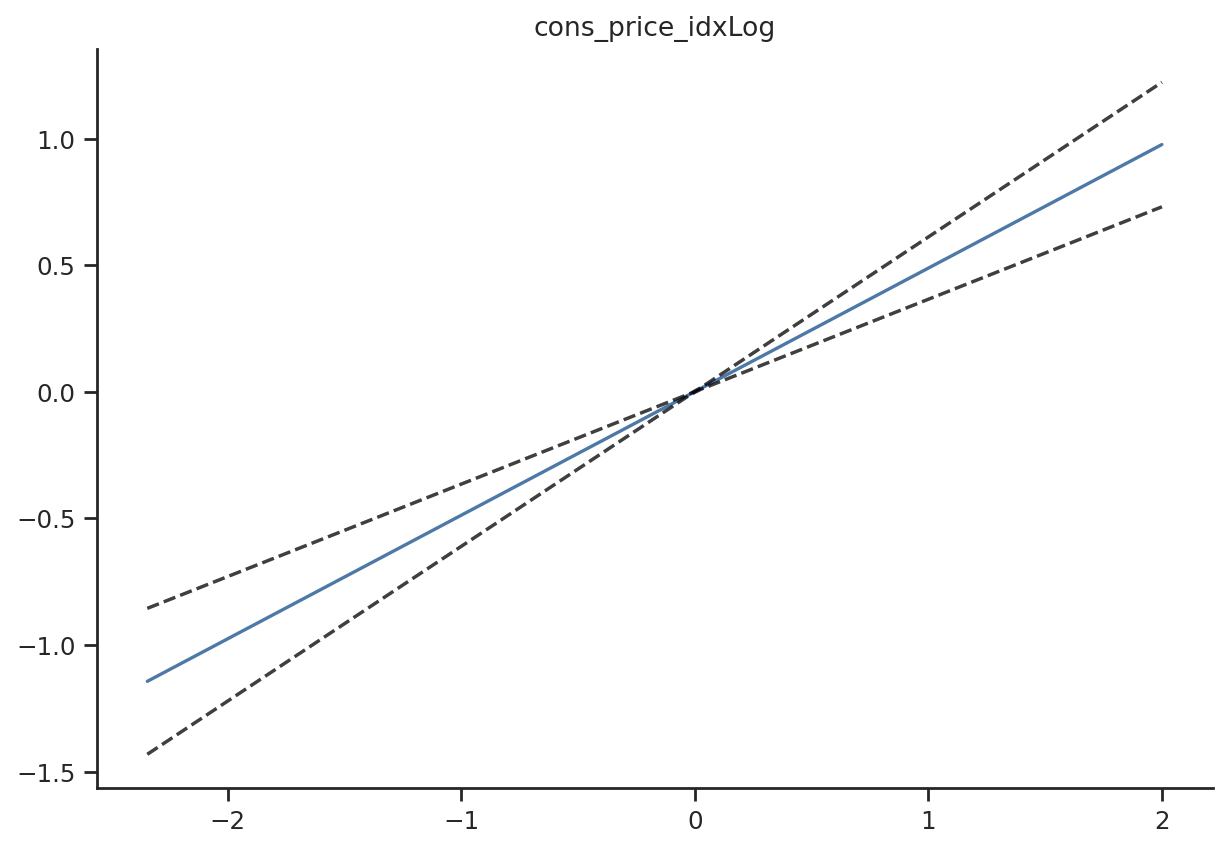

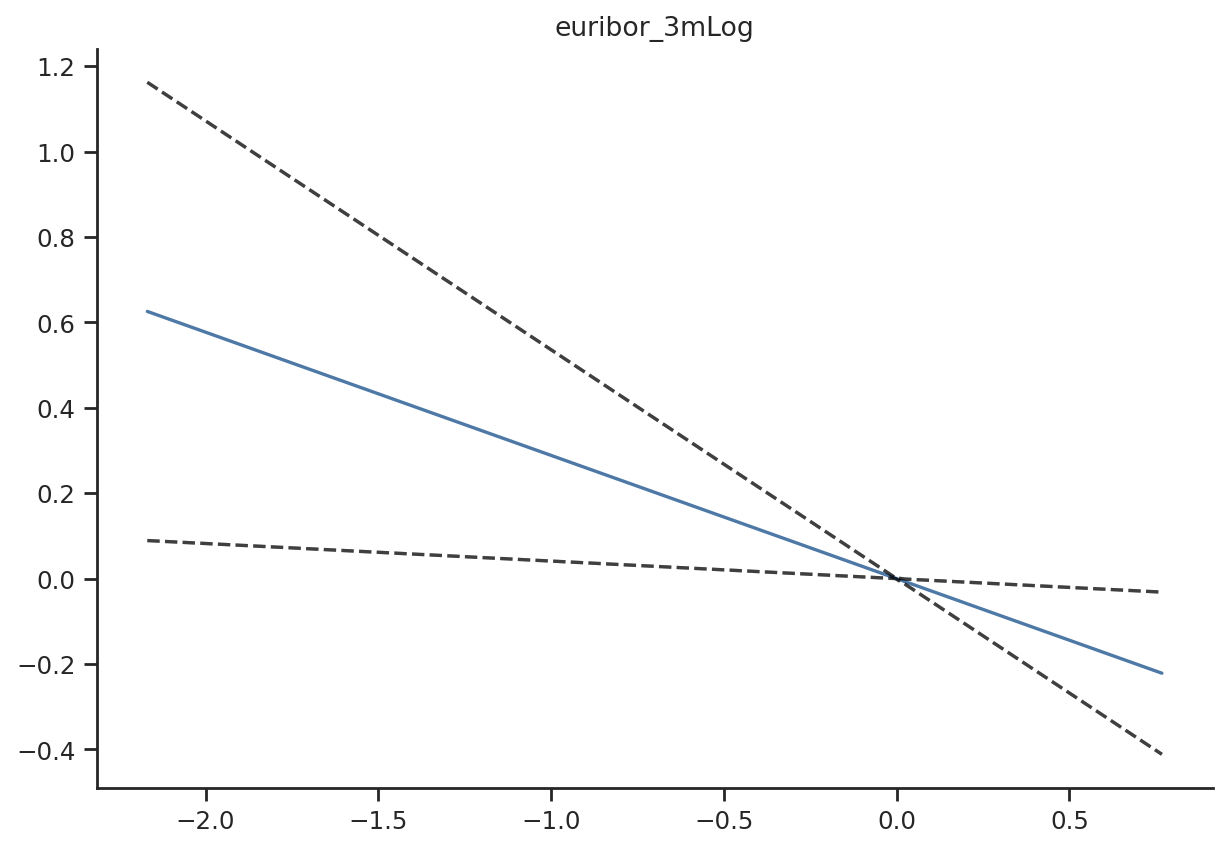

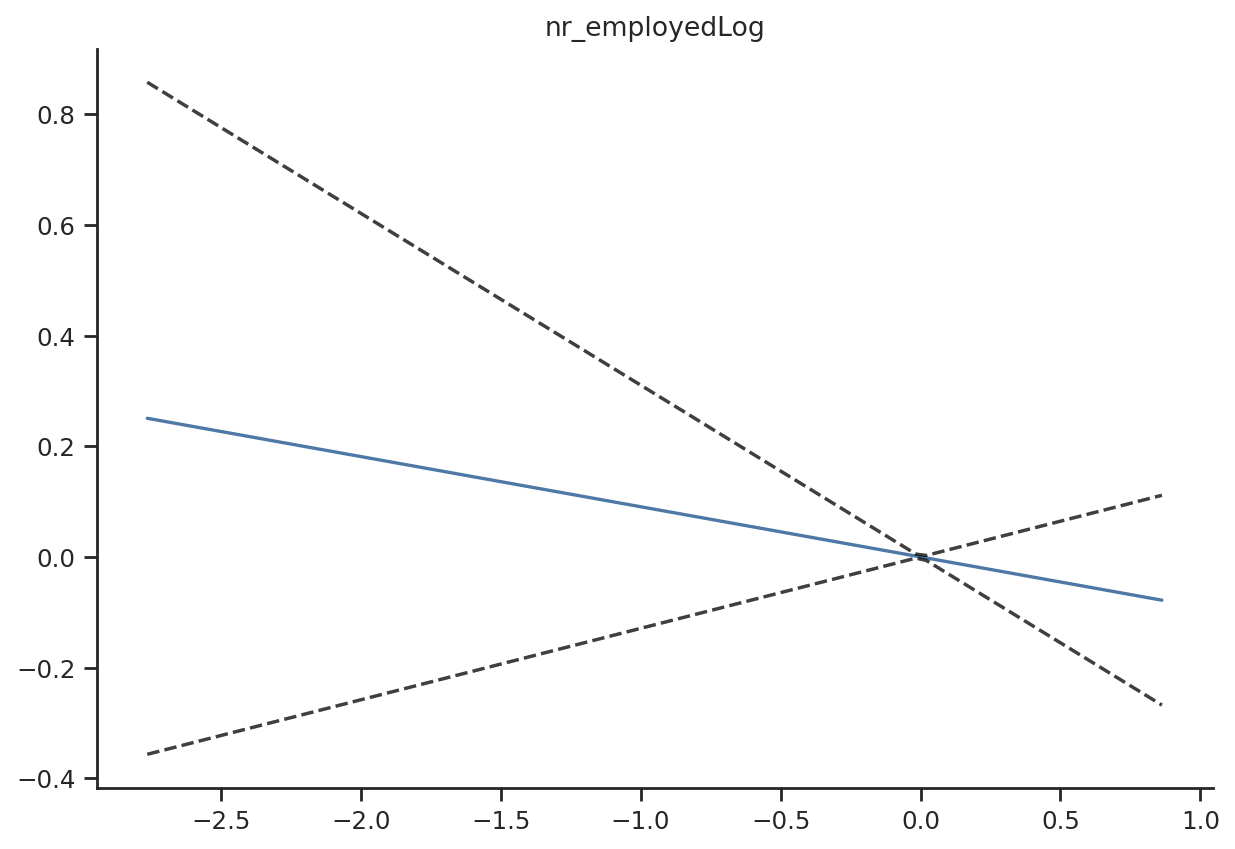

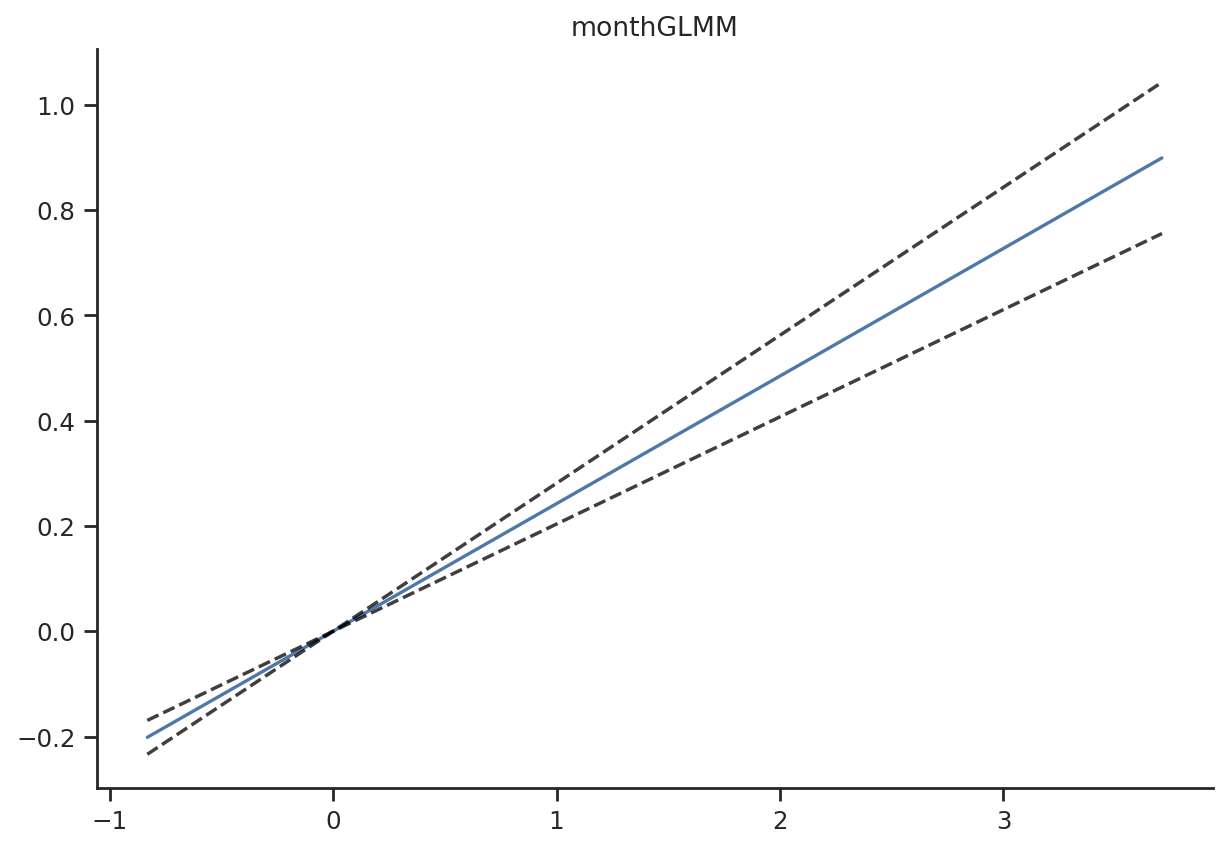

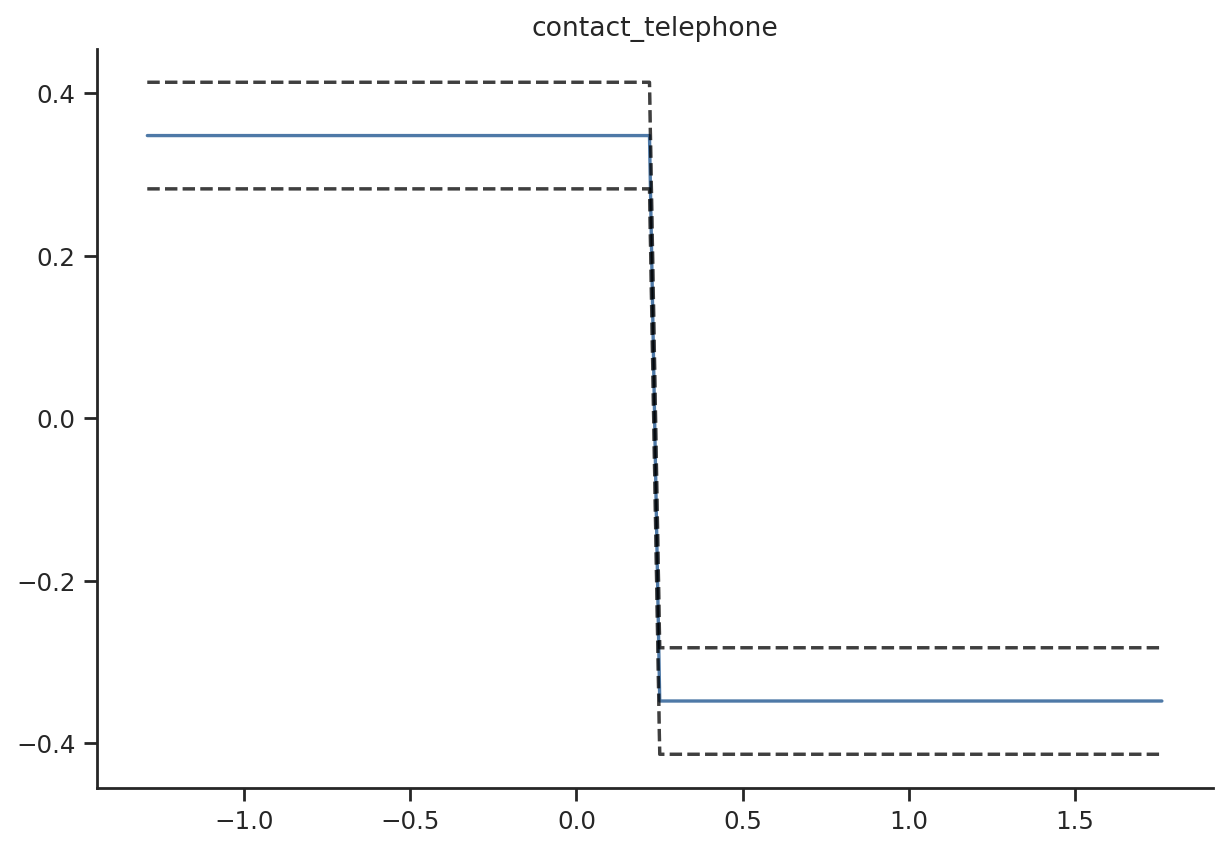

In [ ]:
for j, term in enumerate(gam1.terms):
    
    if term.isintercept:
        continue

    XX = gam1.generate_X_grid(term=j)
    pdep, confi = gam1.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    # plt.ylim(-2, 2)
        
    plt.title(gam_feature[j])
    sns.despine()
    plt.show()

(True Negatives):  4484
(False Positives):  65
(False Negatives):  577
(True Positives):  68
Total Actuall Subscribed:  645
(True Negatives):  3557
(False Positives):  6223
(False Negatives):  167
(True Positives):  1183
Total Actuall Subscribed:  1350


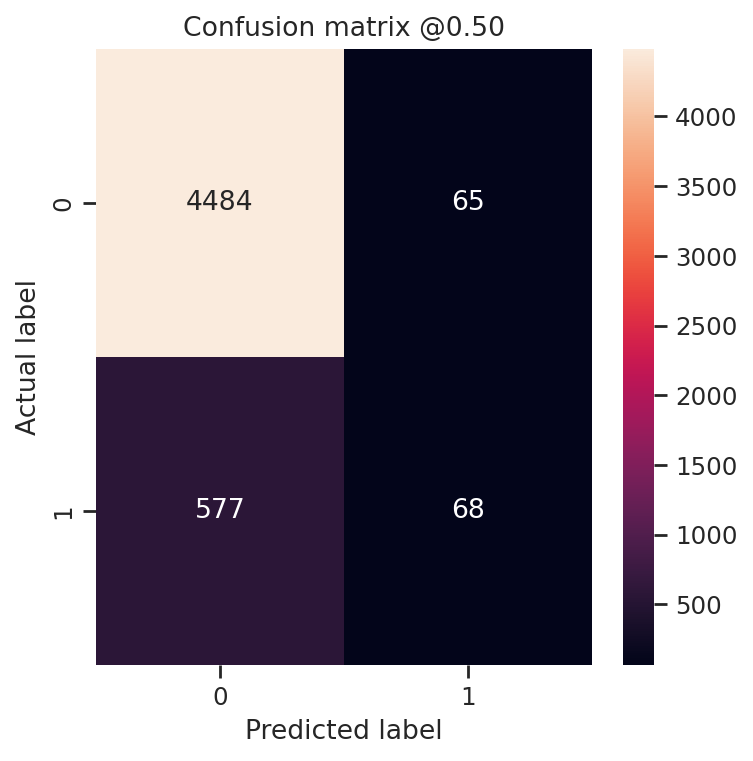

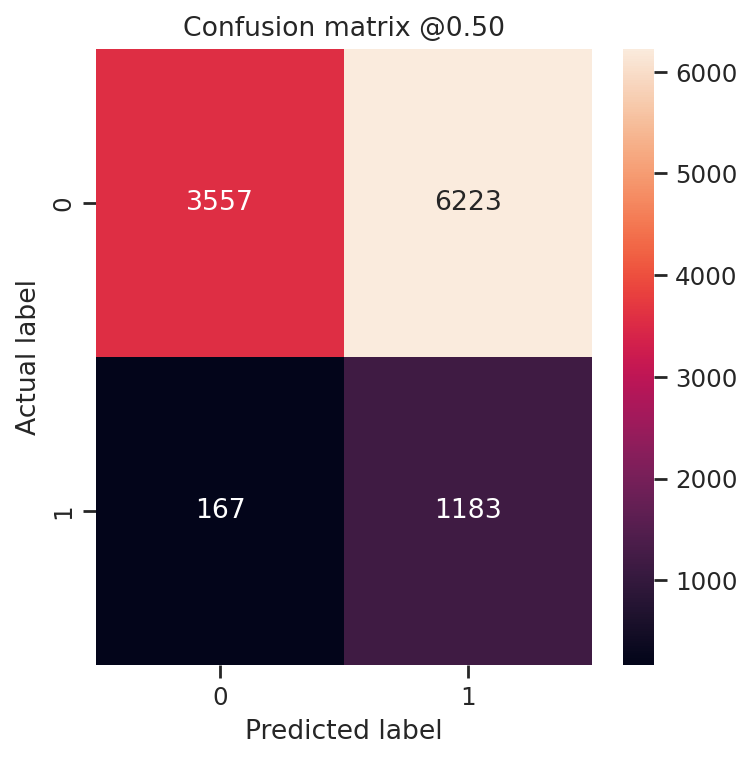

In [ ]:
# GAM 1

tau = 1/20

method = gam1


y_prob = method.predict_proba(gamX_valid_s)
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]
plot_cm(y_valid, y_pred)

# Test
y_prob = method.predict_proba(gamX_test_s)
y_pred = [1 if x >= tau else 0 for x in y_prob]
plot_cm(y_test,y_pred)

## Remove 2 variables

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pygam import LogisticGAM, s, f, l, te

gam_feature1 = ['emp_var_rate',
                'cons_price_idxLog',
                'monthGLMM',
                'contact_telephone']

gamX_train1 = train[gam_feature1]
gamX_valid1 = valid[gam_feature1]
gamX_test1 = test[gam_feature1]


# Standardization

scaler = StandardScaler()
gamX_train_s1 = scaler.fit_transform(gamX_train1)
gamX_valid_s1 = scaler.transform(gamX_valid1)
gamX_test_s1 = scaler.transform(gamX_test1)

gamX_train1.head()

emp_var_rate  cons_price_idxLog  monthGLMM  contact_telephone
17211           1.4           4.537362  -0.674690                  0
158             1.1           4.543231  -1.332033                  1
30440          -1.8           4.531448  -1.332033                  0
13445           1.4           4.542422  -0.977180                  0
8538            1.4           4.548229  -0.876911                  1

## GAM 2

In [ ]:
from pygam import LogisticGAM, s, f, l, te
from optuna.samplers import TPESampler

def objective(trial):

    # We use factor function for categorical variables (even if we code them into numerical)
    # We find the same lambda for all models
    lambdas = []
    for j in range(len(gam_feature1)):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))
                               
    model = LogisticGAM(l(0) + l(1) + l(2) + f(3), lam=lambdas)
    
    model.fit(gamX_train_s1, y_train)
    
    return model.statistics_['loglikelihood']

sampler = TPESampler(seed=7)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='maximize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120)

In [ ]:
lambdas2 = list(study.best_params.values())
print(lambdas2)

[0.00010059423643047235, 0.00010242676924038799, 0.0005444649653849569, 0.00010082520860800148]


In [ ]:
lambdas2 = [0.00010059423643047235, 0.00010242676924038799,
            0.0005444649653849569, 0.00010082520860800148]
            
gam2 = LogisticGAM(l(0) + l(1) + l(2) + f(3), lam=lambdas2)
gam2.fit(gamX_train_s1, y_train)
gam2.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         5.0
Link Function:                        LogitLink Log Likelihood:                                 -6449.8513
Number of Samples:                        20775 AIC:                                            12909.7025
                                                AICc:                                           12909.7065
                                                UBRE:                                               2.6216
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1673
Feature Function                  Lam

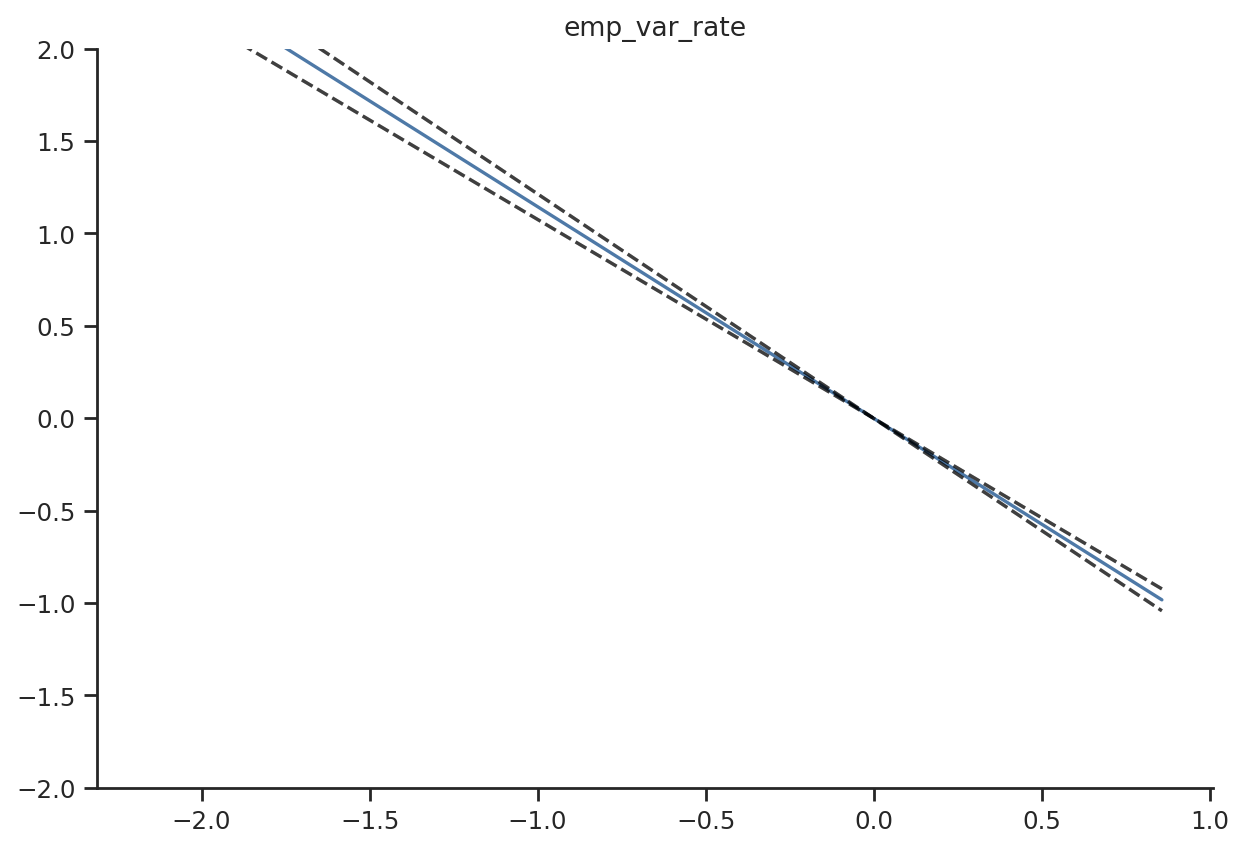

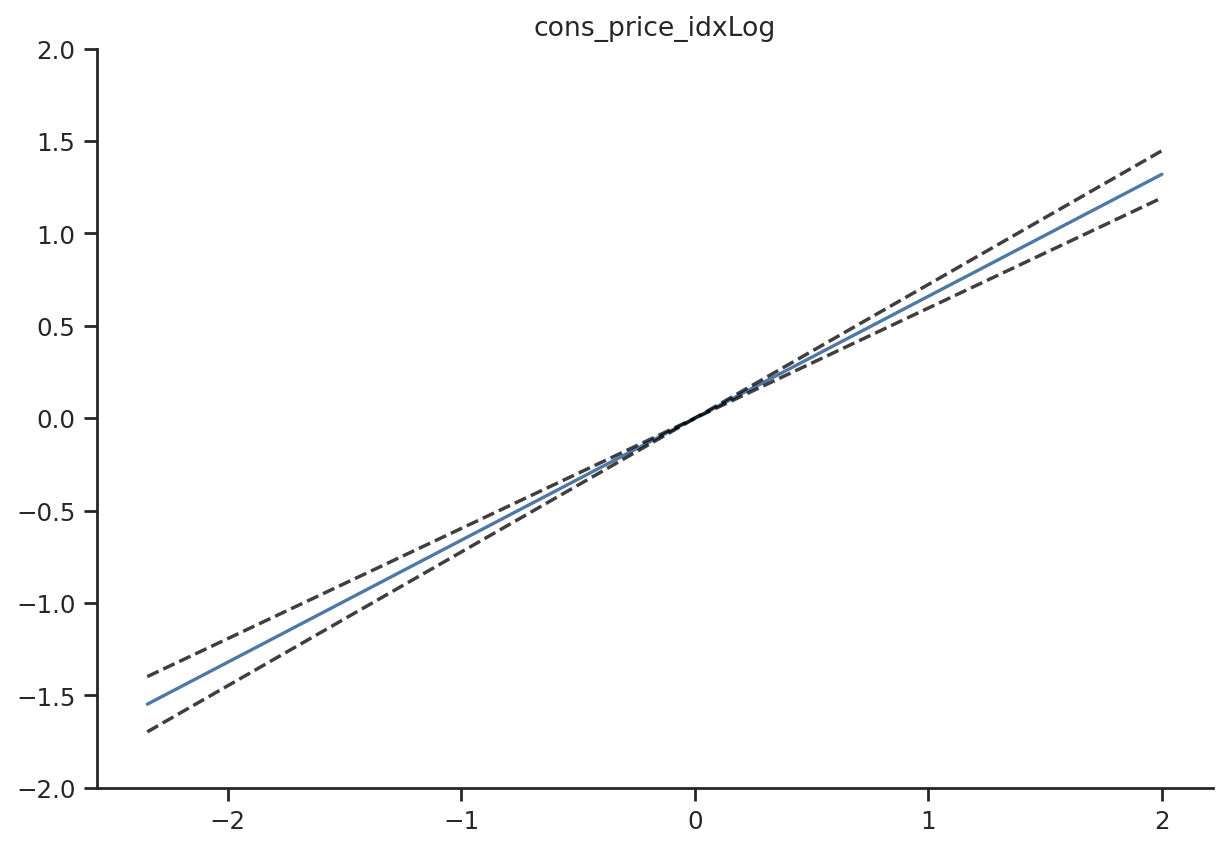

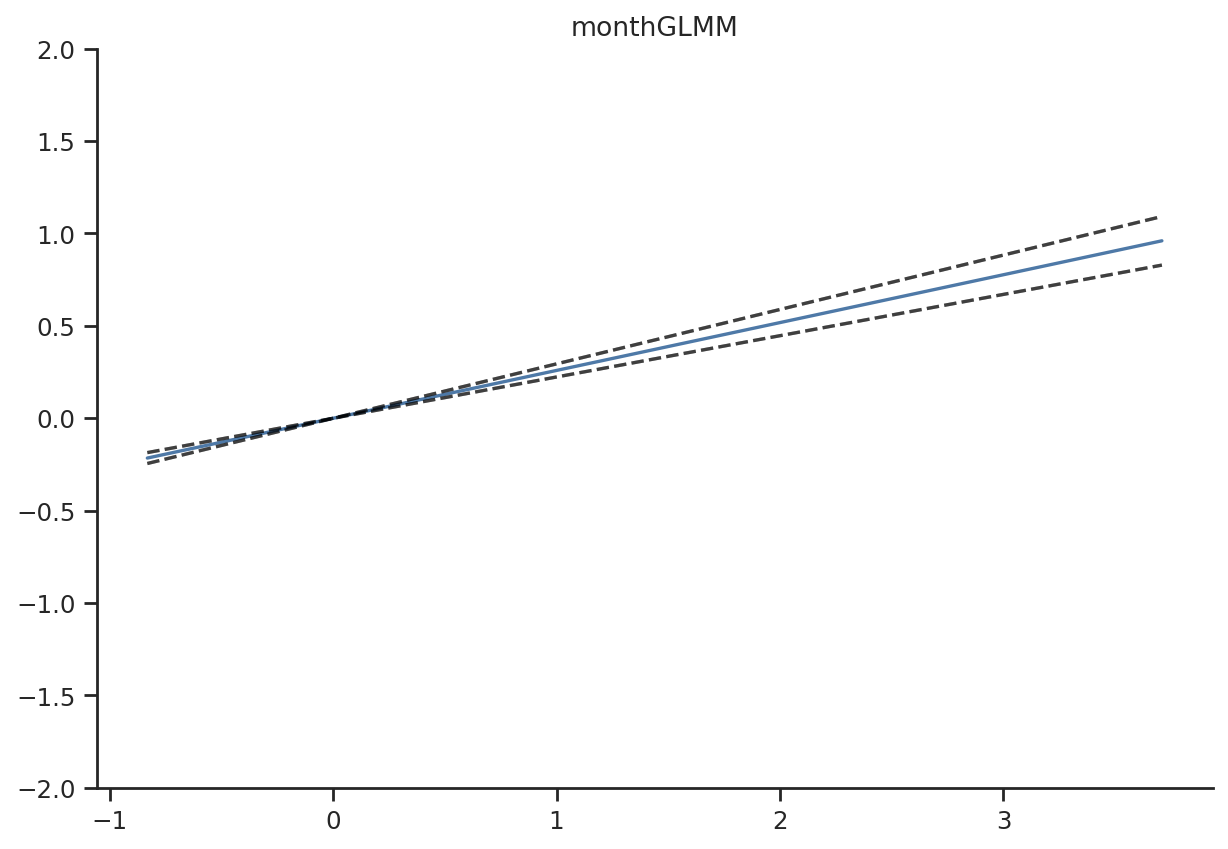

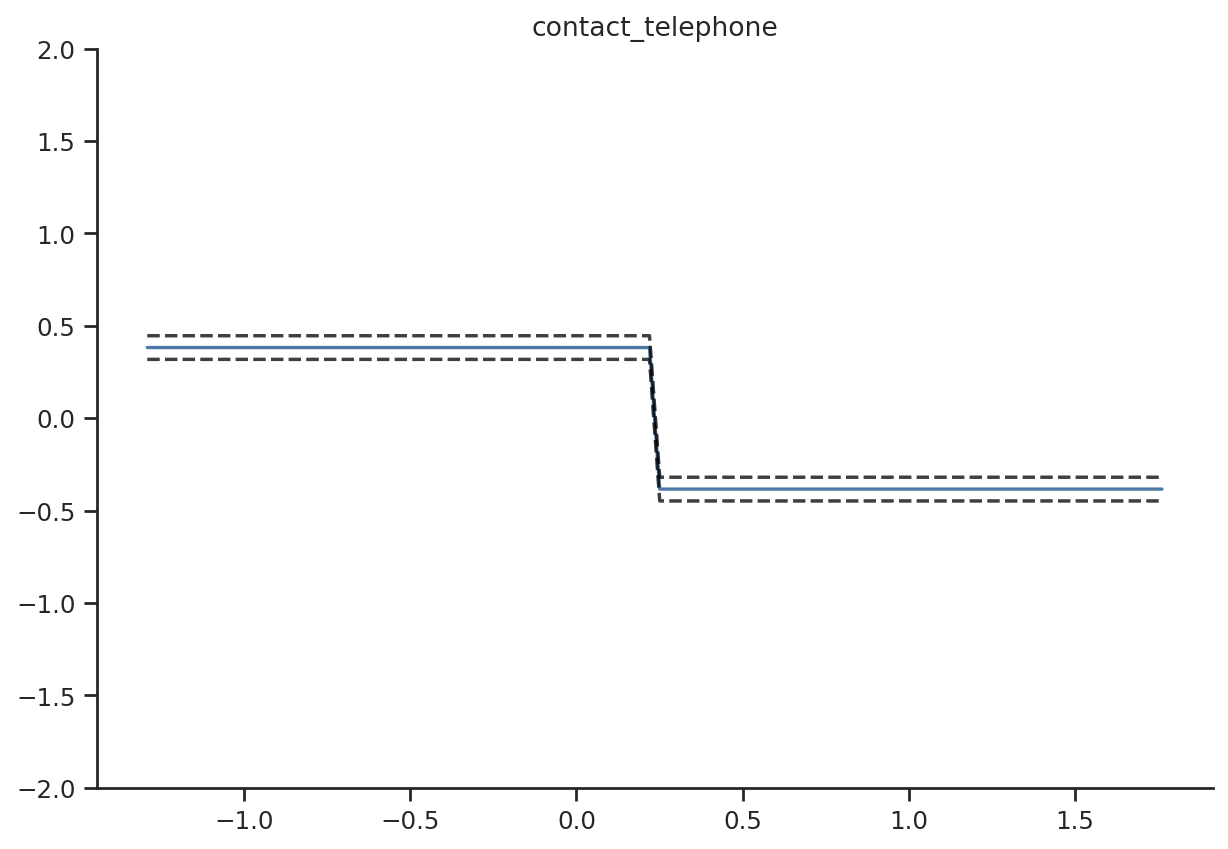

In [ ]:
for j, term in enumerate(gam2.terms):
    
    if term.isintercept:
        continue

    XX = gam2.generate_X_grid(term=j)
    pdep, confi = gam2.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
        
    plt.title(gam_feature1[j])
    sns.despine()
    plt.show()

## GAM3

In [ ]:
from pygam import LogisticGAM, s, f, l, te
from optuna.samplers import TPESampler

def objective(trial):

    # We use factor function for categorical variables (even if we code them into numerical)
    # We find the same lambda for all models
    lambdas = []
    for j in range(len(gam_feature1)):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))
                               
    model = LogisticGAM(l(0) + s(1) + l(2) + f(3), lam=lambdas)
    
    model.fit(gamX_train_s1, y_train)
    
    return model.statistics_['loglikelihood']

sampler = TPESampler(seed=7)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='maximize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120)

In [ ]:
lambdas3 = list(study.best_params.values())
print(lambdas3)

[0.43656569022519803, 0.00010011192730571648, 0.005374331800398458, 3.5209112244294714]


In [ ]:
lambdas3 = [0.43656569022519803, 0.00010011192730571648,
            0.005374331800398458, 3.5209112244294714]
gam3 = LogisticGAM(l(0) + s(1) + l(2) + f(3), lam=lambdas3)
gam3.fit(gamX_train_s1, y_train)
gam3.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      21.726
Link Function:                        LogitLink Log Likelihood:                                 -6278.2069
Number of Samples:                        20775 AIC:                                            12599.8658
                                                AICc:                                           12599.9178
                                                UBRE:                                               2.6073
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1894
Feature Function                  Lam

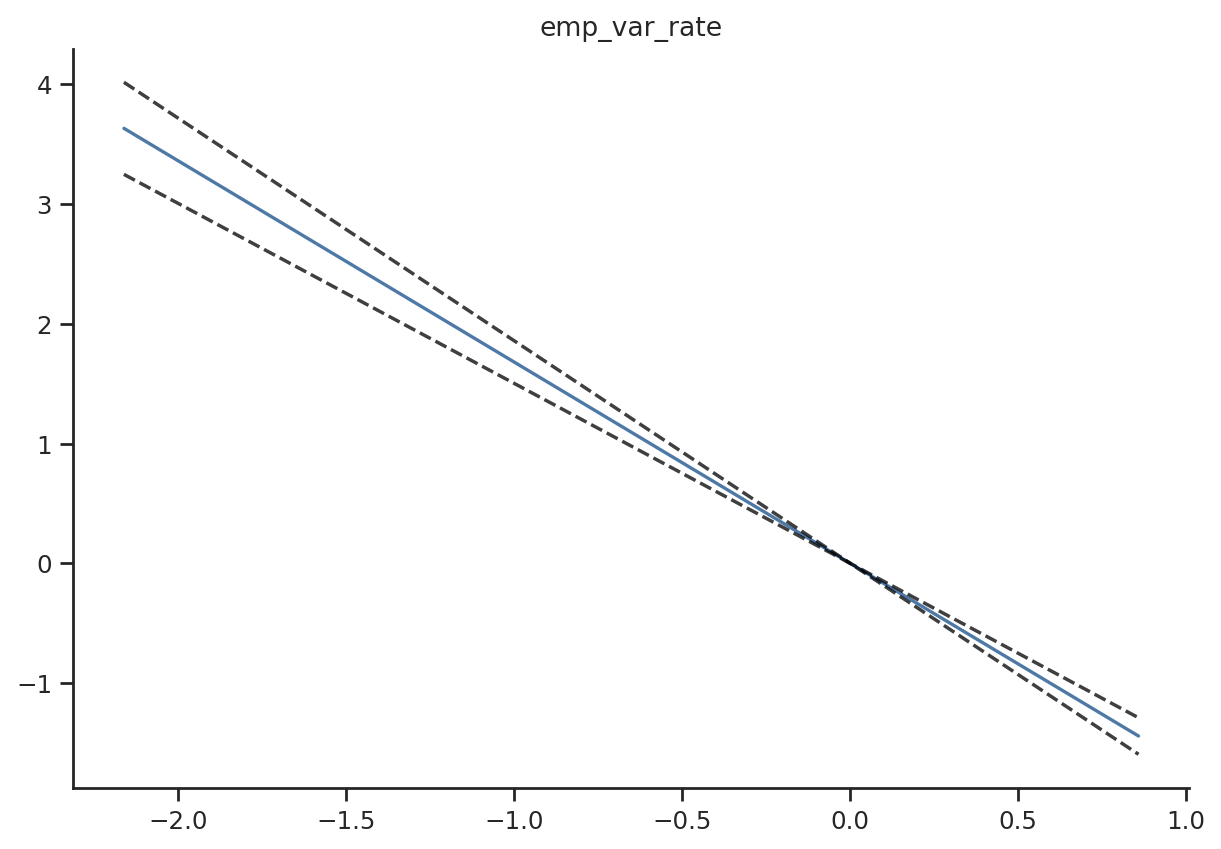

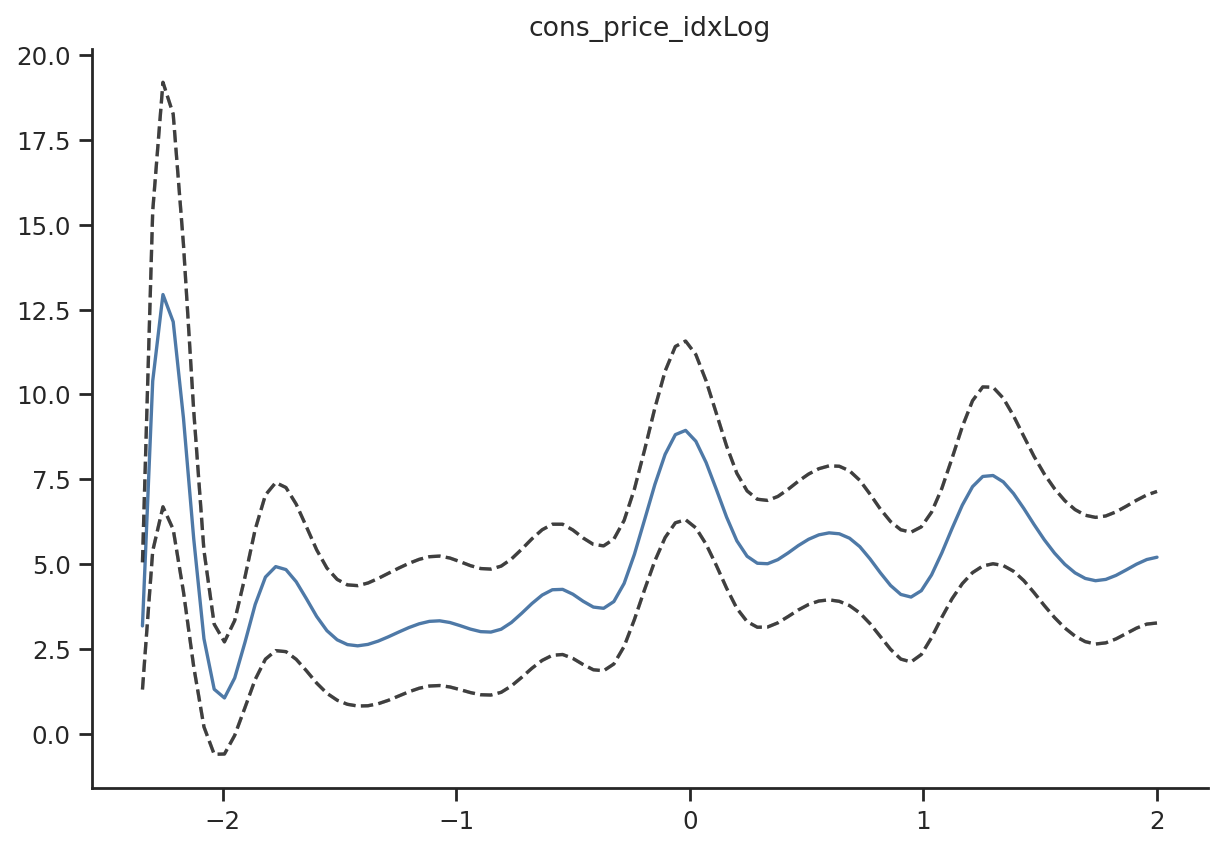

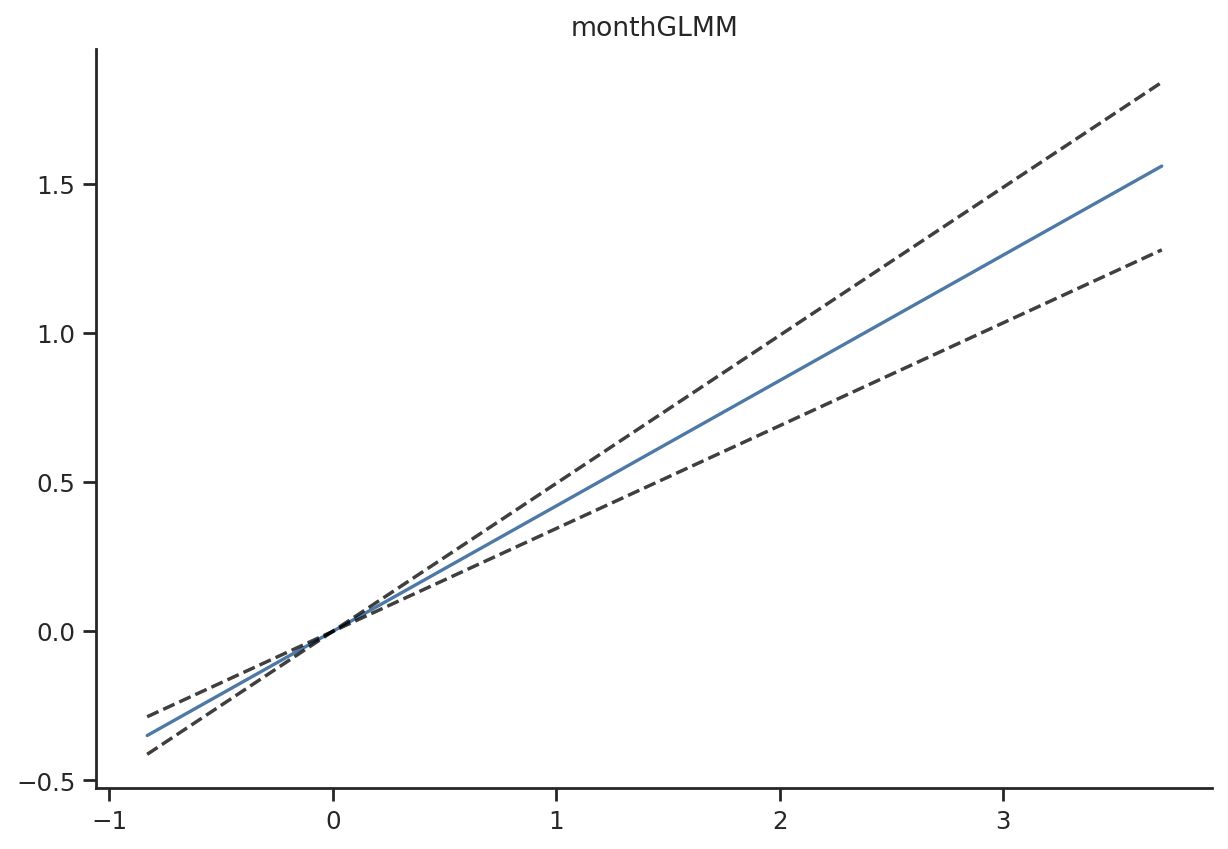

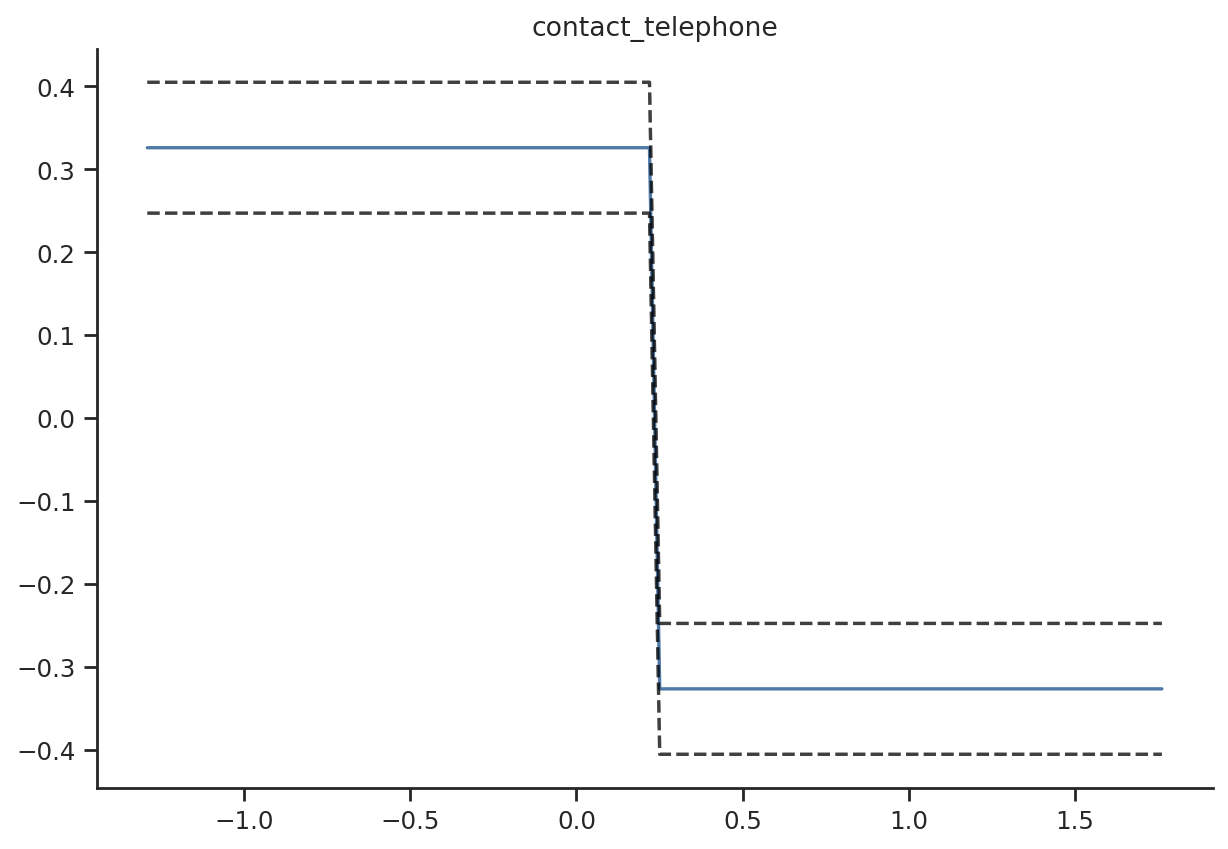

In [ ]:
for j, term in enumerate(gam3.terms):
    
    if term.isintercept:
        continue

    XX = gam3.generate_X_grid(term=j)
    pdep, confi = gam3.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
        
    plt.title(gam_feature1[j])
    sns.despine()
    plt.show()

## GAM4

In [ ]:
from pygam import LogisticGAM, s, f, l, te
from optuna.samplers import TPESampler

def objective(trial):

    # We use factor function for categorical variables (even if we code them into numerical)
    # We find the same lambda for all models
    lambdas = []
    for j in range(len(gam_feature1)):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))
                               
    model = LogisticGAM(l(0) + l(1) + s(2) + f(3), lam=lambdas)
    
    model.fit(gamX_train_s1, y_train)
    
    return model.statistics_['loglikelihood']

sampler = TPESampler(seed=7)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='maximize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120)

In [ ]:
lambdas4 = list(study.best_params.values())
print(lambdas4)

[0.011811440876605671, 0.00014693721947410453, 0.00010052459532575233, 0.22718833890831708]


In [ ]:
lambdas4 = [0.011811440876605671, 0.00014693721947410453,
            0.00010052459532575233, 0.22718833890831708]

gam4 = LogisticGAM(l(0) + l(1) + s(2) + f(3), lam=lambdas4)
gam4.fit(gamX_train_s1, y_train)
gam4.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     12.9226
Link Function:                        LogitLink Log Likelihood:                                 -6346.1702
Number of Samples:                        20775 AIC:                                            12718.1857
                                                AICc:                                           12718.2057
                                                UBRE:                                               2.6127
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1807
Feature Function                  Lam

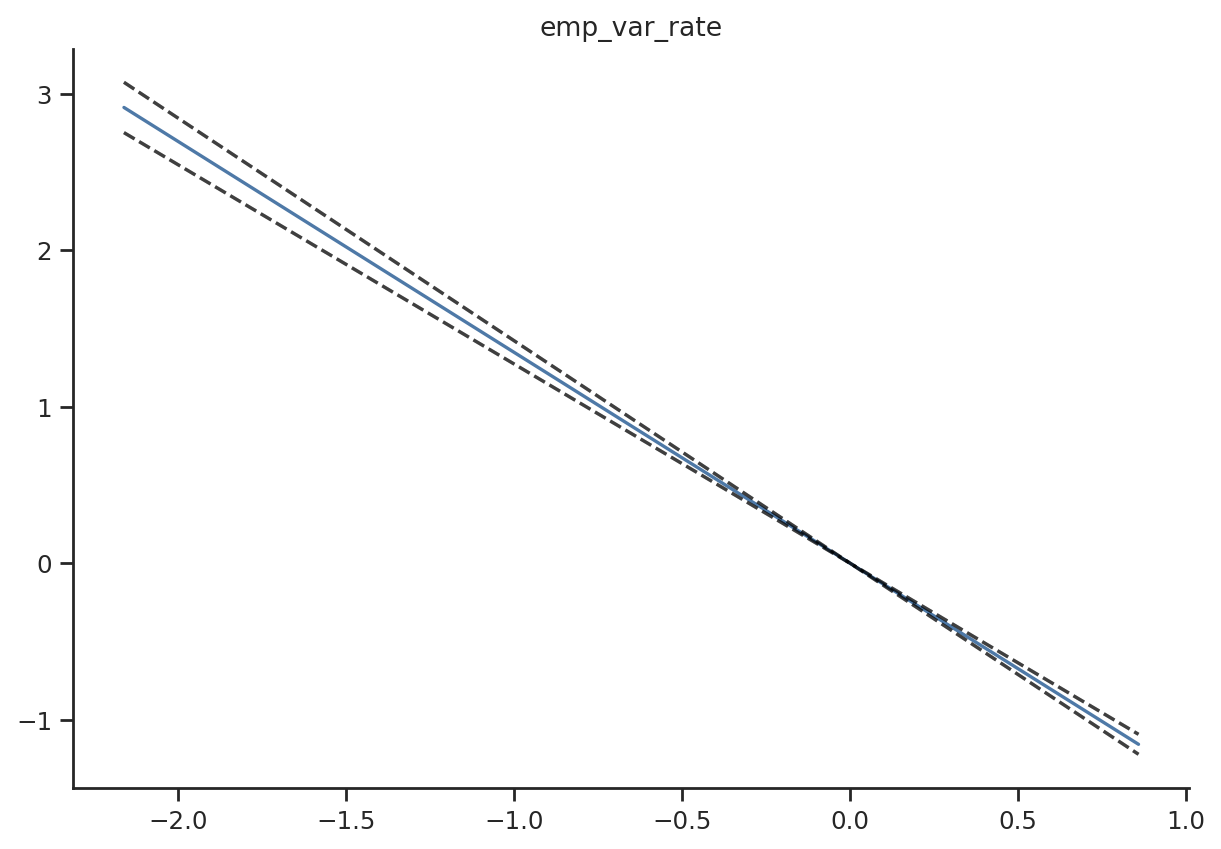

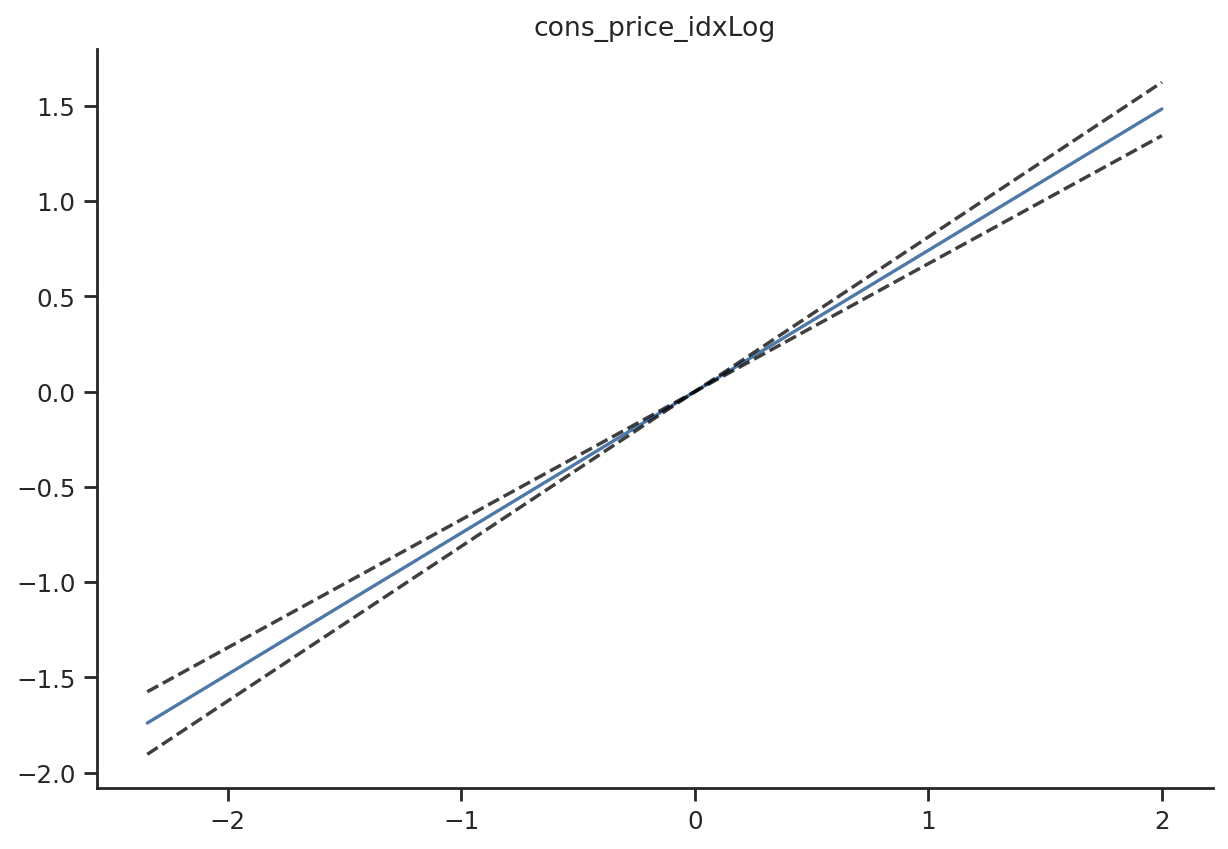

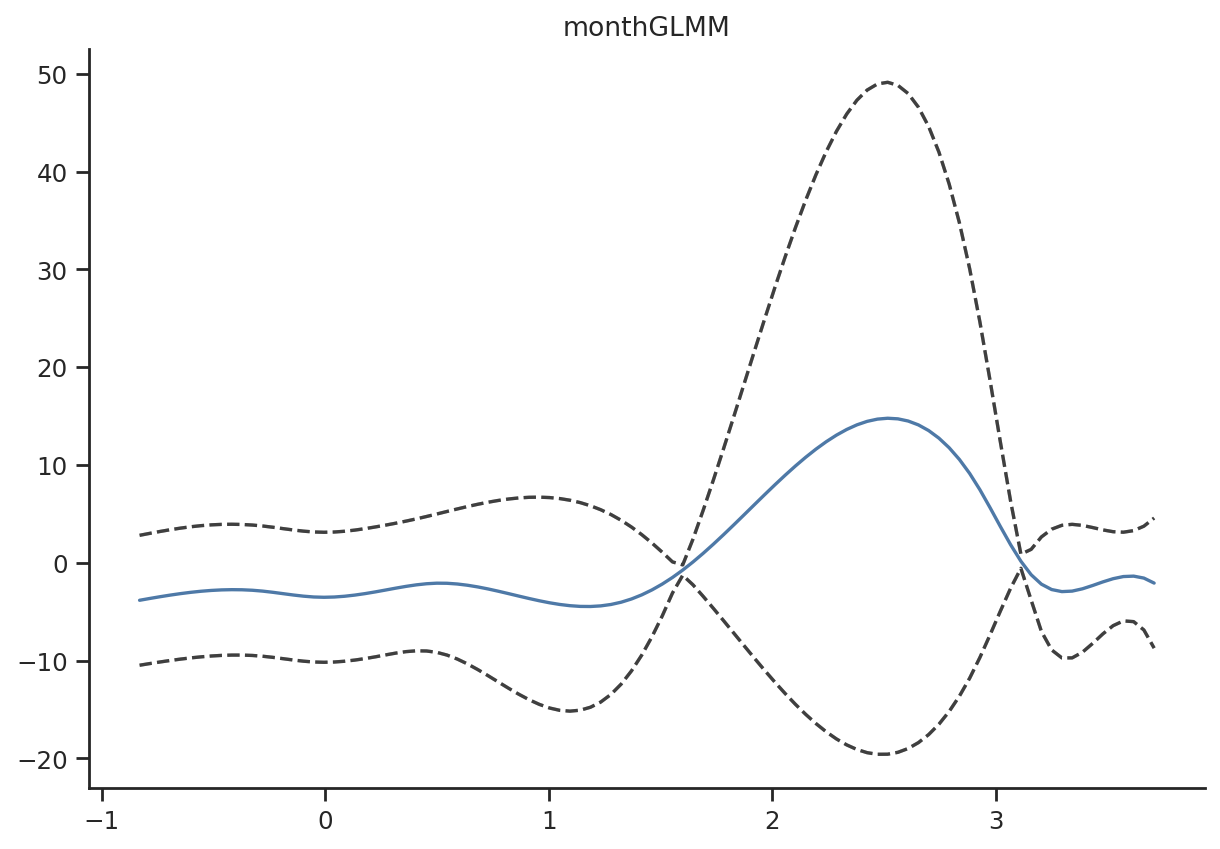

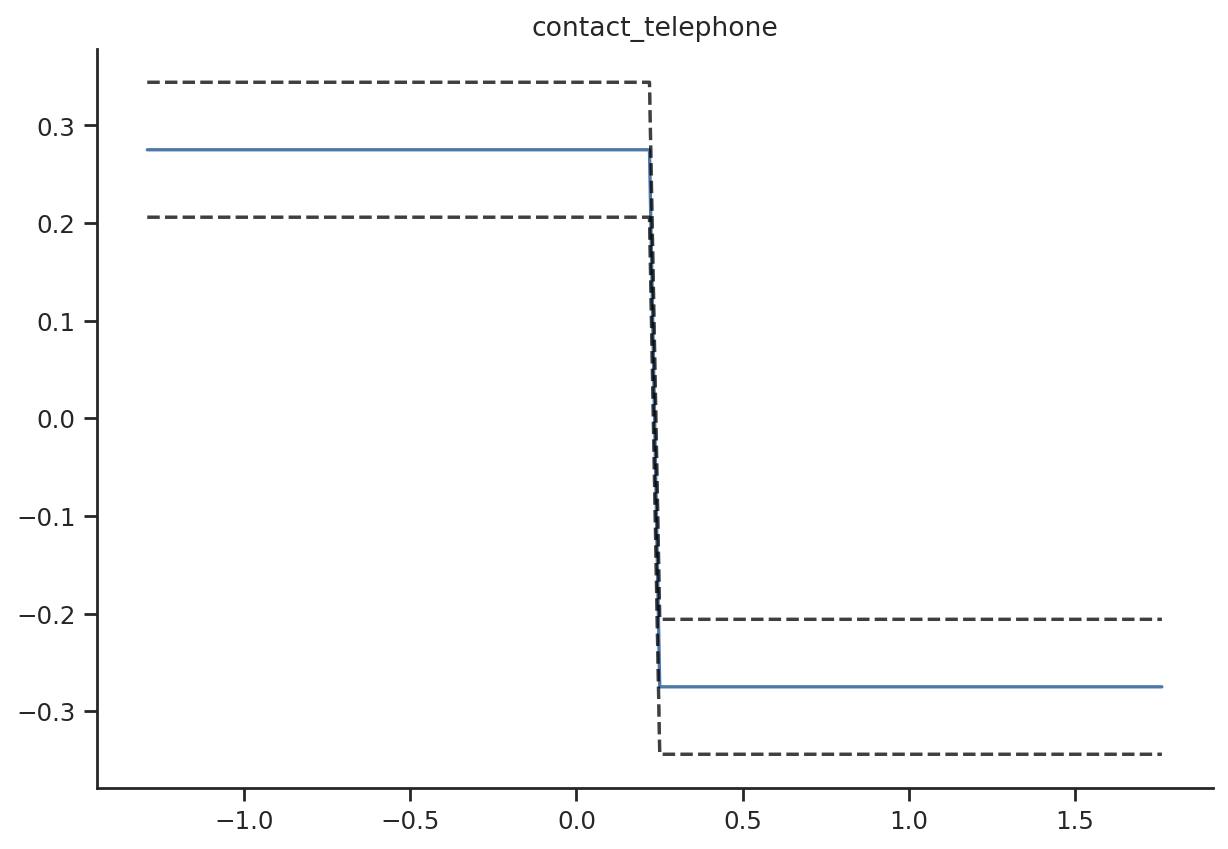

In [ ]:
for j, term in enumerate(gam4.terms):
    
    if term.isintercept:
        continue

    XX = gam4.generate_X_grid(term=j)
    pdep, confi = gam4.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
        
    plt.title(gam_feature1[j])
    sns.despine()
    plt.show()

## GAM5

In [ ]:
from pygam import LogisticGAM, s, f, l, te
from optuna.samplers import TPESampler

def objective(trial):

    # We use factor function for categorical variables (even if we code them into numerical)
    # We find the same lambda for all models
    lambdas = []
    for j in range(len(gam_feature1)):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))
                               
    model = LogisticGAM(s(0) + l(1) + s(2) + f(3), lam=lambdas)
    
    model.fit(gamX_train_s1, y_train)
    
    return model.statistics_['loglikelihood']

sampler = TPESampler(seed=7)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='maximize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120)

In [ ]:
lambdas5 = list(study.best_params.values())
print(lambdas5)

[0.0001002219461803175, 0.000404102610712792, 0.00010437242995140664, 0.00038950675303330517]


In [ ]:
lambdas5 = [0.0001002219461803175, 0.000404102610712792,
            0.00010437242995140664, 0.00038950675303330517]
            
gam5 = LogisticGAM(s(0) + l(1) + s(2) + f(3), lam=lambdas5)
gam5.fit(gamX_train_s1, y_train)
gam5.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     17.9961
Link Function:                        LogitLink Log Likelihood:                                  -6315.501
Number of Samples:                        20775 AIC:                                            12666.9942
                                                AICc:                                           12667.0308
                                                UBRE:                                               2.6104
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1846
Feature Function                  Lam

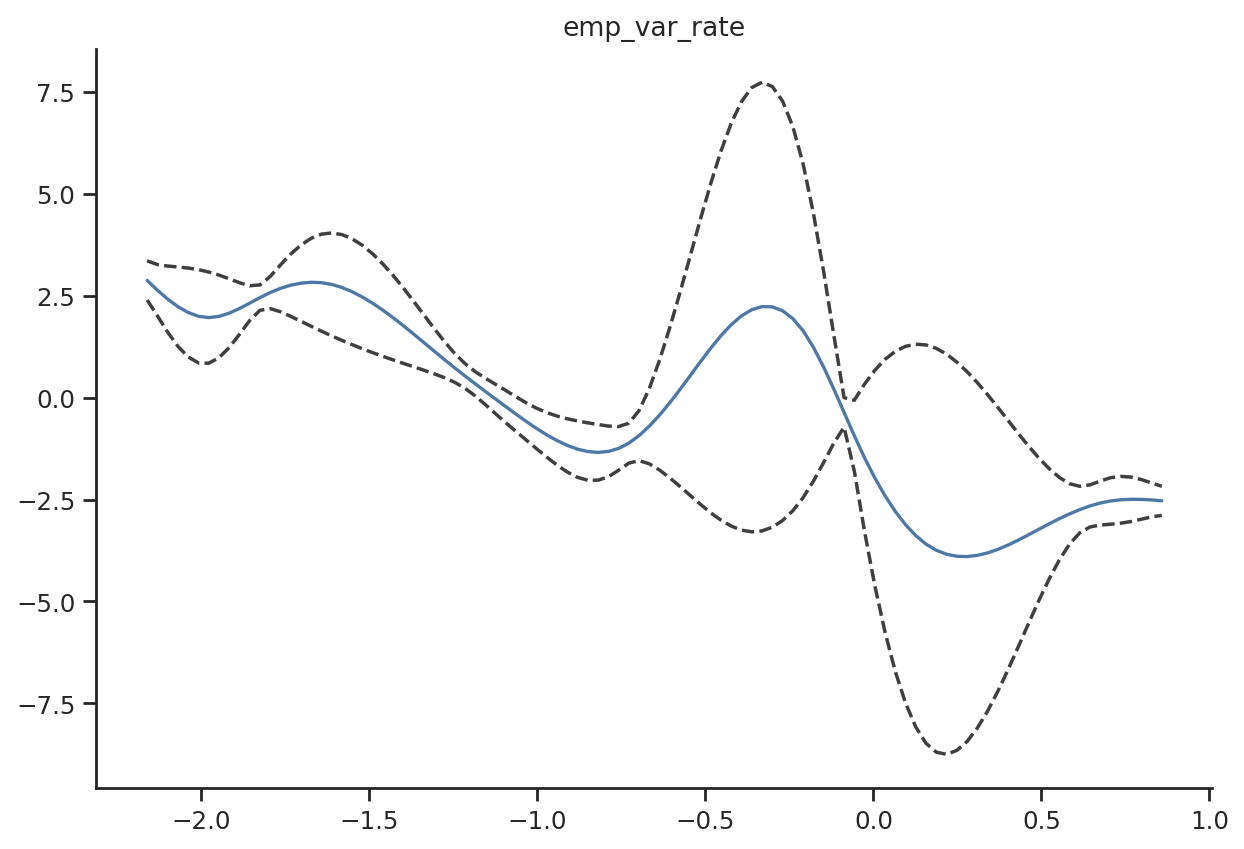

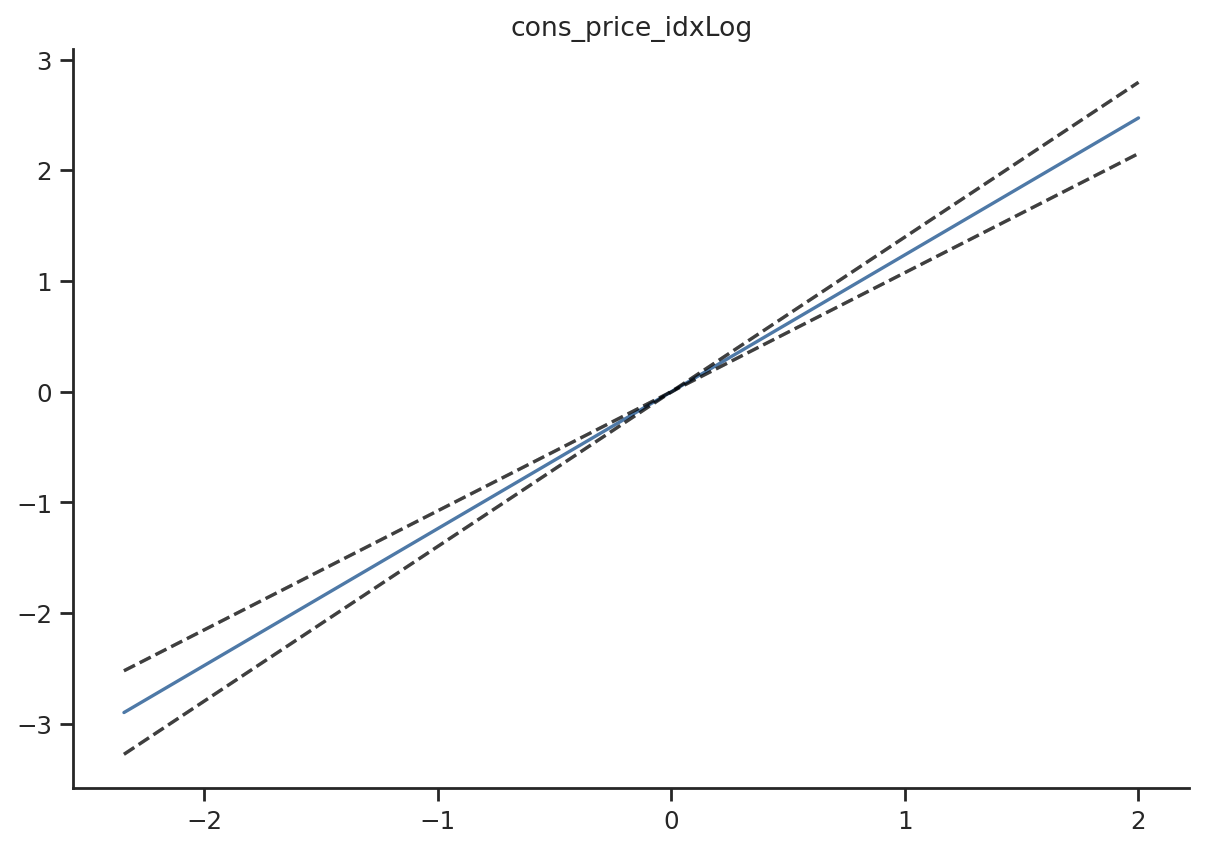

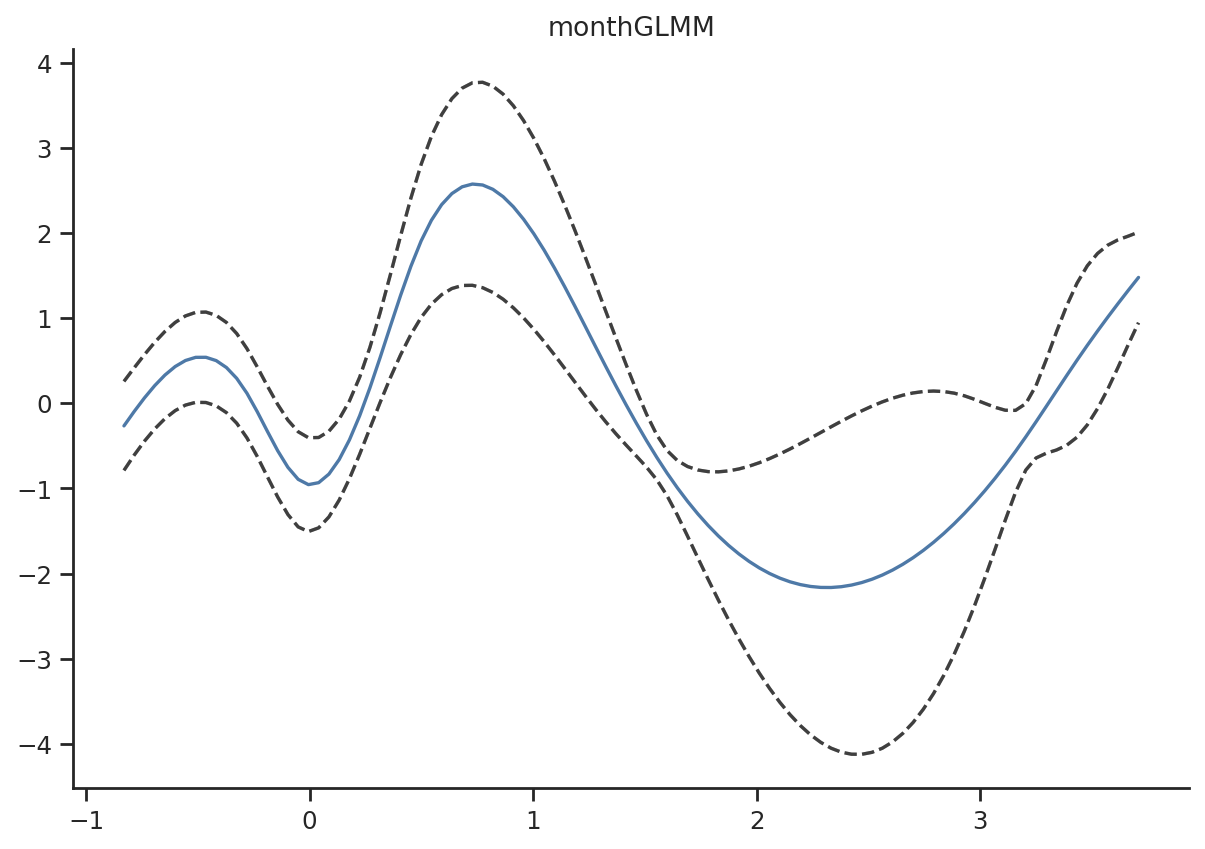

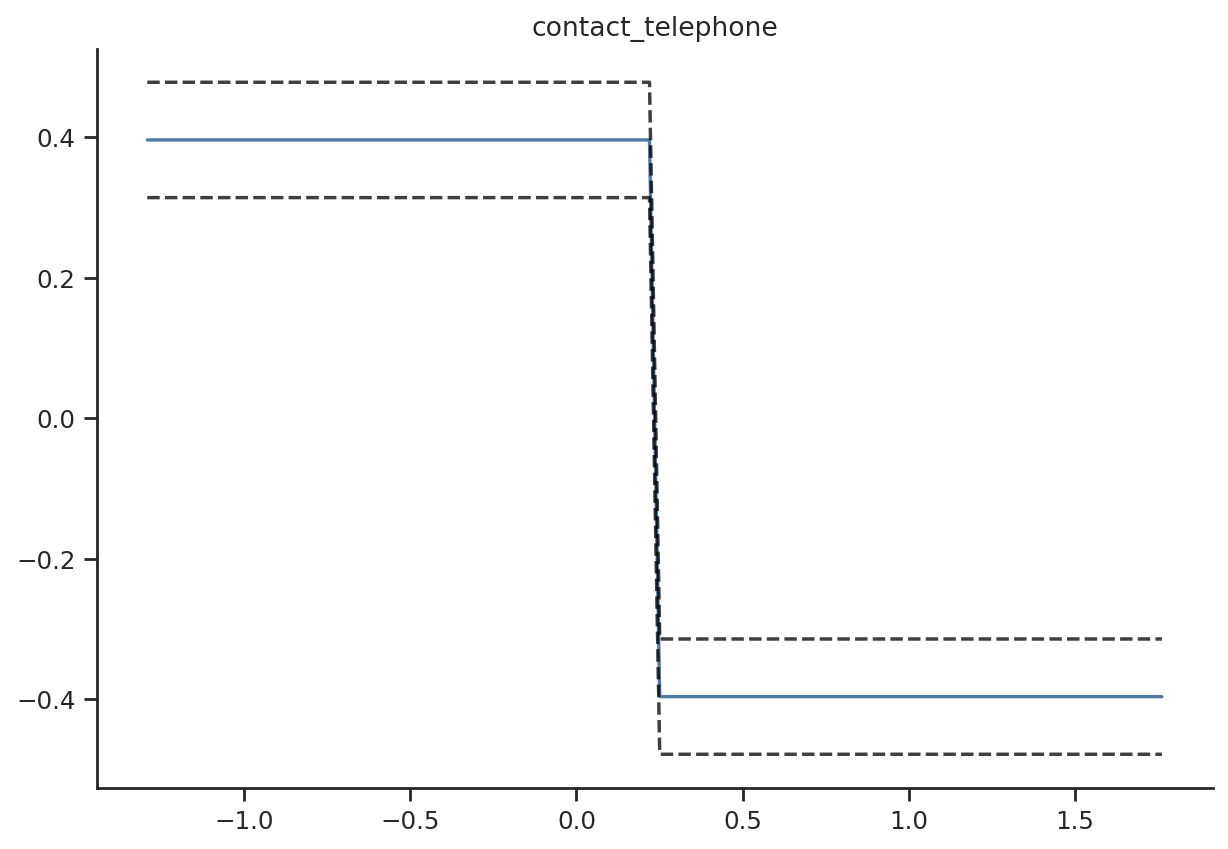

In [ ]:
for j, term in enumerate(gam5.terms):
    
    if term.isintercept:
        continue

    XX = gam5.generate_X_grid(term=j)
    pdep, confi = gam5.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.title(gam_feature1[j])
    sns.despine()
    plt.show()

## GAM 6 - Best

In [ ]:
from pygam import LogisticGAM, s, f, l, te
from optuna.samplers import TPESampler

def objective(trial):

    # We use factor function for categorical variables (even if we code them into numerical)
    # We find the same lambda for all models
    lambdas = []
    for j in range(len(gam_feature1)):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))
                               
    model = LogisticGAM(l(0) + s(1) + s(2) + f(3), lam=lambdas)
    
    model.fit(gamX_train_s1, y_train)
    
    return model.statistics_['loglikelihood']

sampler = TPESampler(seed=7)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='maximize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120)

In [ ]:
lambdas6 = list(study.best_params.values())
print(lambdas6)

[37.87100184322894, 0.00010223697752598182, 0.00010004477745950303, 0.01513717489920891]


In [ ]:
lambdas6 = [37.87100184322894, 0.00010223697752598182,
            0.00010004477745950303, 0.01513717489920891]
gam6 = LogisticGAM(l(0) + s(1) + s(2) + f(3), lam=lambdas6)
gam6.fit(gamX_train_s1, y_train)
gam6.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     26.7591
Link Function:                        LogitLink Log Likelihood:                                 -6259.3005
Number of Samples:                        20775 AIC:                                            12572.1193
                                                AICc:                                           12572.1962
                                                UBRE:                                               2.6062
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1919
Feature Function                  Lam

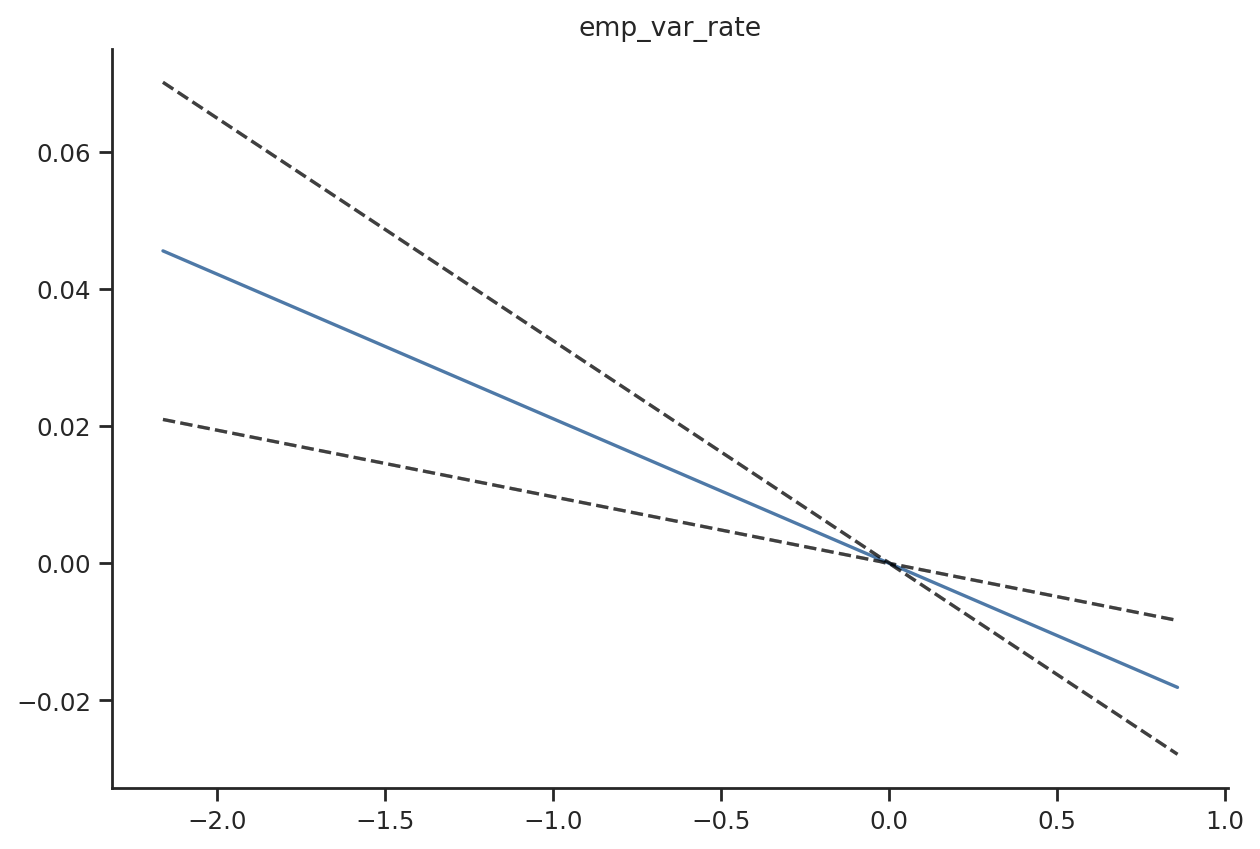

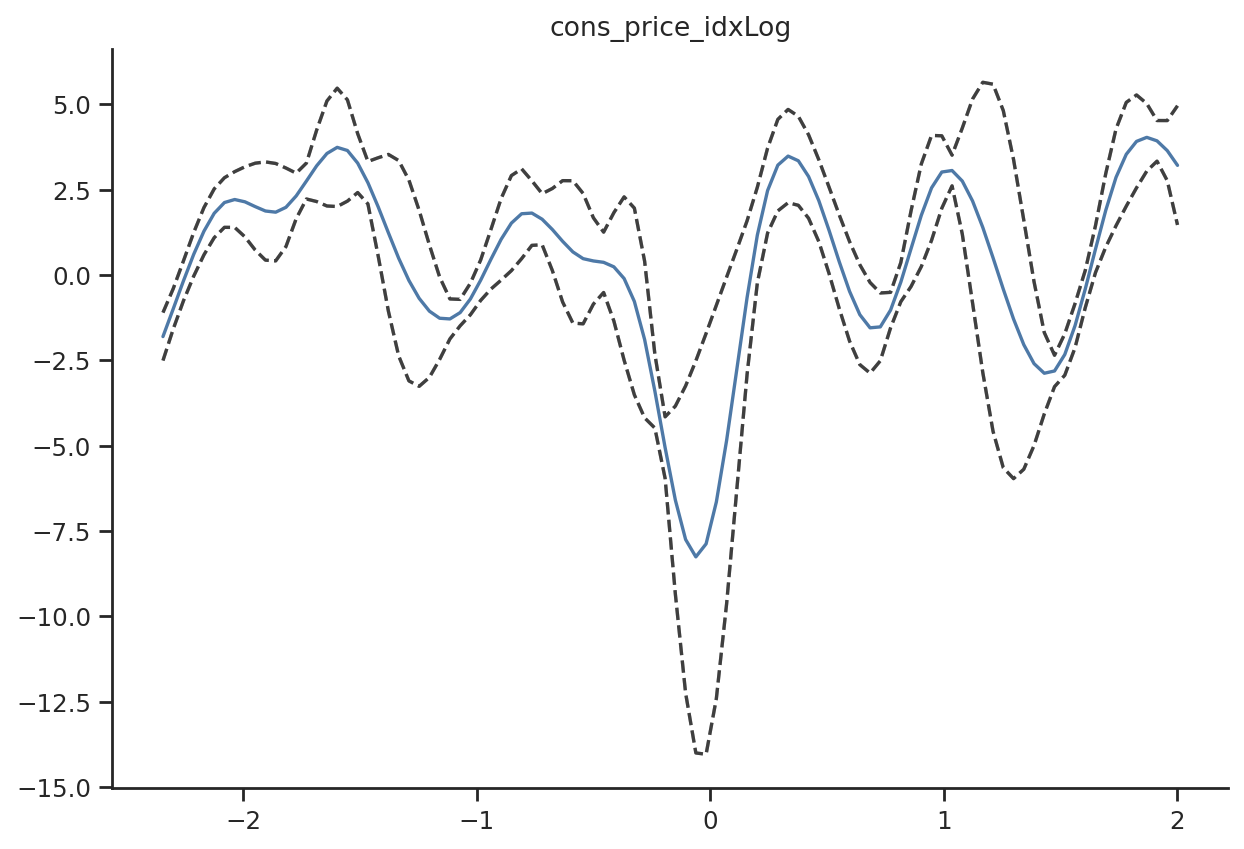

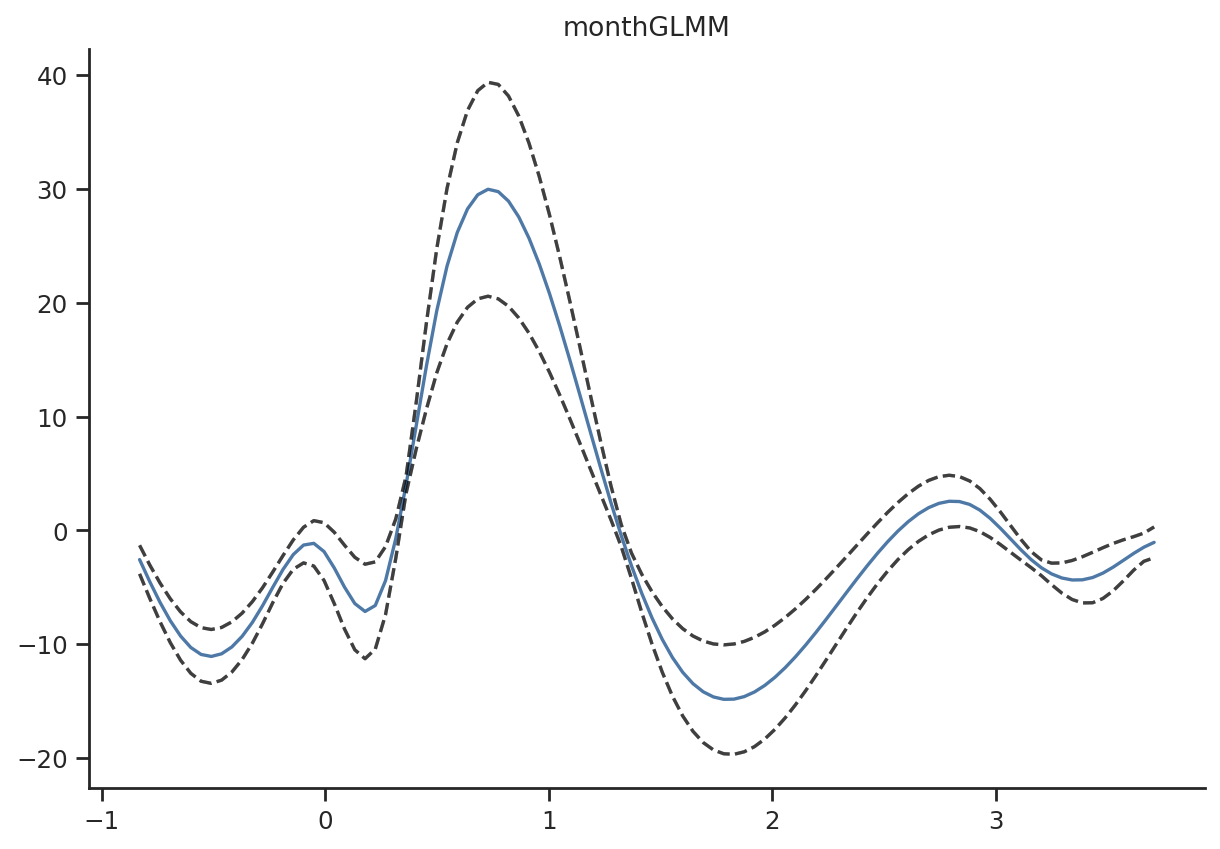

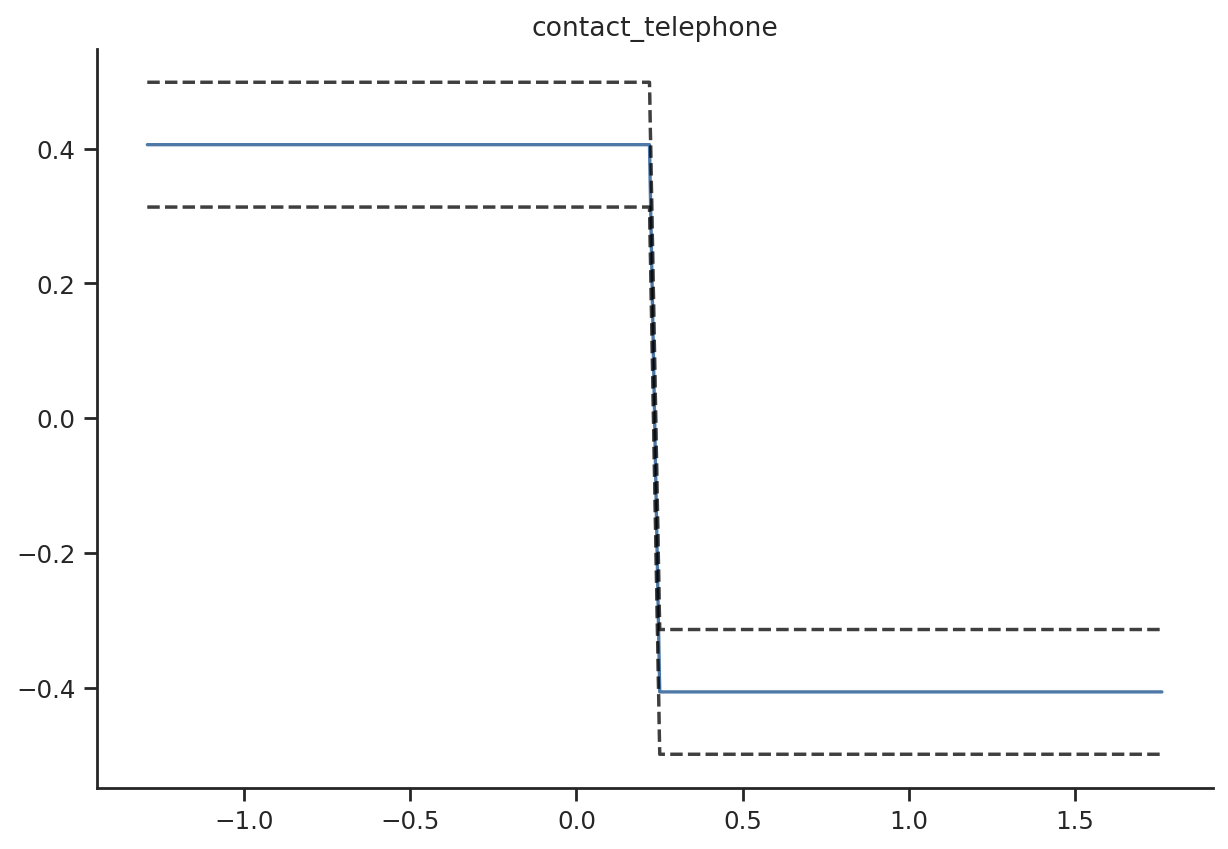

In [ ]:
for j, term in enumerate(gam6.terms):
    
    if term.isintercept:
        continue

    XX = gam6.generate_X_grid(term=j)
    pdep, confi = gam6.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.title(gam_feature1[j])
    sns.despine()
    plt.show()

## GAM 7

In [ ]:
from pygam import LogisticGAM, s, f, l, te
from optuna.samplers import TPESampler

def objective(trial):

    # We use factor function for categorical variables (even if we code them into numerical)
    # We find the same lambda for all models
    lambdas = []
    for j in range(len(gam_feature1)):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))
                               
    model = LogisticGAM(s(0) + s(1) + l(2) + f(3), lam=lambdas)
    
    model.fit(gamX_train_s1, y_train)
    
    return model.statistics_['loglikelihood']

sampler = TPESampler(seed=7)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='maximize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120)

In [ ]:
lambdas7 = list(study.best_params.values())
print(lambdas7)

[0.00010032710728877331, 0.00010191492097830459, 0.11470345326662706, 0.00017314722689406619]


In [ ]:
lambdas7 = [0.00010032710728877331, 0.00010191492097830459,
            0.11470345326662706, 0.00017314722689406619]

gam7 = LogisticGAM(s(0) + s(1) + l(2) + f(3), lam=lambdas7)
gam7.fit(gamX_train_s1, y_train)
gam7.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     26.9849
Link Function:                        LogitLink Log Likelihood:                                  -6259.298
Number of Samples:                        20775 AIC:                                             12572.566
                                                AICc:                                           12572.6442
                                                UBRE:                                               2.6062
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1919
Feature Function                  Lam

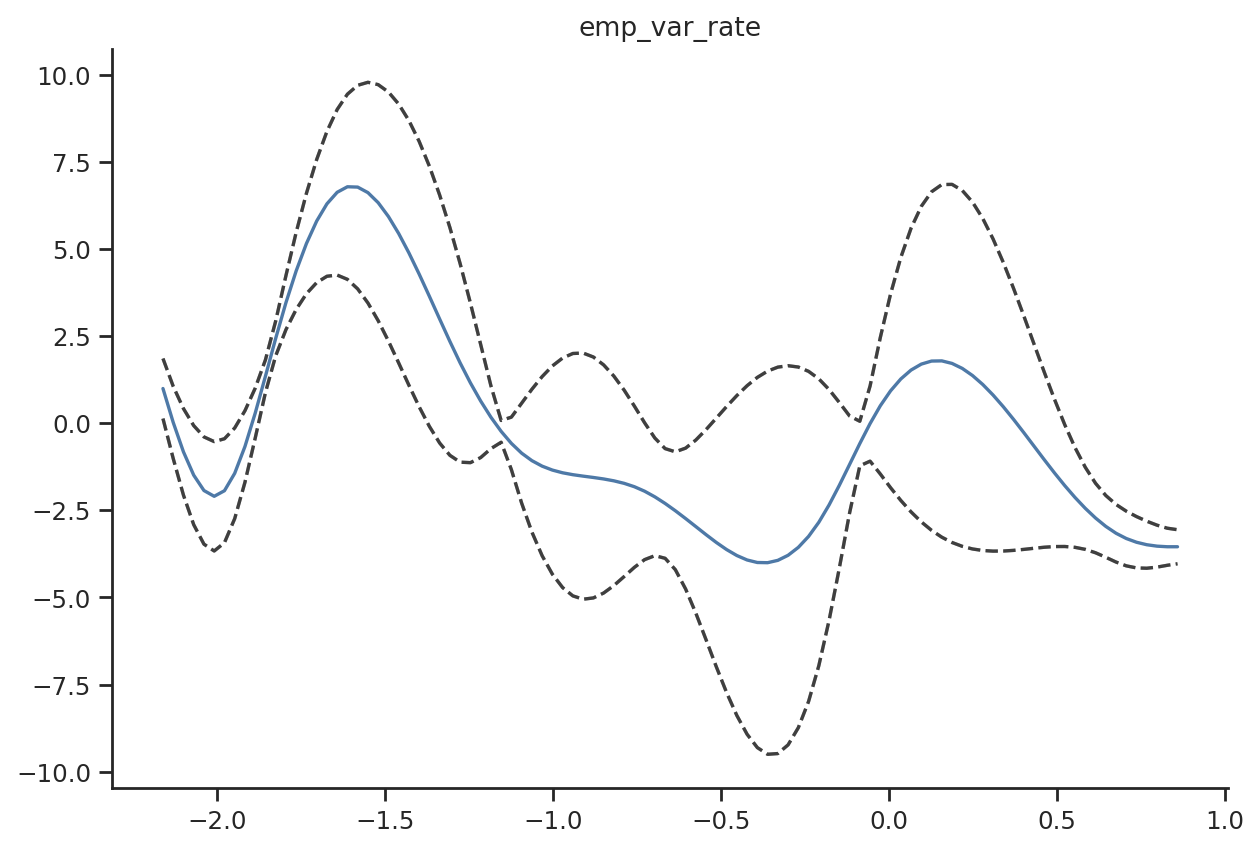

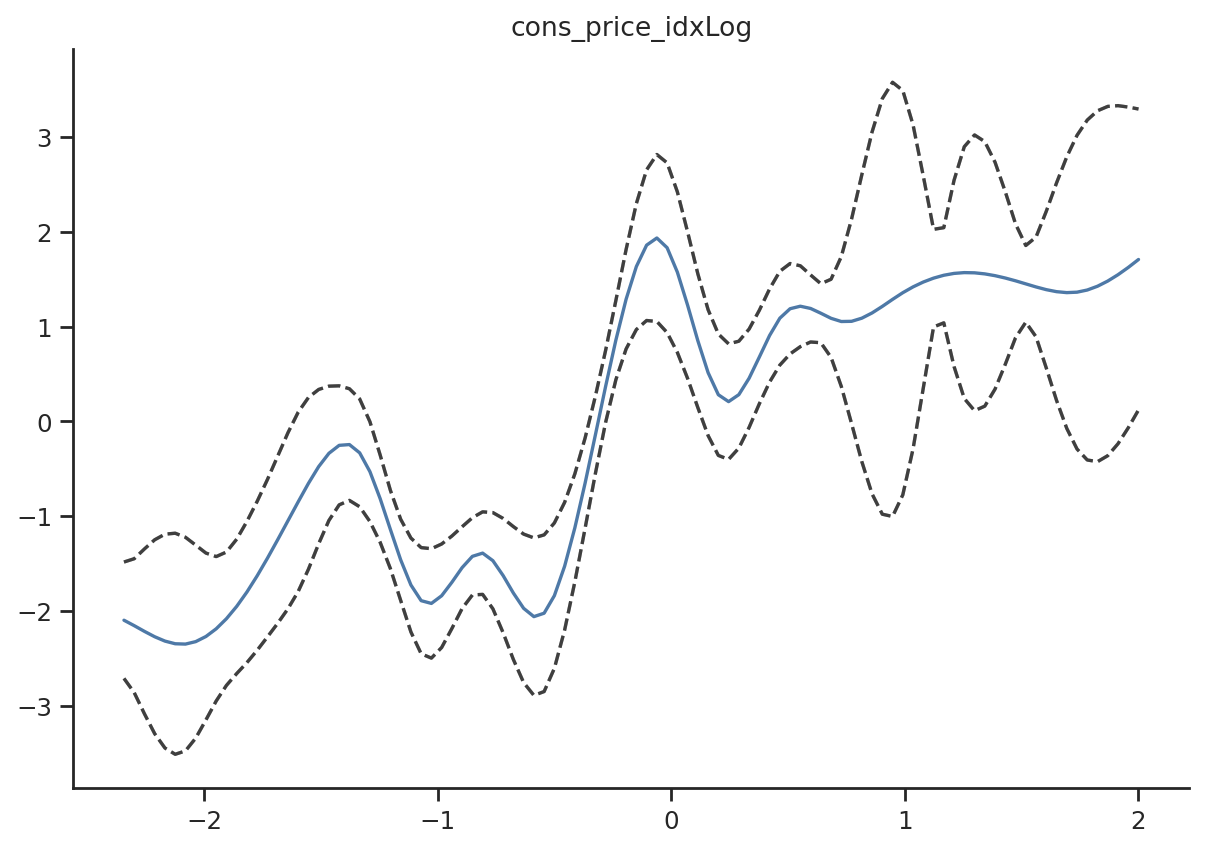

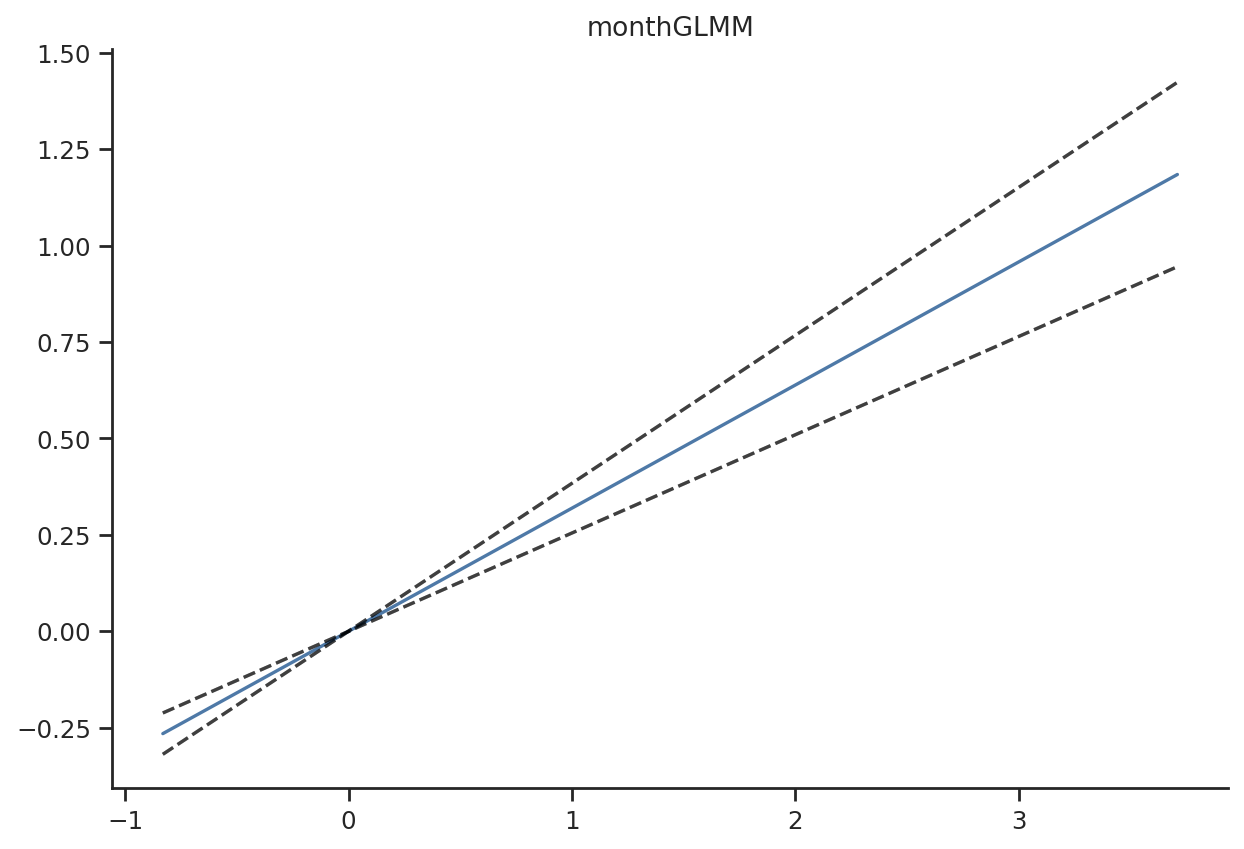

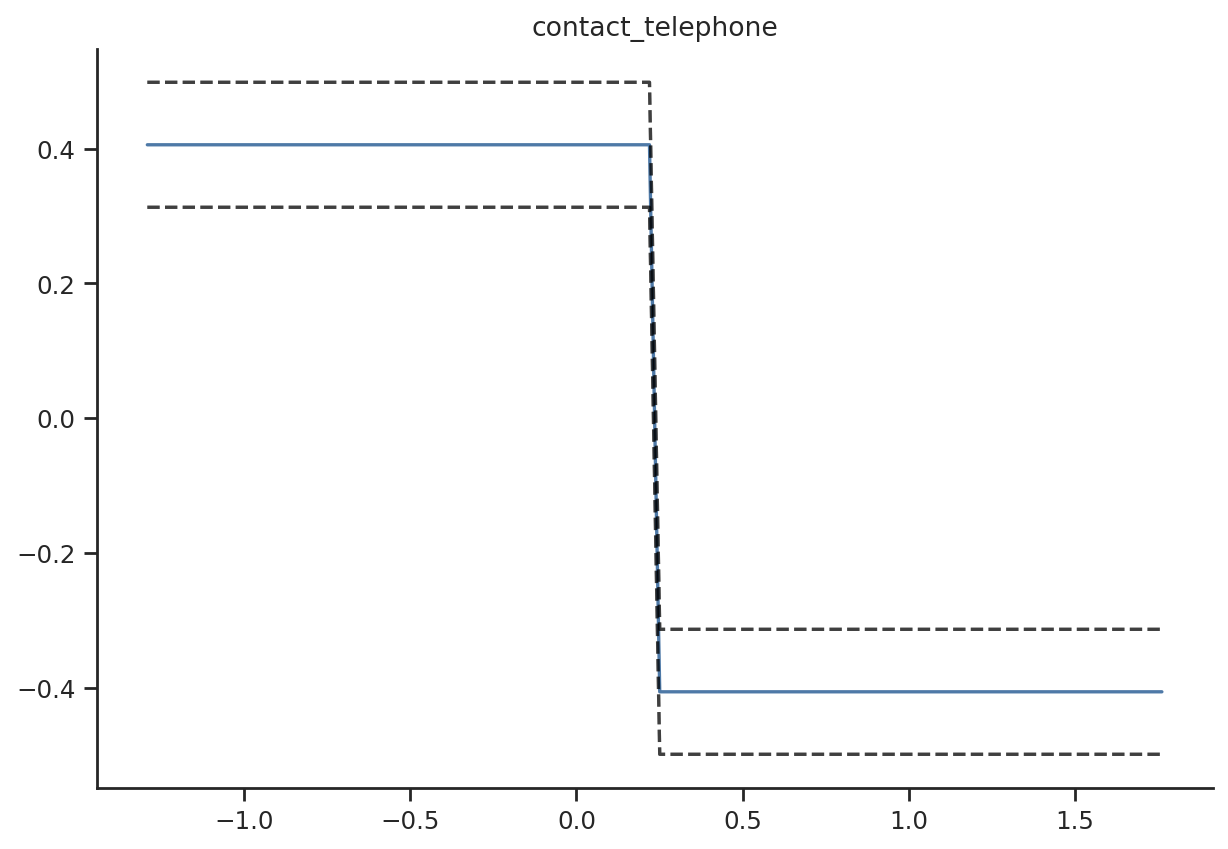

In [ ]:
for j, term in enumerate(gam7.terms):
    
    if term.isintercept:
        continue

    XX = gam7.generate_X_grid(term=j)
    pdep, confi = gam7.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.title(gam_feature1[j])
    sns.despine()
    plt.show()

## GAM 8

In [ ]:
from pygam import LogisticGAM, s, f, l, te
from optuna.samplers import TPESampler

def objective(trial):

    # We use factor function for categorical variables (even if we code them into numerical)
    # We find the same lambda for all models
    lambdas = []
    for j in range(len(gam_feature1)):
        lambdas.append(trial.suggest_loguniform(f'lambda_{j}', 1e-4, 10000.0))
                               
    model = LogisticGAM(l(0) + s(1,constraints='monotonic_dec') + s(2) + f(3), lam=lambdas)
    
    model.fit(gamX_train_s1, y_train)
    
    return model.statistics_['loglikelihood']

sampler = TPESampler(seed=7)  # makes the sampler behave in a deterministic way
study = optuna.create_study(direction='maximize', sampler=sampler) # TPE is a method for Bayesian optimisation
study.optimize(objective, n_trials=10000, timeout=120)

[I 2023-05-23 02:06:37,497] A new study created in memory with name: no-name-1f74c212-5842-4dba-bb02-f4a9e5b074ca
[I 2023-05-23 02:06:38,895] Trial 0 finished with value: -6563.700031663635 and parameters: {'lambda_0': 0.00040781792912640975, 'lambda_1': 173.52031920235248, 'lambda_2': 0.3215687604171317, 'lambda_3': 61.33684349587851}. Best is trial 0 with value: -6563.700031663635.
[I 2023-05-23 02:06:40,712] Trial 1 finished with value: -6815.194008188946 and parameters: {'lambda_0': 6666.779571482655, 'lambda_1': 2.0322024157213083, 'lambda_2': 1.0208541750449804, 'lambda_3': 0.00037705878770494}. Best is trial 0 with value: -6563.700031663635.
[I 2023-05-23 02:06:44,078] Trial 2 finished with value: -6582.104139553887 and parameters: {'lambda_0': 0.01404467975150636, 'lambda_1': 0.9978379258766116, 'lambda_2': 27.154384859236178, 'lambda_3': 269.0991269930257}. Best is trial 0 with value: -6563.700031663635.
[I 2023-05-23 02:06:47,230] Trial 3 finished with value: -6569.7934131730

In [ ]:
lambdas8 = list(study.best_params.values())
print(lambdas8)

[0.0034525968171037055, 106.85192247355513, 0.00010071914627686152, 0.3180140736530154]


In [ ]:
lambdas8 = [0.0034525968171037055, 106.85192247355513,
            0.00010071914627686152, 0.3180140736530154]
gam8 = LogisticGAM(l(0) + s(1,constraints='monotonic_dec') + s(2) + f(3), lam=lambdas8)
gam8.fit(gamX_train_s1, y_train)
gam8.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      11.922
Link Function:                        LogitLink Log Likelihood:                                 -6560.5226
Number of Samples:                        20775 AIC:                                            13144.8892
                                                AICc:                                           13144.9066
                                                UBRE:                                               2.6332
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.153
Feature Function                  Lam

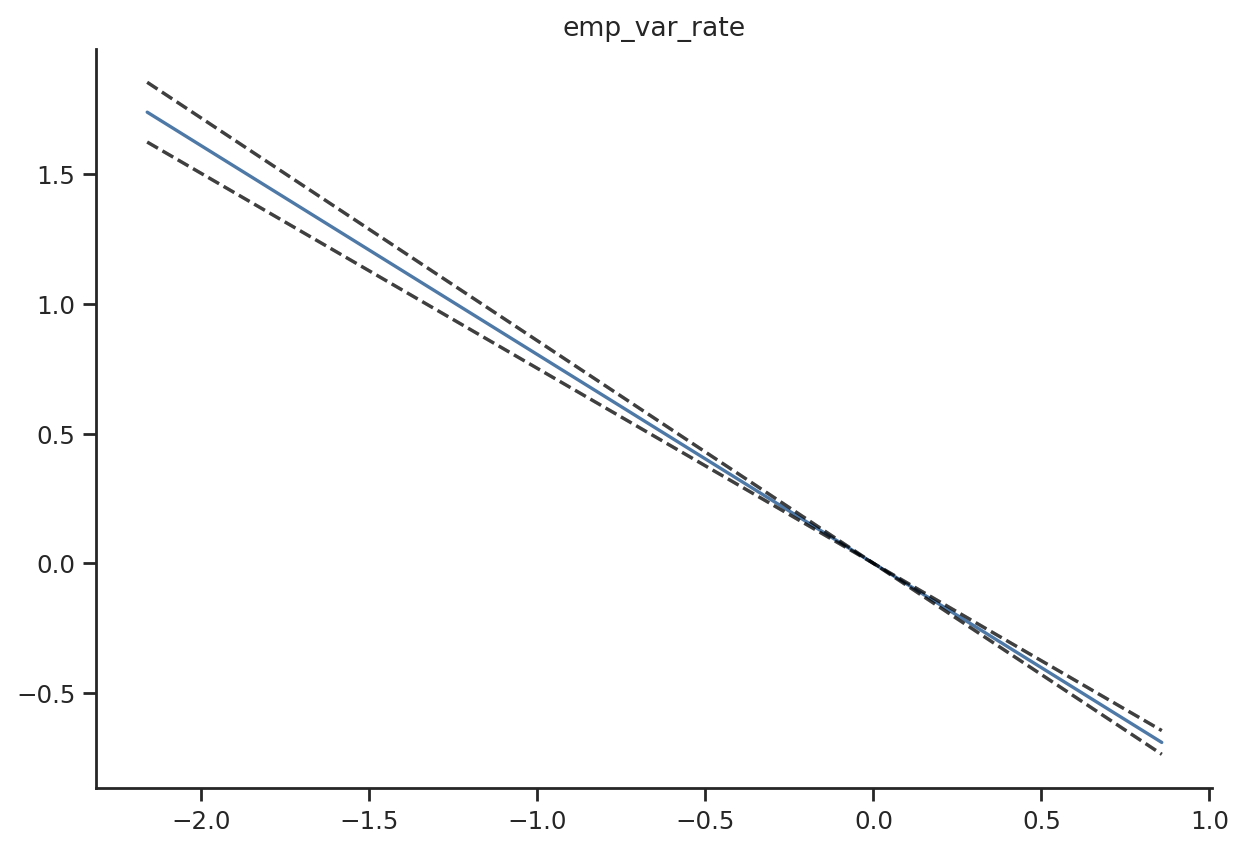

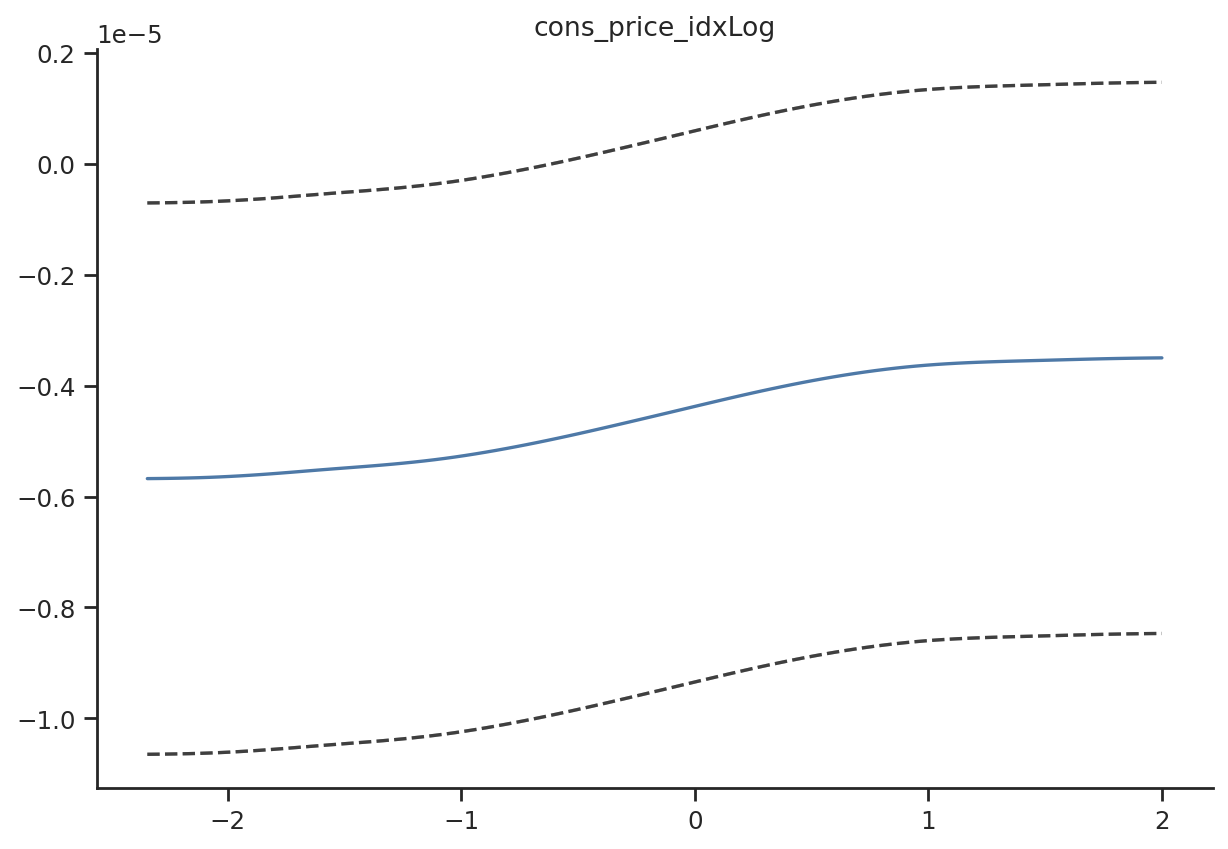

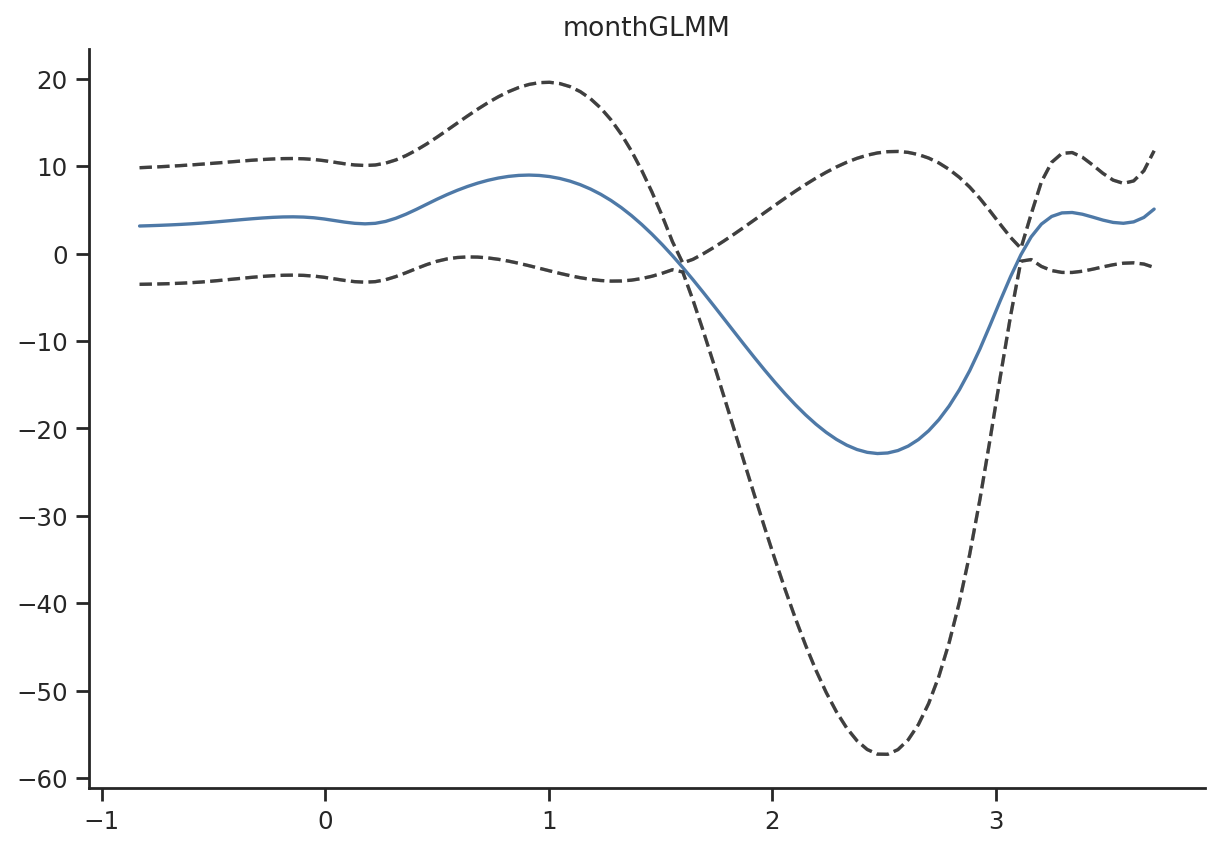

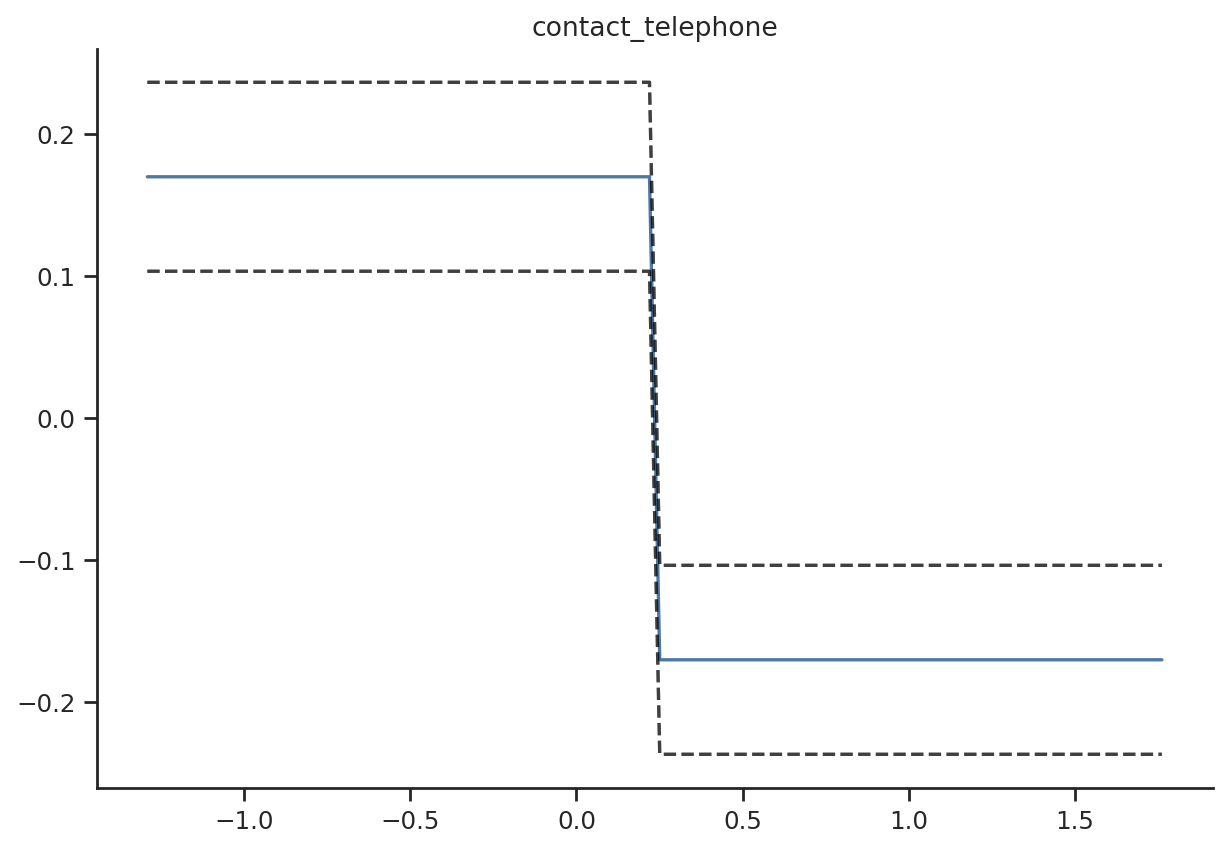

In [ ]:
for j, term in enumerate(gam8.terms):
    
    if term.isintercept:
        continue

    XX = gam8.generate_X_grid(term=j)
    pdep, confi = gam8.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.title(gam_feature1[j])
    sns.despine()
    plt.show()

## Validation Result

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, log_loss,f1_score

columns=['Loss', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score', 'Error Rate']

rows=['LogisticGAM 1','LogisticGAM 2','LogisticGAM 3',
      'LogisticGAM 4','LogisticGAM 5', 'LogisticGAM 6',
      'LogisticGAM 7', 'LogisticGAM 8']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[gam1,gam2,gam3,gam4,gam5,gam6,gam7,gam8]

y_valid = np.ravel(y_valid)
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):    
    if i < 1:
        y_prob[:,i] = method.predict_proba(gamX_valid_s)
    else:
        y_prob[:,i] = method.predict_proba(gamX_valid_s1)

    tau = 1/20       
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  19*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 


    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*9)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(y_valid))
    results.iloc[i,2] =  tp/(tp+fn)
    results.iloc[i,3] =  tn/(tn+fp)
    results.iloc[i,4] =  precision_score(y_valid, y_pred)
    results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,6] =  log_loss(y_valid, y_prob[:,i])
    results.iloc[i,7] =  f1_score(y_valid, y_pred)  #f1-score
    results.iloc[i,8] =   1 - accuracy_score(y_valid, y_pred) # error rate


results.sort_values(by=['AUC','F1-score'], ascending = [0,0]).round(5)

Loss       SE  Sensitivity  Specificity  Precision      AUC  \
LogisticGAM 6  0.84675  0.03339      0.86667      0.39239    0.16822  0.77778   
LogisticGAM 7  0.84675  0.03339      0.86667      0.39239    0.16822  0.77778   
LogisticGAM 3  0.85445  0.03319      0.86822      0.37942    0.16553  0.77776   
LogisticGAM 5  0.81517  0.02396      0.93333      0.24885    0.14979  0.76948   
LogisticGAM 4  0.81517  0.02396      0.93333      0.24885    0.14979  0.76686   
LogisticGAM 2  0.83481  0.03167      0.88062      0.36843    0.16507  0.76499   
LogisticGAM 1  0.83481  0.03167      0.88062      0.36843    0.16507  0.76310   
LogisticGAM 8  0.81613  0.02145      0.94729      0.21016    0.14534  0.75961   

               Cross-entropy  F1-score  Error Rate  
LogisticGAM 6        0.30719   0.28175     0.54871  
LogisticGAM 7        0.30717   0.28175     0.54871  
LogisticGAM 3        0.30802   0.27805     0.55988  
LogisticGAM 5        0.30870   0.25815     0.66615  
LogisticGAM 4        0.31123   0.25815     0.66615  
LogisticGAM 2        0.31753   0.27802     0.56796  
LogisticGAM 1        0.31696   0.27802     0.56796  
LogisticGAM 8        0.32267   0.25201     0.69831

In [ ]:
results.sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(5)

Loss       SE  Sensitivity  Specificity  Precision      AUC  \
LogisticGAM 6  0.84675  0.03339      0.86667      0.39239    0.16822  0.77778   
LogisticGAM 7  0.84675  0.03339      0.86667      0.39239    0.16822  0.77778   
LogisticGAM 3  0.85445  0.03319      0.86822      0.37942    0.16553  0.77776   
LogisticGAM 2  0.83481  0.03167      0.88062      0.36843    0.16507  0.76499   
LogisticGAM 1  0.83481  0.03167      0.88062      0.36843    0.16507  0.76310   
LogisticGAM 5  0.81517  0.02396      0.93333      0.24885    0.14979  0.76948   
LogisticGAM 4  0.81517  0.02396      0.93333      0.24885    0.14979  0.76686   
LogisticGAM 8  0.81613  0.02145      0.94729      0.21016    0.14534  0.75961   

               Cross-entropy  F1-score  Error Rate  
LogisticGAM 6        0.30719   0.28175     0.54871  
LogisticGAM 7        0.30717   0.28175     0.54871  
LogisticGAM 3        0.30802   0.27805     0.55988  
LogisticGAM 2        0.31753   0.27802     0.56796  
LogisticGAM 1        0.31696   0.27802     0.56796  
LogisticGAM 5        0.30870   0.25815     0.66615  
LogisticGAM 4        0.31123   0.25815     0.66615  
LogisticGAM 8        0.32267   0.25201     0.69831

In [ ]:
results.sort_values(by=['Loss'], ascending = [1]).round(5)

Loss       SE  Sensitivity  Specificity  Precision      AUC  \
LogisticGAM 4  0.81517  0.02396      0.93333      0.24885    0.14979  0.76686   
LogisticGAM 5  0.81517  0.02396      0.93333      0.24885    0.14979  0.76948   
LogisticGAM 8  0.81613  0.02145      0.94729      0.21016    0.14534  0.75961   
LogisticGAM 1  0.83481  0.03167      0.88062      0.36843    0.16507  0.76310   
LogisticGAM 2  0.83481  0.03167      0.88062      0.36843    0.16507  0.76499   
LogisticGAM 6  0.84675  0.03339      0.86667      0.39239    0.16822  0.77778   
LogisticGAM 7  0.84675  0.03339      0.86667      0.39239    0.16822  0.77778   
LogisticGAM 3  0.85445  0.03319      0.86822      0.37942    0.16553  0.77776   

               Cross-entropy  F1-score  Error Rate  
LogisticGAM 4        0.31123   0.25815     0.66615  
LogisticGAM 5        0.30870   0.25815     0.66615  
LogisticGAM 8        0.32267   0.25201     0.69831  
LogisticGAM 1        0.31696   0.27802     0.56796  
LogisticGAM 2        0.31753   0.27802     0.56796  
LogisticGAM 6        0.30719   0.28175     0.54871  
LogisticGAM 7        0.30717   0.28175     0.54871  
LogisticGAM 3        0.30802   0.27805     0.55988

(True Negatives):  1132
(False Positives):  3417
(False Negatives):  43
(True Positives):  602
Total Actuall Subscribed:  645
(True Negatives):  2430
(False Positives):  7350
(False Negatives):  91
(True Positives):  1259
Total Actuall Subscribed:  1350


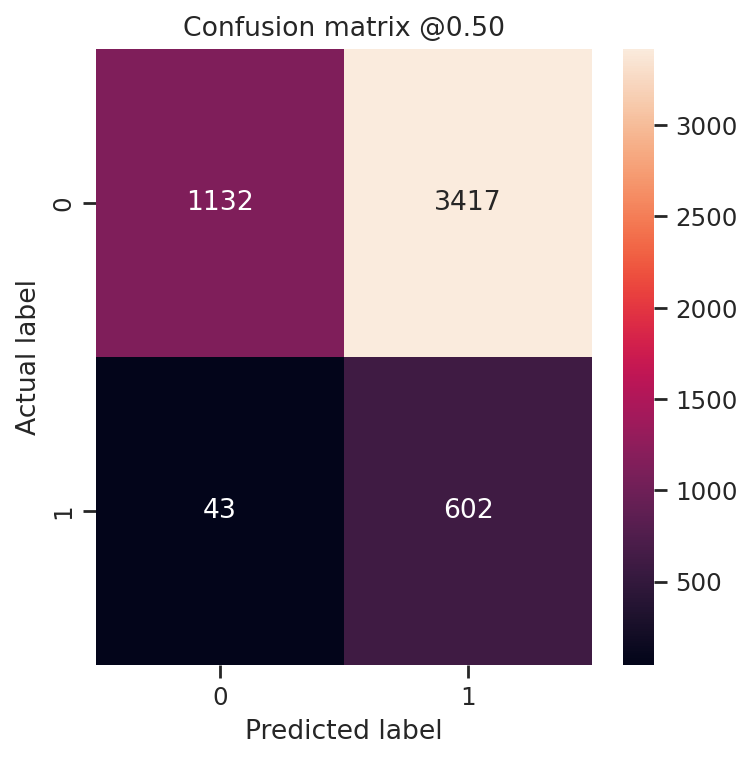

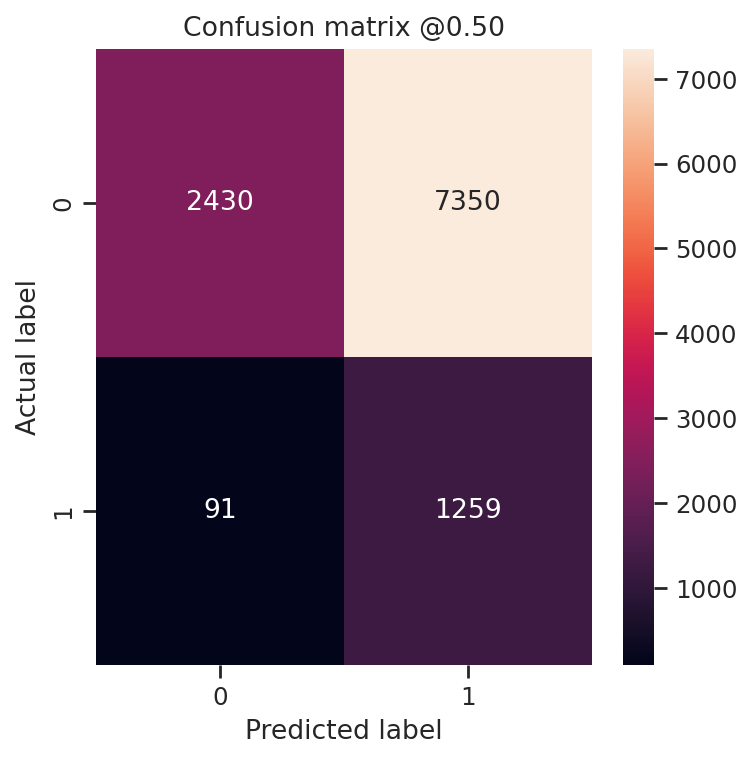

In [ ]:
# GAM 4

tau = 1/20

method = gam4


y_prob = method.predict_proba(gamX_valid_s1)
y_pred = [1 if x >= tau else 0 for x in y_prob]


plot_cm(y_valid, y_pred)


y_prob = method.predict_proba(gamX_test_s1)
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

(True Negatives):  1785
(False Positives):  2764
(False Negatives):  86
(True Positives):  559
Total Actuall Subscribed:  645
(True Negatives):  3721
(False Positives):  6059
(False Negatives):  140
(True Positives):  1210
Total Actuall Subscribed:  1350


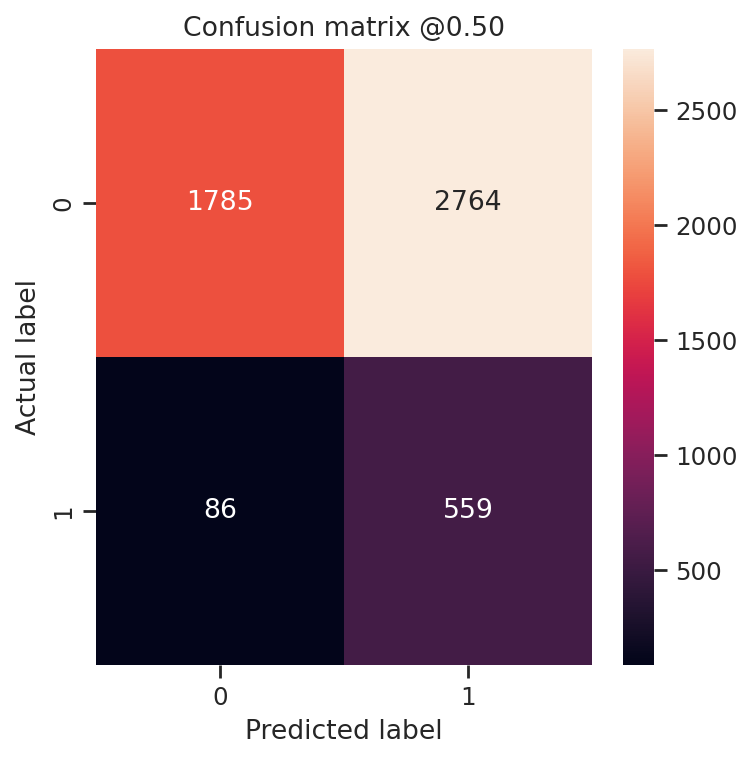

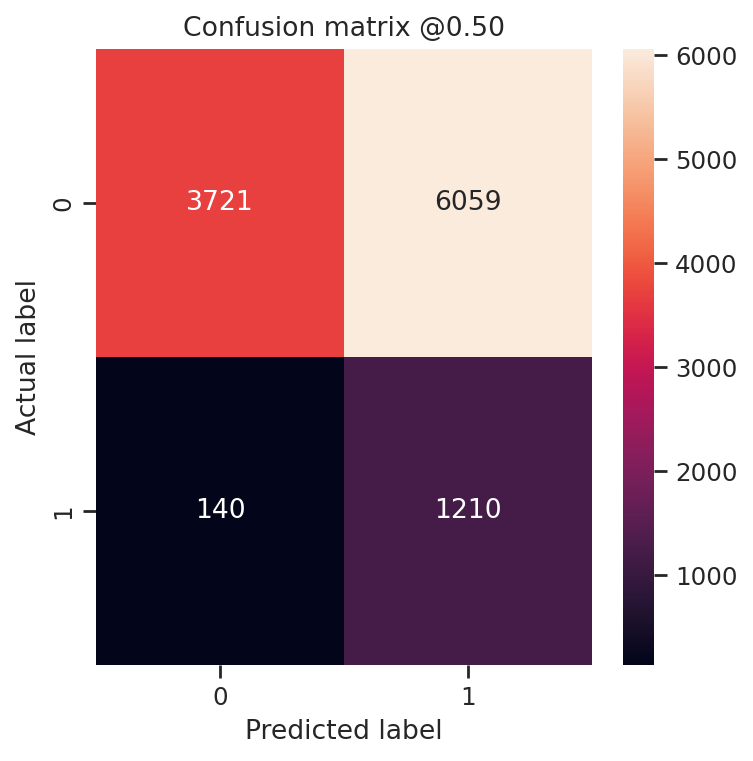

In [ ]:
# GAM 6

tau = 1/20

method = gam6


y_prob = method.predict_proba(gamX_valid_s1)
y_pred = [1 if x >= tau else 0 for x in y_prob]


plot_cm(y_valid, y_pred)


y_prob = method.predict_proba(gamX_test_s1)
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

(True Negatives):  1785
(False Positives):  2764
(False Negatives):  86
(True Positives):  559
Total Actuall Subscribed:  645
(True Negatives):  3721
(False Positives):  6059
(False Negatives):  140
(True Positives):  1210
Total Actuall Subscribed:  1350


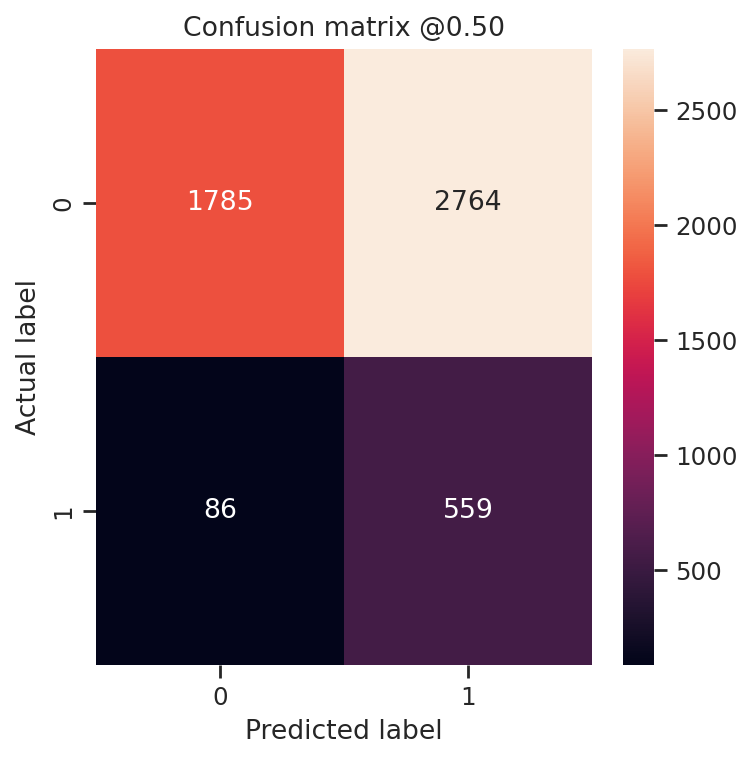

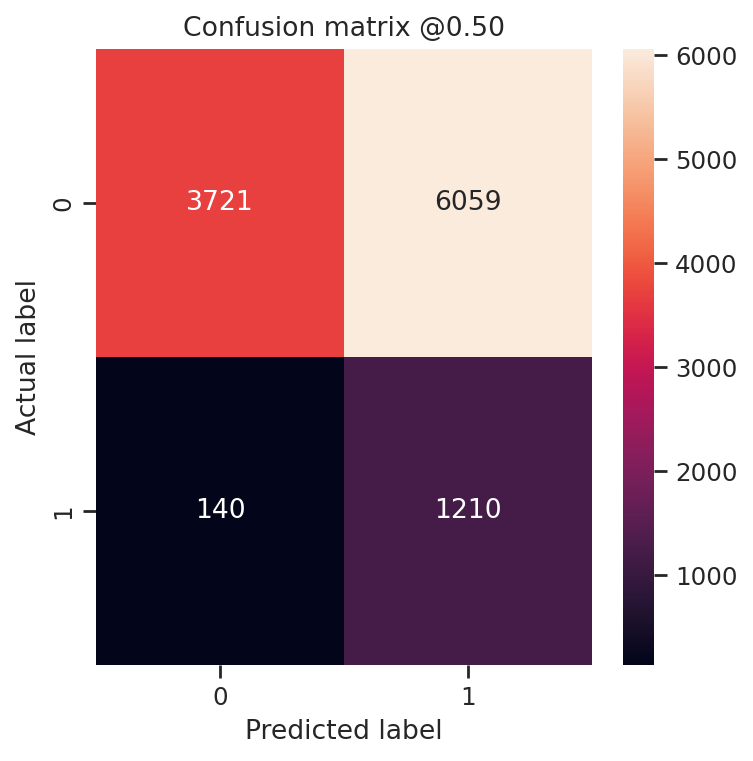

In [ ]:
# GAM 7

tau = 1/20

method = gam7


y_prob = method.predict_proba(gamX_valid_s1)
y_pred = [1 if x >= tau else 0 for x in y_prob]


plot_cm(y_valid, y_pred)


y_prob = method.predict_proba(gamX_test_s1)
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

(True Negatives):  1132
(False Positives):  3417
(False Negatives):  43
(True Positives):  602
Total Actuall Subscribed:  645
(True Negatives):  2430
(False Positives):  7350
(False Negatives):  91
(True Positives):  1259
Total Actuall Subscribed:  1350


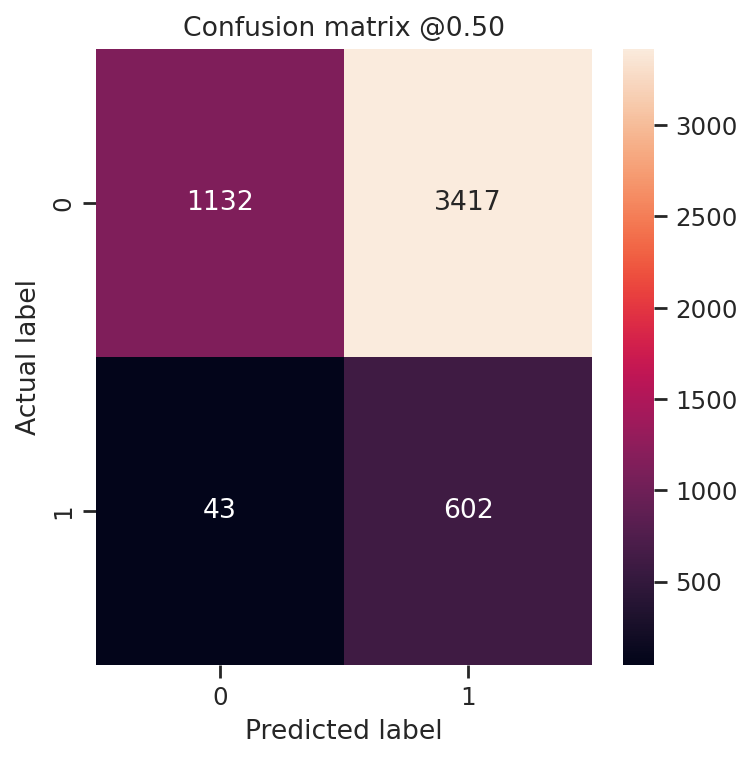

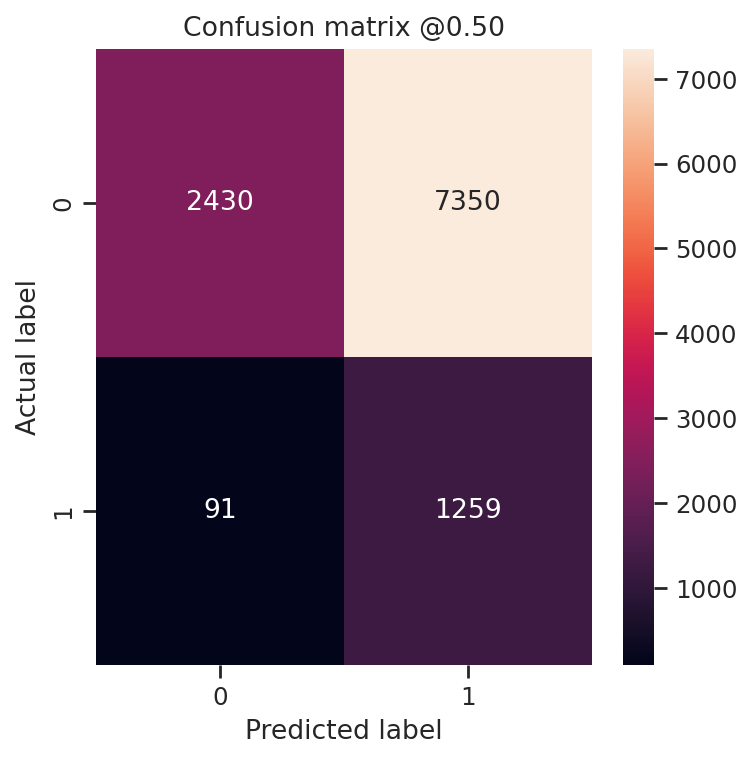

In [ ]:
# GAM 5

tau = 1/20

method = gam5


y_prob = method.predict_proba(gamX_valid_s1)
y_pred = [1 if x >= tau else 0 for x in y_prob]


plot_cm(y_valid, y_pred)


y_prob = method.predict_proba(gamX_test_s1)
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

## Best LogisticGAM (Best linear)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pygam import LogisticGAM, s, f, l, te

gam_feature1 = ['emp_var_rate',
                'cons_price_idxLog',
                'monthGLMM',
                'contact_telephone']

gamX_train1 = train[gam_feature1]
gamX_valid1 = valid[gam_feature1]
gamX_test1 = test[gam_feature1]


# Standardization

scaler = StandardScaler()
gamX_train_s1 = scaler.fit_transform(gamX_train1)
gamX_valid_s1 = scaler.transform(gamX_valid1)
gamX_test_s1 = scaler.transform(gamX_test1)

gamX_train1.head()

In [ ]:
lambdas6 = [37.87100184322894, 0.00010223697752598182,
            0.00010004477745950303, 0.01513717489920891]
gam6 = LogisticGAM(l(0) + s(1) + s(2) + f(3), lam=lambdas6)
gam6.fit(gamX_train_s1, y_train)
gam6.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     26.7591
Link Function:                        LogitLink Log Likelihood:                                 -6259.3005
Number of Samples:                        20775 AIC:                                            12572.1193
                                                AICc:                                           12572.1962
                                                UBRE:                                               2.6062
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1919
Feature Function                  Lam

In [ ]:
gam6.terms

l(0) + s(1) + s(2) + f(3) + intercept

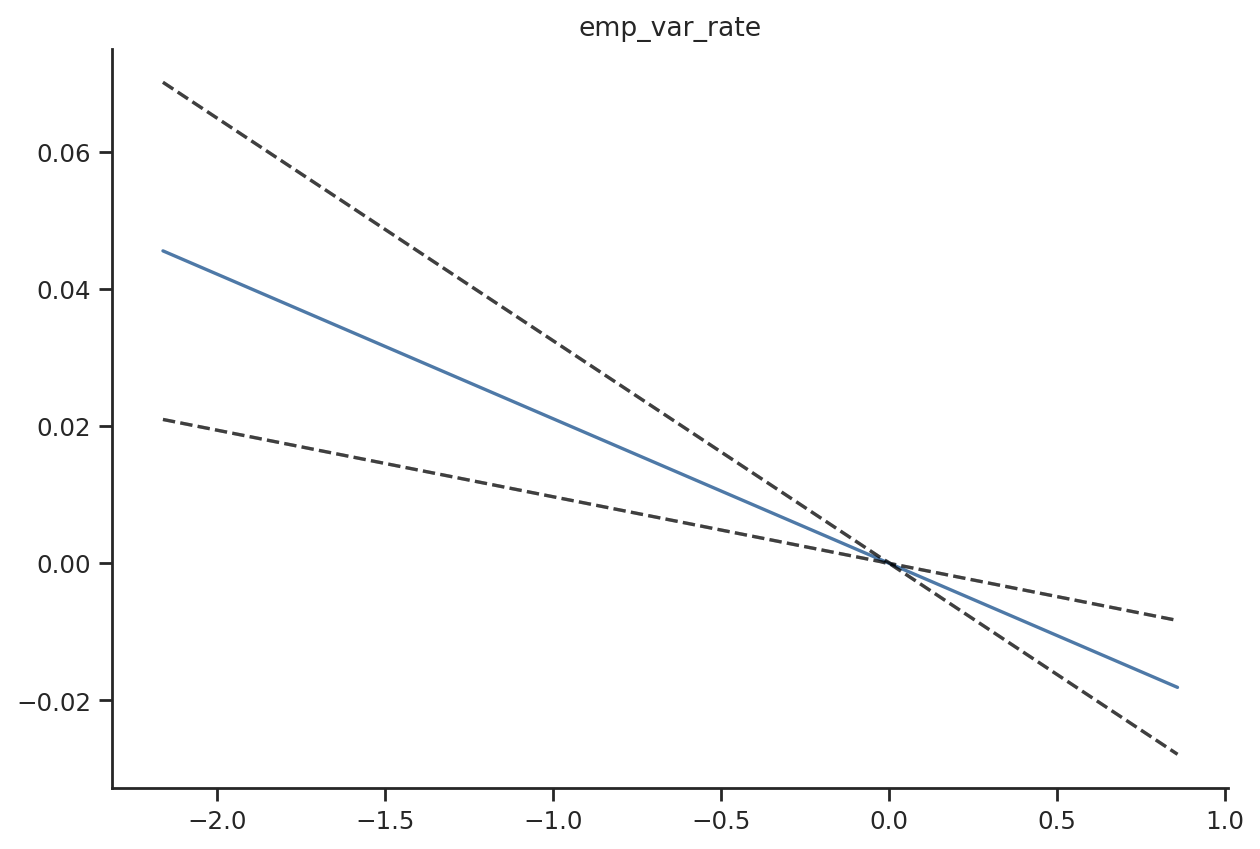

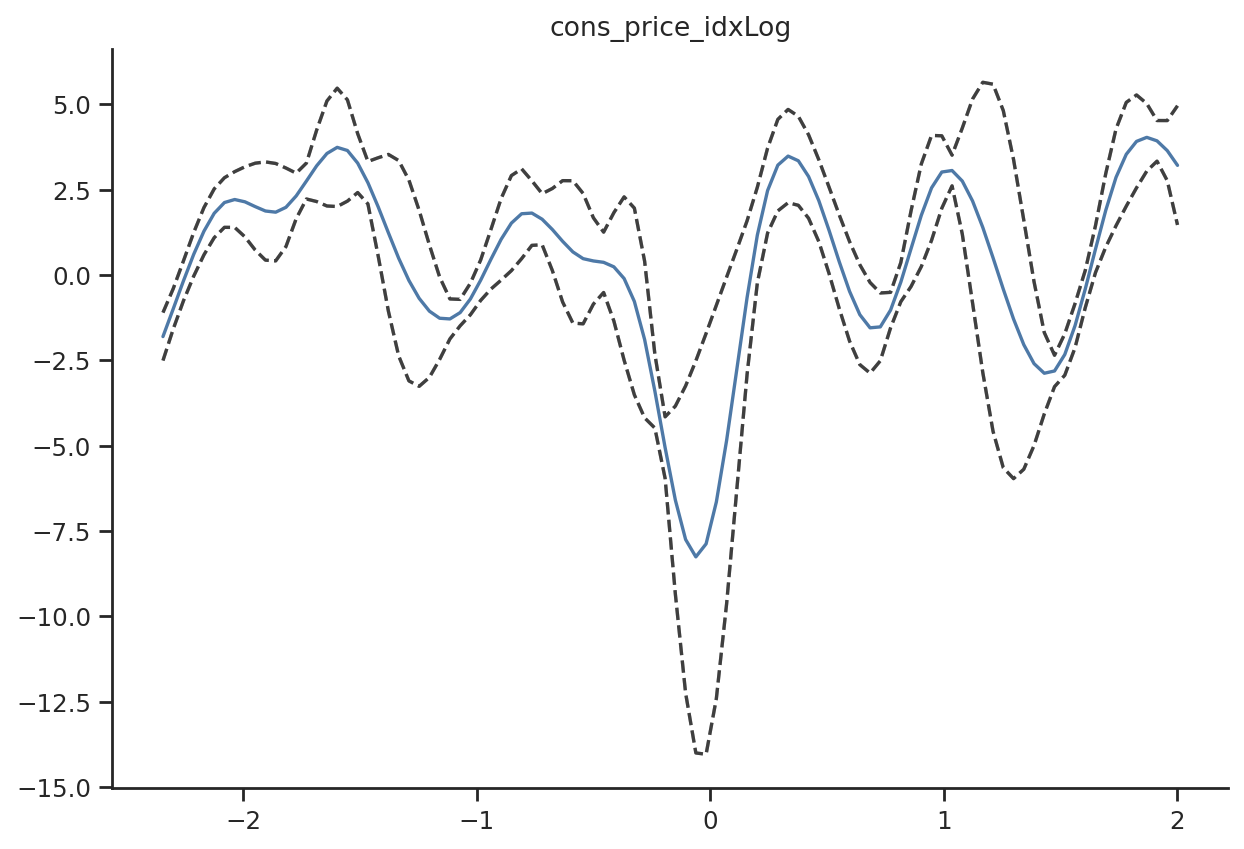

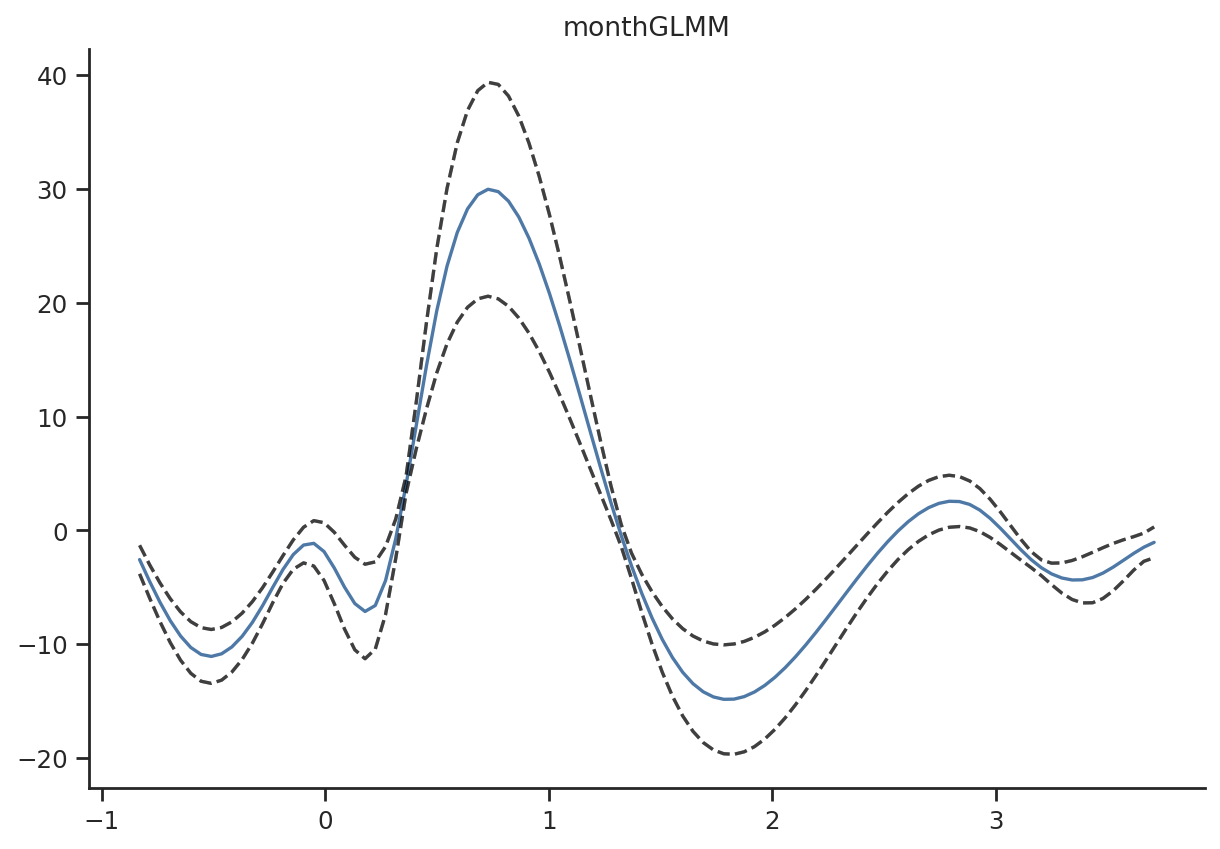

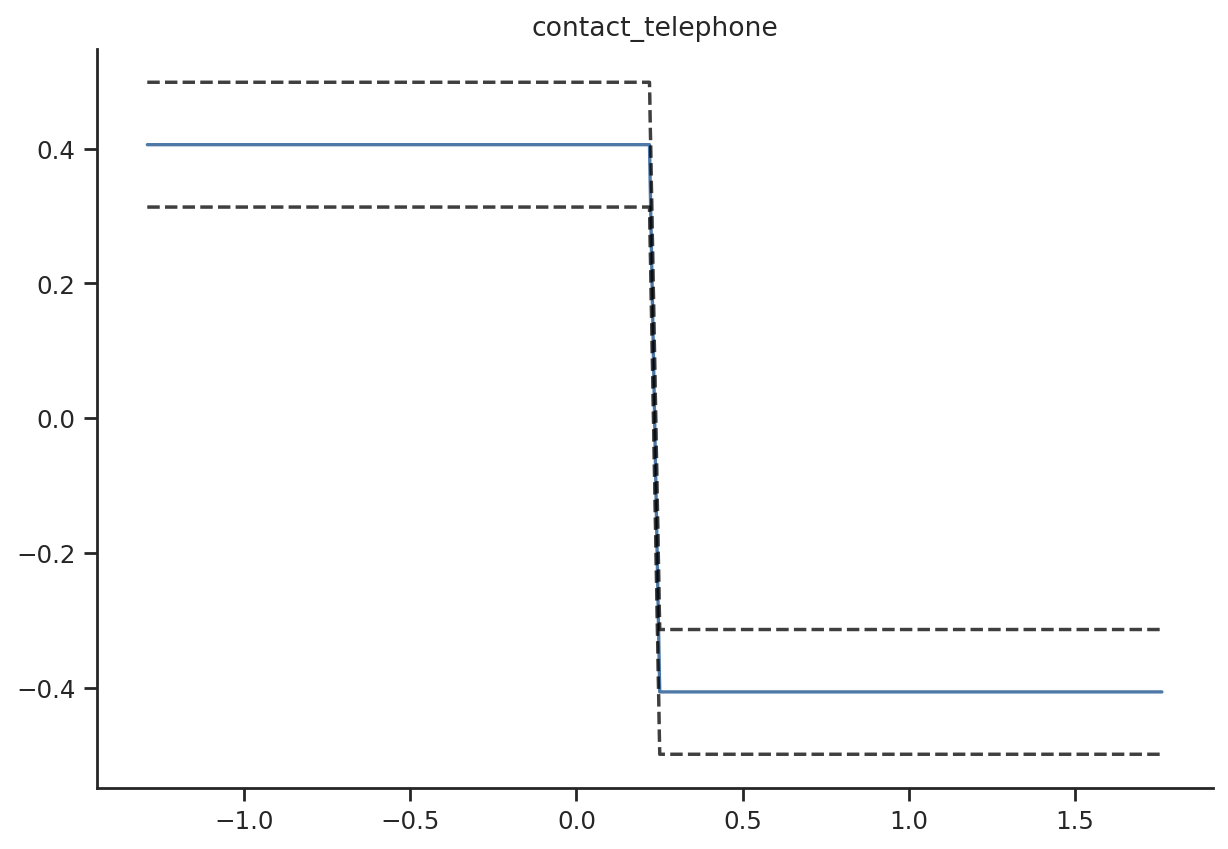

In [ ]:
for j, term in enumerate(gam6.terms):
    
    if term.isintercept:
        continue

    XX = gam6.generate_X_grid(term=j)
    pdep, confi = gam6.partial_dependence(term=j, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.plot(XX[:, term.feature], confi, c='black', ls='--', alpha=0.5)
    
    plt.title(gam_feature1[j])
    sns.despine()
    plt.show()

(True Negatives):  1785
(False Positives):  2764
(False Negatives):  86
(True Positives):  559
Total Actuall Subscribed:  645
(True Negatives):  3721
(False Positives):  6059
(False Negatives):  140
(True Positives):  1210
Total Actuall Subscribed:  1350


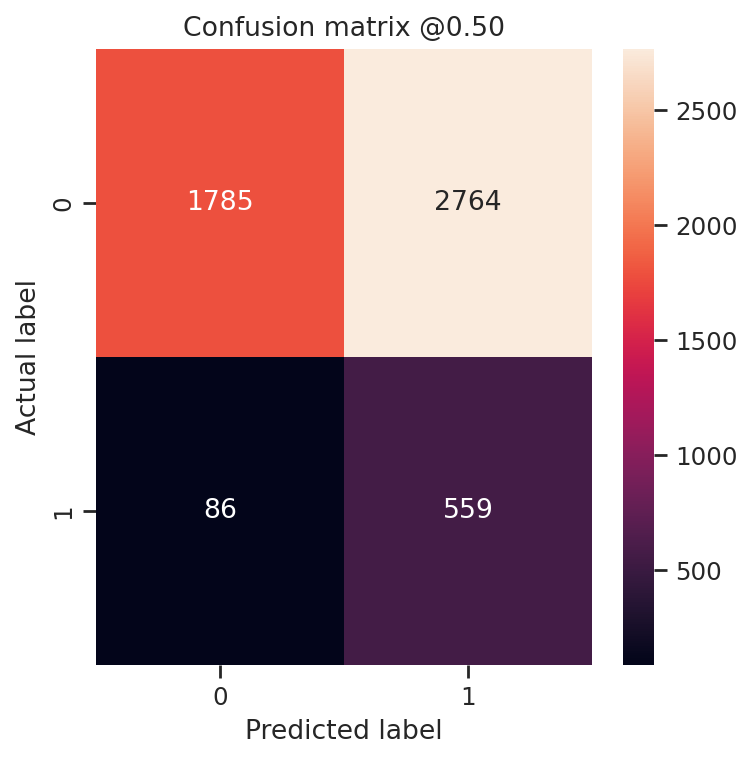

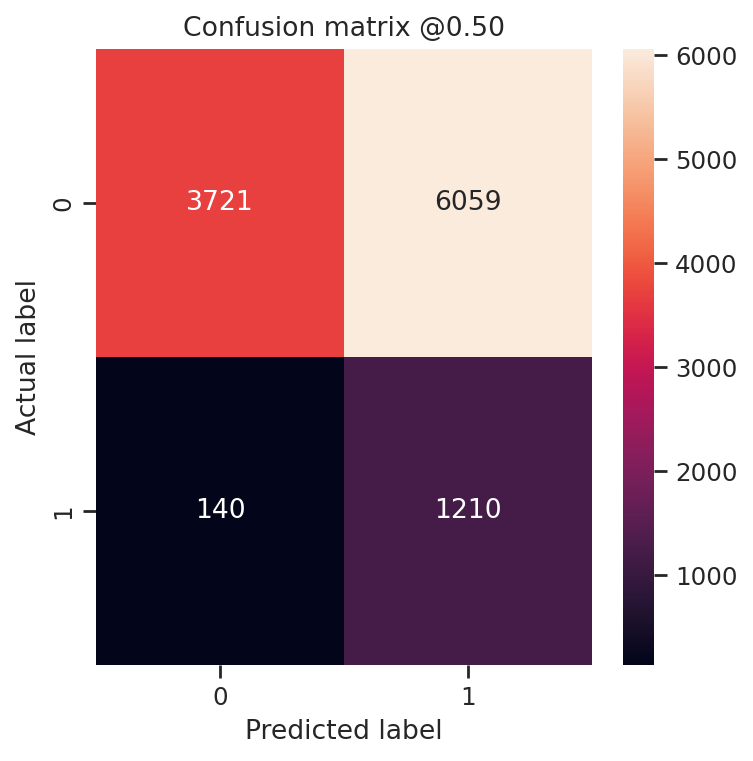

In [ ]:
# GAM 6

tau = 1/20

method = gam6


y_prob = method.predict_proba(gamX_valid_s1)
y_pred = [1 if x >= tau else 0 for x in y_prob]


plot_cm(y_valid, y_pred)


y_prob = method.predict_proba(gamX_test_s1)
y_pred = [1 if x >= tau else 0 for x in y_prob]

plot_cm(y_test,y_pred)

#End